In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    hh = generate_h(n_beta, t_len, normalize)
    bb = generate_beta(n_beta, t_len, normalize)
    total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    x = np.hstack((t, hh, bb, total_coords))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [10]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp_ = np.arange(10, 15, t_interval).reshape((-1,1))
        time_interp = (time_interp_-10)/5 # Normalizing time
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and $C_m$: ", input_time_cm.shape)
    return input_time_cm

In [11]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [12]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>10:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [13]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [14]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [15]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [16]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [17]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and $C_m$:  (80000, 2)
Dimension - heights of Gurney flaps:  (80000, 1)
Dimension - inclination(beta):  (80000, 1)
Dimension - airfoil coordinates:  (80000, 100)
Dimension - coord with flaps:  (80000, 10)
Dimension - total coordinates:  (80000, 110)
Dimension - x:  (80000, 113)
Dimension - y:  (80000, 1)


In [18]:
def dataset_split(x, y, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test = train_test_split(x, y, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=val_rate/(1-test_rate),  random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test
    else:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test

In [19]:
x_train, x_val, x_test, y_train, y_val, y_test = dataset_split(x, y, test_rate, val_rate=val_rate, validation=True, random_state=26)

In [20]:
x_train.shape

(55999, 113)

In [21]:
x_train[0,:]

array([ 0.0048    ,  0.33333333,  0.5       ,  0.00427164,  0.00842234,
        0.01246981,  0.01642156,  0.02027698,  0.02404052,  0.02771599,
        0.03130481,  0.0348029 ,  0.03821789,  0.04155417,  0.04480337,
        0.04797466,  0.05105962,  0.0540609 ,  0.05698391,  0.05981111,
        0.06255477,  0.06520957,  0.06775739,  0.07021322,  0.07256919,
        0.07480527,  0.07692563,  0.07892746,  0.08080335,  0.08252498,
        0.08410421,  0.08553293,  0.08678237,  0.08784509,  0.08872199,
        0.08938369,  0.08980556,  0.089997  ,  0.08990554,  0.08952548,
        0.08883208,  0.08777314,  0.08633761,  0.084467  ,  0.0820983 ,
        0.07919204,  0.07565321,  0.07134219,  0.06610518,  0.05970001,
        0.05175948,  0.04143287,  0.02689964, -0.02689964, -0.04143287,
       -0.05175948, -0.05970001, -0.06610518, -0.07134219, -0.07565321,
       -0.07919204, -0.0820983 , -0.084467  , -0.08633761, -0.08777314,
       -0.08883208, -0.08952548, -0.08990554, -0.089997  , -0.08

In [22]:
def make_mlp_model(num_layer:int = 5): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=(x_train.shape[1]))

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [23]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 113)]             0         
                                                                 
 fc1 (Dense)                 (None, 256)               29184     
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [25]:
model_directory = "D:\\TrainedModels\\20221219"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [26]:
ckpt_name = model_directory + "20221219unsteadyPrediction_MLP_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, min_delta=1e-09,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-10, min_lr=1e-06, verbose=1)

In [27]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [28]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.0469 - rmse: 0.2160
Epoch 1: val_loss improved from inf to 0.03683, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 2s 12ms/step - loss: 0.0461 - rmse: 0.2141 - val_loss: 0.0368 - val_rmse: 0.1913 - lr: 1.0000e-04
Epoch 2/10000
48/55 [=========================>....] - ETA: 0s - loss: 0.0306 - rmse: 0.1743
Epoch 2: val_loss improved from 0.03683 to 0.02143, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 6ms/step - loss: 0.0296 - rmse: 0.1714 - val_loss: 0.0214 - val_rmse: 0.1455 - lr: 1.0000e-04
Epoch 3/10000
50/55 [==========================>...] - ETA: 0s - loss: 0.0135 - rmse: 0.1149
Epoch 3: val_loss improved from 0.02143 to 0.00422, saving model to D:\TrainedModels\2022121920221219unste

55/55 [==============================] - ETA: 0s - loss: 2.4815e-04 - rmse: 0.0031
Epoch 21: val_loss did not improve from 0.00024
55/55 [==============================] - 0s 7ms/step - loss: 2.4815e-04 - rmse: 0.0031 - val_loss: 2.4349e-04 - val_rmse: 0.0023 - lr: 1.0000e-04
Epoch 22/10000
55/55 [==============================] - ETA: 0s - loss: 2.3974e-04 - rmse: 0.0015
Epoch 22: val_loss improved from 0.00024 to 0.00024, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.3974e-04 - rmse: 0.0015 - val_loss: 2.3792e-04 - val_rmse: 0.0010 - lr: 1.0000e-04
Epoch 23/10000
55/55 [==============================] - ETA: 0s - loss: 2.4056e-04 - rmse: 0.0021
Epoch 23: val_loss improved from 0.00024 to 0.00024, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================

Epoch 44/10000
48/55 [=========================>....] - ETA: 0s - loss: 2.1491e-04 - rmse: 7.9841e-04
Epoch 44: val_loss improved from 0.00022 to 0.00021, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.1486e-04 - rmse: 8.0351e-04 - val_loss: 2.1426e-04 - val_rmse: 7.2914e-04 - lr: 1.0000e-04
Epoch 45/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.2133e-04 - rmse: 0.0028
Epoch 45: val_loss did not improve from 0.00021
55/55 [==============================] - 0s 8ms/step - loss: 2.2077e-04 - rmse: 0.0027 - val_loss: 2.1727e-04 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 46/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.1359e-04 - rmse: 0.0011
Epoch 46: val_loss improved from 0.00021 to 0.00021, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [===

Epoch 67/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.0733e-04 - rmse: 0.0035
Epoch 67: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 10ms/step - loss: 2.0690e-04 - rmse: 0.0035 - val_loss: 1.9619e-04 - val_rmse: 0.0013 - lr: 1.0000e-04
Epoch 68/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.9722e-04 - rmse: 0.0018
Epoch 68: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.9748e-04 - rmse: 0.0018 - val_loss: 1.9529e-04 - val_rmse: 0.0013 - lr: 1.0000e-04
Epoch 69/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.9530e-04 - rmse: 0.0014
Epoch 69: val_loss did not improve from 0.00020
55/55 [==============

Epoch 90/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.8159e-04 - rmse: 0.0013
Epoch 90: val_loss did not improve from 0.00018
55/55 [==============================] - 0s 7ms/step - loss: 1.8151e-04 - rmse: 0.0012 - val_loss: 1.8337e-04 - val_rmse: 0.0019 - lr: 1.0000e-04
Epoch 91/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.9469e-04 - rmse: 0.0039
Epoch 91: val_loss improved from 0.00018 to 0.00018, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.9356e-04 - rmse: 0.0038 - val_loss: 1.8018e-04 - val_rmse: 0.0010 - lr: 1.0000e-04
Epoch 92/10000
54/55 [============================>.] - ETA: 0s - loss: 1.8180e-04 - rmse: 0.0017
Epoch 92: val_loss did not improve from 0.00018
55/55 [==============================] - 0s 7ms/step - loss: 1.8176e-04 - rmse: 0.0017 - val_loss: 1.8022e-04 - val_rmse: 0.0013 - lr: 1.0000e-04


Epoch 114/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.6861e-04 - rmse: 7.0414e-04
Epoch 114: val_loss did not improve from 0.00017
55/55 [==============================] - 0s 8ms/step - loss: 1.6862e-04 - rmse: 7.2372e-04 - val_loss: 1.7069e-04 - val_rmse: 0.0017 - lr: 1.0000e-04
Epoch 115/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.0290e-04 - rmse: 0.0059
Epoch 115: val_loss did not improve from 0.00017
55/55 [==============================] - 0s 8ms/step - loss: 2.0177e-04 - rmse: 0.0058 - val_loss: 1.7439e-04 - val_rmse: 0.0026 - lr: 1.0000e-04
Epoch 116/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.6872e-04 - rmse: 0.0012
Epoch 116: val_loss improved from 0.00017 to 0.00017, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.6859e-04 - rmse: 0.0012 - val_loss: 1.6743e-04 - val_rmse: 6.3477e-04

55/55 [==============================] - 0s 9ms/step - loss: 1.5986e-04 - rmse: 5.6595e-04 - val_loss: 1.5964e-04 - val_rmse: 5.2601e-04 - lr: 1.0000e-04
Epoch 137/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.5956e-04 - rmse: 5.8859e-04
Epoch 137: val_loss improved from 0.00016 to 0.00016, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.5955e-04 - rmse: 6.0118e-04 - val_loss: 1.5935e-04 - val_rmse: 5.8021e-04 - lr: 1.0000e-04
Epoch 138/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.5915e-04 - rmse: 5.2954e-04
Epoch 138: val_loss did not improve from 0.00016
55/55 [==============================] - 0s 8ms/step - loss: 1.5913e-04 - rmse: 5.3626e-04 - val_loss: 1.5943e-04 - val_rmse: 8.7018e-04 - lr: 1.0000e-04
Epoch 139/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.6062e-04 - rmse: 0.0014
Epoch 139: 

Epoch 161/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.5373e-04 - rmse: 0.0014
Epoch 161: val_loss did not improve from 0.00015
55/55 [==============================] - 0s 8ms/step - loss: 1.5362e-04 - rmse: 0.0014 - val_loss: 1.5485e-04 - val_rmse: 0.0018 - lr: 1.0000e-04
Epoch 162/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.5614e-04 - rmse: 0.0022
Epoch 162: val_loss did not improve from 0.00015
55/55 [==============================] - 0s 8ms/step - loss: 1.5581e-04 - rmse: 0.0021 - val_loss: 1.5633e-04 - val_rmse: 0.0023 - lr: 1.0000e-04
Epoch 163/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.5852e-04 - rmse: 0.0027
Epoch 163: val_loss improved from 0.00015 to 0.00015, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 9ms/step - loss: 1.5801e-04 - rmse: 0.0026 - val_loss: 1.5135e-04 - val_rmse: 6.3640e-04 - lr: 1

Epoch 183/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.4614e-04 - rmse: 3.8441e-04
Epoch 183: val_loss did not improve from 0.00015
55/55 [==============================] - 0s 8ms/step - loss: 1.4614e-04 - rmse: 3.9247e-04 - val_loss: 1.4683e-04 - val_rmse: 9.8366e-04 - lr: 1.0000e-04
Epoch 184/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.4620e-04 - rmse: 6.6942e-04
Epoch 184: val_loss improved from 0.00015 to 0.00015, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 10ms/step - loss: 1.4620e-04 - rmse: 6.6805e-04 - val_loss: 1.4595e-04 - val_rmse: 5.6500e-04 - lr: 1.0000e-04
Epoch 185/10000
48/55 [=========================>....] - ETA: 0s - loss: 1.4741e-04 - rmse: 0.0014
Epoch 185: val_loss did not improve from 0.00015
55/55 [==============================] - 0s 8ms/step - loss: 1.4755e-04 - rmse: 0.0014 - val_loss: 1.4924e-04 - val

Epoch 206/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.4378e-04 - rmse: 0.0017
Epoch 206: val_loss improved from 0.00014 to 0.00014, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.4382e-04 - rmse: 0.0017 - val_loss: 1.4124e-04 - val_rmse: 6.6620e-04 - lr: 1.0000e-04
Epoch 207/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.4332e-04 - rmse: 0.0016
Epoch 207: val_loss did not improve from 0.00014
55/55 [==============================] - 0s 8ms/step - loss: 1.4335e-04 - rmse: 0.0016 - val_loss: 1.4315e-04 - val_rmse: 0.0016 - lr: 1.0000e-04
Epoch 208/10000
54/55 [============================>.] - ETA: 0s - loss: 1.4580e-04 - rmse: 0.0023
Epoch 208: val_loss did not improve from 0.00014
55/55 [==============================] - 0s 9ms/step - loss: 1.4582e-04 - rmse: 0.0023 - val_loss: 1.4883e-04 - val_rmse: 0.0029 - lr: 1

49/55 [=========================>....] - ETA: 0s - loss: 1.3724e-04 - rmse: 9.7124e-04
Epoch 230: val_loss did not improve from 0.00014
55/55 [==============================] - 0s 8ms/step - loss: 1.4009e-04 - rmse: 0.0019 - val_loss: 1.8163e-04 - val_rmse: 0.0067 - lr: 1.0000e-04
Epoch 231/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.4337e-04 - rmse: 0.0027
Epoch 231: val_loss did not improve from 0.00014
55/55 [==============================] - 0s 8ms/step - loss: 1.4311e-04 - rmse: 0.0026 - val_loss: 1.3713e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 232/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3649e-04 - rmse: 7.4157e-04
Epoch 232: val_loss improved from 0.00014 to 0.00014, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.3646e-04 - rmse: 7.2672e-04 - val_loss: 1.3607e-04 - val_rmse: 4.7921e-04 - lr: 1.000

49/55 [=========================>....] - ETA: 0s - loss: 1.3958e-04 - rmse: 0.0027
Epoch 253: val_loss did not improve from 0.00013
55/55 [==============================] - 0s 8ms/step - loss: 1.3891e-04 - rmse: 0.0025 - val_loss: 1.3443e-04 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 254/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3374e-04 - rmse: 0.0012    
Epoch 254: val_loss did not improve from 0.00013
55/55 [==============================] - 0s 8ms/step - loss: 1.3384e-04 - rmse: 0.0012 - val_loss: 1.3344e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 255/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3689e-04 - rmse: 0.0022
Epoch 255: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 10ms/step - loss: 1.3650e-04 - rmse: 0.0021 - val_loss: 1.3237e-04 - val_rmse: 5.6404e-04 - lr: 1.0000e-04
E

54/55 [============================>.] - ETA: 0s - loss: 1.2935e-04 - rmse: 3.1423e-04
Epoch 275: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 9ms/step - loss: 1.2934e-04 - rmse: 3.1367e-04 - val_loss: 1.2926e-04 - val_rmse: 2.8491e-04 - lr: 1.0000e-04
Epoch 276/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2920e-04 - rmse: 2.8087e-04
Epoch 276: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.2920e-04 - rmse: 2.8184e-04 - val_loss: 1.2915e-04 - val_rmse: 3.2032e-04 - lr: 1.0000e-04
Epoch 277/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2907e-04 - rmse: 2.7760e-04
Epoch 277: val_loss improved from 0.00013 to 0.00013,

55/55 [==============================] - 0s 9ms/step - loss: 1.2656e-04 - rmse: 2.6862e-04 - val_loss: 1.2648e-04 - val_rmse: 2.3738e-04 - lr: 1.0000e-04
Epoch 297/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2645e-04 - rmse: 2.7653e-04
Epoch 297: val_loss did not improve from 0.00013
55/55 [==============================] - 0s 8ms/step - loss: 1.2644e-04 - rmse: 2.8083e-04 - val_loss: 1.2649e-04 - val_rmse: 4.3822e-04 - lr: 1.0000e-04
Epoch 298/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.2637e-04 - rmse: 3.6101e-04
Epoch 298: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.2637e-04 - rmse: 3.6033e-04 - val_loss: 1.2628e-04 - val_rmse: 3.3523e-04 - lr: 1.0000e-04
Epoch 299/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.2651e-04 - rmse: 6.3409e-04
Epoch 2

Epoch 320/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.2362e-04 - rmse: 3.4942e-04
Epoch 320: val_loss improved from 0.00012 to 0.00012, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.2361e-04 - rmse: 3.4776e-04 - val_loss: 1.2351e-04 - val_rmse: 2.8351e-04 - lr: 1.0000e-04
Epoch 321/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2475e-04 - rmse: 0.0012    
Epoch 321: val_loss did not improve from 0.00012
55/55 [==============================] - 0s 8ms/step - loss: 1.2480e-04 - rmse: 0.0012 - val_loss: 1.2402e-04 - val_rmse: 8.4464e-04 - lr: 1.0000e-04
Epoch 322/10000
48/55 [=========================>....] - ETA: 0s - loss: 1.2591e-04 - rmse: 0.0016
Epoch 322: val_loss did not improve from 0.00012
55/55 [==============================] - 0s 8ms/step - loss: 1.2565e-04 - rmse: 0.0016 - val_loss: 1.2359e-04 - val_rmse

55/55 [==============================] - ETA: 0s - loss: 1.2088e-04 - rmse: 4.2598e-04
Epoch 344: val_loss improved from 0.00012 to 0.00012, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.2088e-04 - rmse: 4.2598e-04 - val_loss: 1.2073e-04 - val_rmse: 2.9141e-04 - lr: 1.0000e-04
Epoch 345/10000
54/55 [============================>.] - ETA: 0s - loss: 1.2241e-04 - rmse: 0.0014    
Epoch 345: val_loss did not improve from 0.00012
55/55 [==============================] - 0s 7ms/step - loss: 1.2285e-04 - rmse: 0.0015 - val_loss: 1.4893e-04 - val_rmse: 0.0053 - lr: 1.0000e-04
Epoch 346/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.2553e-04 - rmse: 0.0022
Epoch 346: val_loss improved from 0.00012 to 0.00012, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [=========

50/55 [==========================>...] - ETA: 0s - loss: 1.1869e-04 - rmse: 6.8439e-04
Epoch 367: val_loss did not improve from 0.00012
55/55 [==============================] - 0s 8ms/step - loss: 1.1867e-04 - rmse: 6.7818e-04 - val_loss: 1.1861e-04 - val_rmse: 6.7172e-04 - lr: 1.0000e-04
Epoch 368/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2077e-04 - rmse: 0.0016
Epoch 368: val_loss improved from 0.00012 to 0.00012, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.2053e-04 - rmse: 0.0016 - val_loss: 1.1837e-04 - val_rmse: 5.6540e-04 - lr: 1.0000e-04
Epoch 369/10000
55/55 [==============================] - ETA: 0s - loss: 1.1940e-04 - rmse: 0.0012    
Epoch 369: val_loss did not improve from 0.00012
55/55 [==============================] - 0s 7ms/step - loss: 1.1940e-04 - rmse: 0.0012 - val_loss: 1.4522e-04 - val_rmse: 0.0052 - lr: 1

55/55 [==============================] - 0s 9ms/step - loss: 1.1585e-04 - rmse: 3.0809e-04 - val_loss: 1.1576e-04 - val_rmse: 2.3618e-04 - lr: 1.0000e-04
Epoch 392/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.1573e-04 - rmse: 2.5039e-04
Epoch 392: val_loss did not improve from 0.00012
55/55 [==============================] - 0s 8ms/step - loss: 1.1574e-04 - rmse: 2.7403e-04 - val_loss: 1.1580e-04 - val_rmse: 4.2589e-04 - lr: 1.0000e-04
Epoch 393/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.1574e-04 - rmse: 4.0557e-04
Epoch 393: val_loss improved from 0.00012 to 0.00012, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.1573e-04 - rmse: 3.9497e-04 - val_loss: 1.1558e-04 - val_rmse: 2.4652e-04 - lr: 1.0000e-04
Epoch 394/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.1554e-04 - rmse: 2.3909e-04
Epoch 3

51/55 [==========================>...] - ETA: 0s - loss: 1.1370e-04 - rmse: 3.8818e-04
Epoch 414: val_loss did not improve from 0.00011
55/55 [==============================] - 0s 8ms/step - loss: 1.1381e-04 - rmse: 5.1323e-04 - val_loss: 1.1546e-04 - val_rmse: 0.0014 - lr: 1.0000e-04
Epoch 415/10000
54/55 [============================>.] - ETA: 0s - loss: 1.1629e-04 - rmse: 0.0017
Epoch 415: val_loss did not improve from 0.00011
55/55 [==============================] - 0s 8ms/step - loss: 1.1624e-04 - rmse: 0.0017 - val_loss: 1.1387e-04 - val_rmse: 6.8129e-04 - lr: 1.0000e-04
Epoch 416/10000
55/55 [==============================] - ETA: 0s - loss: 1.1502e-04 - rmse: 0.0013
Epoch 416: val_loss did not improve from 0.00011
55/55 [==============================] - 0s 8ms/step - loss: 1.1502e-04 - rmse: 0.0013 - val_loss: 1.1453e-04 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 417/10000
54/55 [============================>.] - ETA: 0s - loss: 1.1434e-04 - rmse: 0.0010
Epoch 417: val_loss imp

Epoch 438/10000
54/55 [============================>.] - ETA: 0s - loss: 1.1820e-04 - rmse: 0.0026
Epoch 438: val_loss did not improve from 0.00011
55/55 [==============================] - 0s 8ms/step - loss: 1.1832e-04 - rmse: 0.0027 - val_loss: 1.2092e-04 - val_rmse: 0.0031 - lr: 1.0000e-04
Epoch 439/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.1358e-04 - rmse: 0.0016
Epoch 439: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.1341e-04 - rmse: 0.0015 - val_loss: 1.1117e-04 - val_rmse: 3.2598e-04 - lr: 1.0000e-04
Epoch 440/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.1109e-04 - rmse: 2.5723e-04
Epoch 440: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [=

Epoch 460/10000
54/55 [============================>.] - ETA: 0s - loss: 1.0955e-04 - rmse: 6.6558e-04
Epoch 460: val_loss did not improve from 0.00011
55/55 [==============================] - 0s 7ms/step - loss: 1.0956e-04 - rmse: 6.7715e-04 - val_loss: 1.1008e-04 - val_rmse: 0.0010 - lr: 1.0000e-04
Epoch 461/10000
54/55 [============================>.] - ETA: 0s - loss: 1.1239e-04 - rmse: 0.0018
Epoch 461: val_loss did not improve from 0.00011
55/55 [==============================] - 0s 7ms/step - loss: 1.1234e-04 - rmse: 0.0018 - val_loss: 1.0963e-04 - val_rmse: 8.1792e-04 - lr: 1.0000e-04
Epoch 462/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.1029e-04 - rmse: 0.0012
Epoch 462: val_loss did not improve from 0.00011
55/55 [==============================] - 0s 7ms/step - loss: 1.1029e-04 - rmse: 0.0012 - val_loss: 1.1055e-04 - val_rmse: 0.0013 - lr: 1.0000e-04
Epoch 463/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.1126e-04 - rmse: 0.0016
Epoch 4

55/55 [==============================] - ETA: 0s - loss: 1.0851e-04 - rmse: 0.0013
Epoch 484: val_loss did not improve from 0.00011
55/55 [==============================] - 0s 7ms/step - loss: 1.0851e-04 - rmse: 0.0013 - val_loss: 1.0733e-04 - val_rmse: 7.1453e-04 - lr: 1.0000e-04
Epoch 485/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.0735e-04 - rmse: 7.5839e-04
Epoch 485: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.0733e-04 - rmse: 7.4709e-04 - val_loss: 1.0693e-04 - val_rmse: 4.4854e-04 - lr: 1.0000e-04
Epoch 486/10000
54/55 [============================>.] - ETA: 0s - loss: 1.1644e-04 - rmse: 0.0031
Epoch 486: val_loss did not improve from 0.00011
55/55 [==============================] - 0s 7ms/step - loss: 1.1638e-04 - rmse: 0.0031 - val_loss: 1.0944e-04 - val_rmse: 0.0017 - lr: 1.000

Epoch 507/10000
54/55 [============================>.] - ETA: 0s - loss: 1.0897e-04 - rmse: 0.0020
Epoch 507: val_loss did not improve from 0.00011
55/55 [==============================] - 0s 7ms/step - loss: 1.0892e-04 - rmse: 0.0020 - val_loss: 1.0574e-04 - val_rmse: 9.8885e-04 - lr: 1.0000e-04
Epoch 508/10000
54/55 [============================>.] - ETA: 0s - loss: 1.0500e-04 - rmse: 5.3438e-04
Epoch 508: val_loss did not improve from 0.00011
55/55 [==============================] - 0s 7ms/step - loss: 1.0502e-04 - rmse: 5.5093e-04 - val_loss: 1.0605e-04 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 509/10000
55/55 [==============================] - ETA: 0s - loss: 1.0773e-04 - rmse: 0.0018
Epoch 509: val_loss improved from 0.00011 to 0.00010, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.0773e-04 - rmse: 0.0018 - val_loss: 1.0476e-04 - val_rmse: 4.2882

55/55 [==============================] - 0s 8ms/step - loss: 1.0291e-04 - rmse: 2.5425e-04 - val_loss: 1.0283e-04 - val_rmse: 1.6630e-04 - lr: 1.0000e-04
Epoch 530/10000
54/55 [============================>.] - ETA: 0s - loss: 1.0386e-04 - rmse: 0.0011    
Epoch 530: val_loss did not improve from 0.00010
55/55 [==============================] - 0s 7ms/step - loss: 1.0393e-04 - rmse: 0.0011 - val_loss: 1.0827e-04 - val_rmse: 0.0024 - lr: 1.0000e-04
Epoch 531/10000
55/55 [==============================] - ETA: 0s - loss: 1.0347e-04 - rmse: 8.9813e-04
Epoch 531: val_loss did not improve from 0.00010
55/55 [==============================] - 0s 7ms/step - loss: 1.0347e-04 - rmse: 8.9813e-04 - val_loss: 1.0295e-04 - val_rmse: 5.7153e-04 - lr: 1.0000e-04
Epoch 532/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0268e-04 - rmse: 3.2177e-04
Epoch 532: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0

55/55 [==============================] - 0s 7ms/step - loss: 1.0425e-04 - rmse: 0.0018 - val_loss: 1.0134e-04 - val_rmse: 7.0203e-04 - lr: 1.0000e-04
Epoch 553/10000
55/55 [==============================] - ETA: 0s - loss: 1.0150e-04 - rmse: 8.3041e-04
Epoch 553: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 9ms/step - loss: 1.0150e-04 - rmse: 8.3041e-04 - val_loss: 1.0085e-04 - val_rmse: 2.8510e-04 - lr: 1.0000e-04
Epoch 554/10000
55/55 [==============================] - ETA: 0s - loss: 1.0100e-04 - rmse: 5.2246e-04
Epoch 554: val_loss did not improve from 0.00010
55/55 [==============================] - 0s 7ms/step - loss: 1.0100e-04 - rmse: 5.2246e-04 - val_loss: 1.0086e-04 - val_rmse: 4.2564e-04 - lr: 1.0000e-04
Epoch 555/10000
54/55 [============================>.] - ETA: 0s - loss: 1.0258e-04 - rmse: 0.0014
Epoch 555: val_

53/55 [===========================>..] - ETA: 0s - loss: 1.0092e-04 - rmse: 0.0014
Epoch 575: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.0087e-04 - rmse: 0.0014 - val_loss: 9.9227e-05 - val_rmse: 5.5468e-04 - lr: 1.0000e-04
Epoch 576/10000
53/55 [===========================>..] - ETA: 0s - loss: 9.9505e-05 - rmse: 7.9127e-04
Epoch 576: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 9.9482e-05 - rmse: 7.7787e-04 - val_loss: 9.8874e-05 - val_rmse: 2.0363e-04 - lr: 1.0000e-04
Epoch 577/10000
54/55 [============================>.] - ETA: 0s - loss: 9.8886e-05 - rmse: 3.0953e-04
Epoch 577: val_loss improved from 0.00010 to 0.00010, saving 

Epoch 598/10000
54/55 [============================>.] - ETA: 0s - loss: 9.7030e-05 - rmse: 1.6141e-04
Epoch 598: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 9.7029e-05 - rmse: 1.6153e-04 - val_loss: 9.7007e-05 - val_rmse: 2.1587e-04 - lr: 1.0000e-04
Epoch 599/10000
55/55 [==============================] - ETA: 0s - loss: 9.6962e-05 - rmse: 2.0706e-04
Epoch 599: val_loss did not improve from 0.00010
55/55 [==============================] - 0s 7ms/step - loss: 9.6962e-05 - rmse: 2.0706e-04 - val_loss: 9.7015e-05 - val_rmse: 3.7231e-04 - lr: 1.0000e-04
Epoch 600/10000
54/55 [============================>.] - ETA: 0s - loss: 9.6918e-05 - rmse: 2.8707e-04
Epoch 600: val_loss improved from 0.00010 to 0.00010, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_ch

55/55 [==============================] - 0s 9ms/step - loss: 9.7214e-05 - rmse: 0.0015 - val_loss: 9.5187e-05 - val_rmse: 4.7427e-04 - lr: 1.0000e-04
Epoch 622/10000
51/55 [==========================>...] - ETA: 0s - loss: 9.5268e-05 - rmse: 5.8897e-04
Epoch 622: val_loss did not improve from 0.00010
55/55 [==============================] - 0s 7ms/step - loss: 9.5408e-05 - rmse: 7.0024e-04 - val_loss: 9.7624e-05 - val_rmse: 0.0017 - lr: 1.0000e-04
Epoch 623/10000
55/55 [==============================] - ETA: 0s - loss: 9.5583e-05 - rmse: 8.6872e-04
Epoch 623: val_loss did not improve from 0.00010
55/55 [==============================] - 0s 7ms/step - loss: 9.5583e-05 - rmse: 8.6872e-04 - val_loss: 1.0023e-04 - val_rmse: 0.0023 - lr: 1.0000e-04
Epoch 624/10000
54/55 [============================>.] - ETA: 0s - loss: 9.7324e-05 - rmse: 0.0016
Epoch 624: val_loss did not improve from 0.00010
55/55 [==============================] - 0s 7ms/step - loss: 9.7286e-05 - rmse: 0.0016 - val_loss:

55/55 [==============================] - ETA: 0s - loss: 9.3179e-05 - rmse: 2.2080e-04
Epoch 644: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 9.3179e-05 - rmse: 2.2080e-04 - val_loss: 9.3107e-05 - val_rmse: 1.3950e-04 - lr: 1.0000e-04
Epoch 645/10000
54/55 [============================>.] - ETA: 0s - loss: 9.3150e-05 - rmse: 3.2014e-04
Epoch 645: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 7ms/step - loss: 9.3150e-05 - rmse: 3.2232e-04 - val_loss: 9.3170e-05 - val_rmse: 4.0846e-04 - lr: 1.0000e-04
Epoch 646/10000
55/55 [==============================] - ETA: 0s - loss: 9.4963e-05 - rmse: 0.0014    
Epoch 646: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 7ms/step - loss: 9.4963e-05 - rmse: 0.0014 - val_loss: 1.0330e-04 - val_rmse: 0.0032

Epoch 667/10000
54/55 [============================>.] - ETA: 0s - loss: 9.1445e-05 - rmse: 4.7561e-04
Epoch 667: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 9.1442e-05 - rmse: 4.7267e-04 - val_loss: 9.1256e-05 - val_rmse: 2.8140e-04 - lr: 1.0000e-04
Epoch 668/10000
55/55 [==============================] - ETA: 0s - loss: 9.1269e-05 - rmse: 3.6552e-04
Epoch 668: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 9.1269e-05 - rmse: 3.6552e-04 - val_loss: 9.1130e-05 - val_rmse: 1.9299e-04 - lr: 1.0000e-04
Epoch 669/10000
55/55 [==============================] - ETA: 0s - loss: 9.1482e-05 - rmse: 6.5608e-04
Epoch 669: val_loss did not improve f

55/55 [==============================] - 0s 7ms/step - loss: 9.1298e-05 - rmse: 0.0014 - val_loss: 9.2279e-05 - val_rmse: 0.0017 - lr: 1.0000e-04
Epoch 691/10000
54/55 [============================>.] - ETA: 0s - loss: 9.2371e-05 - rmse: 0.0018
Epoch 691: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 7ms/step - loss: 9.2386e-05 - rmse: 0.0018 - val_loss: 9.2282e-05 - val_rmse: 0.0018 - lr: 1.0000e-04
Epoch 692/10000
54/55 [============================>.] - ETA: 0s - loss: 8.9674e-05 - rmse: 7.3855e-04
Epoch 692: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 8.9666e-05 - rmse: 7.3379e-04 - val_loss: 8.9132e-05 - val_rmse: 2.1585e-04 - lr: 1.0000e-04
Epoch 693/10000
51/55 [==========================>...] - ETA: 0s - loss: 8.9135e-05 - rmse: 2.9641e-04
Epoch 693: val_loss improve

Epoch 713/10000
53/55 [===========================>..] - ETA: 0s - loss: 8.8255e-05 - rmse: 2.3604e-04
Epoch 713: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 8.8254e-05 - rmse: 2.3618e-04 - val_loss: 8.8232e-05 - val_rmse: 2.2180e-04 - lr: 1.0000e-04
Epoch 714/10000
53/55 [===========================>..] - ETA: 0s - loss: 8.8215e-05 - rmse: 2.1720e-04
Epoch 714: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 8.8215e-05 - rmse: 2.1753e-04 - val_loss: 8.8193e-05 - val_rmse: 2.0481e-04 - lr: 1.0000e-04
Epoch 715/10000
54/55 [============================>.] - ETA: 0s - loss: 8.8182e-05 - rmse: 2.1591e-04
Epoch 715: val_loss improved from 0.0

55/55 [==============================] - 0s 9ms/step - loss: 8.8468e-05 - rmse: 0.0010 - val_loss: 8.7477e-05 - val_rmse: 1.8411e-04 - lr: 1.0000e-04
Epoch 733/10000
50/55 [==========================>...] - ETA: 0s - loss: 8.7637e-05 - rmse: 4.6402e-04
Epoch 733: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 8ms/step - loss: 8.7641e-05 - rmse: 4.7048e-04 - val_loss: 8.7776e-05 - val_rmse: 6.1679e-04 - lr: 1.0000e-04
Epoch 734/10000
50/55 [==========================>...] - ETA: 0s - loss: 8.8595e-05 - rmse: 0.0011
Epoch 734: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 8.8489e-05 - rmse: 0.0011 - val_loss: 8.7405e-05 - val_rmse: 2.4168e-04 - lr: 1.0000e-04
Epoch 735/10000
49/55 [=========================>....] - ETA: 0s - loss: 8.9329e-05 - rmse: 0.0014
Epoch 735: val_loss did

55/55 [==============================] - 0s 8ms/step - loss: 8.6959e-05 - rmse: 8.6477e-04 - val_loss: 8.6250e-05 - val_rmse: 2.6629e-04 - lr: 1.0000e-04
Epoch 756/10000
51/55 [==========================>...] - ETA: 0s - loss: 8.6648e-05 - rmse: 7.0534e-04
Epoch 756: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 8ms/step - loss: 8.6675e-05 - rmse: 7.2595e-04 - val_loss: 8.6392e-05 - val_rmse: 5.2549e-04 - lr: 1.0000e-04
Epoch 757/10000
52/55 [===========================>..] - ETA: 0s - loss: 8.9005e-05 - rmse: 0.0017  
Epoch 757: val_loss did not improve from 0.00009
55/55 [==============================] - 0s 7ms/step - loss: 8.8937e-05 - rmse: 0.0017 - val_loss: 9.0148e-05 - val_rmse: 0.0020 - lr: 1.0000e-04
Epoch 758/10000
51/55 [==========================>...] - ETA: 0s - loss: 8.6568e-05 - rmse: 7.3762e-04
Epoch 758: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1

55/55 [==============================] - 0s 8ms/step - loss: 8.4836e-05 - rmse: 4.5783e-04 - val_loss: 8.4643e-05 - val_rmse: 2.3081e-04 - lr: 1.0000e-04
Epoch 779/10000
55/55 [==============================] - ETA: 0s - loss: 8.4585e-05 - rmse: 1.7759e-04
Epoch 779: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 8.4585e-05 - rmse: 1.7759e-04 - val_loss: 8.4591e-05 - val_rmse: 2.7418e-04 - lr: 1.0000e-04
Epoch 780/10000
53/55 [===========================>..] - ETA: 0s - loss: 8.4533e-05 - rmse: 2.2847e-04
Epoch 780: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 8.4534e-05 - rmse: 2.3372e-04 - val_loss: 8.4532e-05 - val_rmse: 3.0199e-04 - l

Epoch 800/10000
53/55 [===========================>..] - ETA: 0s - loss: 8.2943e-05 - rmse: 1.7610e-04
Epoch 800: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 8.2944e-05 - rmse: 1.8490e-04 - val_loss: 8.3048e-05 - val_rmse: 4.2534e-04 - lr: 1.0000e-04
Epoch 801/10000
54/55 [============================>.] - ETA: 0s - loss: 8.3353e-05 - rmse: 7.2571e-04
Epoch 801: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 7ms/step - loss: 8.3525e-05 - rmse: 8.3606e-04 - val_loss: 9.6570e-05 - val_rmse: 0.0037 - lr: 1.0000e-04
Epoch 802/10000
55/55 [==============================] - ETA: 0s - loss: 8.4951e-05 - rmse: 0.0015
Epoch 802: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint

50/55 [==========================>...] - ETA: 0s - loss: 8.1616e-05 - rmse: 8.1776e-04
Epoch 823: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 8.1556e-05 - rmse: 7.8300e-04 - val_loss: 8.0931e-05 - val_rmse: 1.7904e-04 - lr: 1.0000e-04
Epoch 824/10000
51/55 [==========================>...] - ETA: 0s - loss: 8.1220e-05 - rmse: 6.0104e-04
Epoch 824: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 7ms/step - loss: 8.1217e-05 - rmse: 6.0094e-04 - val_loss: 8.1035e-05 - val_rmse: 4.7368e-04 - lr: 1.0000e-04
Epoch 825/10000
51/55 [==========================>...] - ETA: 0s - loss: 8.2456e-05 - rmse: 0.0013
Epoch 825: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 7ms/step - loss: 8.2354e-05 - rmse: 0.0013 - val_loss: 8.1178e-05 - val_rmse: 6.7341e-04

52/55 [===========================>..] - ETA: 0s - loss: 7.9187e-05 - rmse: 3.3224e-04
Epoch 845: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 7ms/step - loss: 7.9187e-05 - rmse: 3.3654e-04 - val_loss: 7.9337e-05 - val_rmse: 5.5501e-04 - lr: 1.0000e-04
Epoch 846/10000
53/55 [===========================>..] - ETA: 0s - loss: 7.9943e-05 - rmse: 9.7726e-04
Epoch 846: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 7ms/step - loss: 7.9917e-05 - rmse: 9.6443e-04 - val_loss: 7.9292e-05 - val_rmse: 5.9078e-04 - lr: 1.0000e-04
Epoch 847/10000
52/55 [===========================>..] - ETA: 0s - loss: 8.0472e-05 - rmse: 0.0013    
Epoch 847: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 8.0494e-05 - rmse: 0.0013 - val_loss: 8.1615e-05 - val_rmse: 0.0017 - lr: 1.0000e-04
Epoch 848/10000
52/55 [===========================>..] - ETA: 0s - loss: 7.9877e-05 - rmse: 0.0010
Epoch 8

Epoch 868/10000
55/55 [==============================] - ETA: 0s - loss: 7.7352e-05 - rmse: 5.2287e-04
Epoch 868: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 10ms/step - loss: 7.7352e-05 - rmse: 5.2287e-04 - val_loss: 7.7072e-05 - val_rmse: 1.9881e-04 - lr: 1.0000e-04
Epoch 869/10000
50/55 [==========================>...] - ETA: 0s - loss: 8.0466e-05 - rmse: 0.0019  
Epoch 869: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 8.0316e-05 - rmse: 0.0018 - val_loss: 7.8332e-05 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 870/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.7243e-05 - rmse: 5.7330e-04
Epoch 870: val_loss improved from 0.00008 to 0.00008, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.

52/55 [===========================>..] - ETA: 0s - loss: 7.5676e-05 - rmse: 4.9274e-04
Epoch 889: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 7.5700e-05 - rmse: 5.1841e-04 - val_loss: 7.6443e-05 - val_rmse: 0.0010 - lr: 1.0000e-04
Epoch 890/10000
52/55 [===========================>..] - ETA: 0s - loss: 7.6977e-05 - rmse: 0.0013  
Epoch 890: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 8ms/step - loss: 7.7009e-05 - rmse: 0.0013 - val_loss: 7.5510e-05 - val_rmse: 4.4400e-04 - lr: 1.0000e-04
Epoch 891/10000
53/55 [===========================>..] - ETA: 0s - loss: 7.6015e-05 - rmse: 8.6035e-04
Epoch 891: val_loss did not improve from 0.00008
55/55 [==============================] - 0s 7ms/step - loss: 7.6006e-05 - rmse: 8.5542e-04 - val_loss: 7.5588e-05 - val_rmse: 5.9496e-04 - lr: 1.0000e-04
Epoch 892/10000
54/55 [============================>.] - ETA: 0s - loss: 7.5326e-05 - rmse: 3.6225e-04
Epoch

55/55 [==============================] - 0s 8ms/step - loss: 7.3741e-05 - rmse: 1.1759e-04 - val_loss: 7.3700e-05 - val_rmse: 1.0866e-04 - lr: 1.0000e-04
Epoch 912/10000
54/55 [============================>.] - ETA: 0s - loss: 7.3667e-05 - rmse: 1.2749e-04
Epoch 912: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 7.3667e-05 - rmse: 1.2727e-04 - val_loss: 7.3625e-05 - val_rmse: 1.1854e-04 - lr: 1.0000e-04
Epoch 913/10000
53/55 [===========================>..] - ETA: 0s - loss: 7.3596e-05 - rmse: 1.5024e-04
Epoch 913: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 7.3594e-05 - rmse: 1.4914e-04 - val_loss: 7.3550e-05 - val_rmse: 1.3616e-04 - l

52/55 [===========================>..] - ETA: 0s - loss: 7.3103e-05 - rmse: 0.0011
Epoch 933: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 7.3063e-05 - rmse: 0.0010 - val_loss: 7.2253e-05 - val_rmse: 5.6666e-04 - lr: 1.0000e-04
Epoch 934/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.2029e-05 - rmse: 3.6720e-04
Epoch 934: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 7.2032e-05 - rmse: 3.7518e-04 - val_loss: 7.2051e-05 - val_rmse: 4.5049e-04 - lr: 1.0000e-04
Epoch 935/10000
52/55 [===========================>..] - ETA: 0s - loss: 7.2003e-05 - rmse: 4.4094e-04
Epoch 935: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 7.2185e-05 - rmse: 6.1563e-04 - val_loss: 7.9317e-05 - val_rmse: 0.0027 - l

Epoch 956/10000
49/55 [=========================>....] - ETA: 0s - loss: 7.0266e-05 - rmse: 3.2218e-04
Epoch 956: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 7.0259e-05 - rmse: 3.1799e-04 - val_loss: 7.0280e-05 - val_rmse: 4.0665e-04 - lr: 1.0000e-04
Epoch 957/10000
53/55 [===========================>..] - ETA: 0s - loss: 7.2588e-05 - rmse: 0.0016
Epoch 957: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 7ms/step - loss: 7.2521e-05 - rmse: 0.0016 - val_loss: 7.0338e-05 - val_rmse: 5.4583e-04 - lr: 1.0000e-04
Epoch 958/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.0126e-05 - rmse: 3.5051e-04
Epoch 958: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint

Epoch 979/10000
53/55 [===========================>..] - ETA: 0s - loss: 7.1458e-05 - rmse: 0.0018
Epoch 979: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 7.1349e-05 - rmse: 0.0017 - val_loss: 6.8414e-05 - val_rmse: 2.7018e-04 - lr: 1.0000e-04
Epoch 980/10000
55/55 [==============================] - ETA: 0s - loss: 6.8347e-05 - rmse: 2.1032e-04
Epoch 980: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 6.8347e-05 - rmse: 2.1032e-04 - val_loss: 6.8315e-05 - val_rmse: 2.2704e-04 - lr: 1.0000e-04
Epoch 981/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.8248e-05 - rmse: 1.4426e-04
Epoch 981: val_loss improved from 0.00007 to 

55/55 [==============================] - 0s 8ms/step - loss: 6.7696e-05 - rmse: 1.3427e-04 - val_loss: 6.7682e-05 - val_rmse: 1.5521e-04 - lr: 1.0000e-04
Epoch 1000/10000
54/55 [============================>.] - ETA: 0s - loss: 6.7660e-05 - rmse: 1.4810e-04
Epoch 1000: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 6.7661e-05 - rmse: 1.4954e-04 - val_loss: 6.7657e-05 - val_rmse: 1.9817e-04 - lr: 1.0000e-04
Epoch 1001/10000
54/55 [============================>.] - ETA: 0s - loss: 6.7628e-05 - rmse: 1.7404e-04
Epoch 1001: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 6.7628e-05 - rmse: 1.7318e-04 - val_loss: 6.7596e-05 - val_rmse: 1.3998e-04

Epoch 1021/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.6732e-05 - rmse: 3.1645e-04
Epoch 1021: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 6.6726e-05 - rmse: 3.0984e-04 - val_loss: 6.6618e-05 - val_rmse: 1.2891e-04 - lr: 1.0000e-04
Epoch 1022/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.8108e-05 - rmse: 0.0012
Epoch 1022: val_loss did not improve from 0.00007
55/55 [==============================] - 0s 8ms/step - loss: 6.8013e-05 - rmse: 0.0012 - val_loss: 6.7208e-05 - val_rmse: 8.1364e-04 - lr: 1.0000e-04
Epoch 1023/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.6716e-05 - rmse: 4.4228e-04
Epoch 1023: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_chec

Epoch 1043/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.5334e-05 - rmse: 1.9399e-04
Epoch 1043: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 6.5329e-05 - rmse: 1.8912e-04 - val_loss: 6.5272e-05 - val_rmse: 1.0587e-04 - lr: 1.0000e-04
Epoch 1044/10000
53/55 [===========================>..] - ETA: 0s - loss: 6.5244e-05 - rmse: 1.2109e-04
Epoch 1044: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 6.5243e-05 - rmse: 1.2095e-04 - val_loss: 6.5202e-05 - val_rmse: 8.5392e-05 - lr: 1.0000e-04
Epoch 1045/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.5186e-05 - rmse: 1.5242e-04
Epoch 1045: val_loss improved fr

55/55 [==============================] - 0s 8ms/step - loss: 6.5411e-05 - rmse: 0.0013 - val_loss: 6.4665e-05 - val_rmse: 9.3376e-04 - lr: 1.0000e-04
Epoch 1065/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.4259e-05 - rmse: 7.0547e-04
Epoch 1065: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 6.4226e-05 - rmse: 6.8353e-04 - val_loss: 6.3754e-05 - val_rmse: 1.7836e-04 - lr: 1.0000e-04
Epoch 1066/10000
50/55 [==========================>...] - ETA: 0s - loss: 6.3750e-05 - rmse: 2.4674e-04
Epoch 1066: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 6.3743e-05 - rmse: 2.3923e-04 - val_loss: 6.3665e-05 - val_rmse: 1.2870e-04 - l

55/55 [==============================] - 0s 9ms/step - loss: 6.2451e-05 - rmse: 4.4175e-04 - val_loss: 6.2294e-05 - val_rmse: 2.7498e-04 - lr: 1.0000e-04
Epoch 1087/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.2880e-05 - rmse: 8.3306e-04
Epoch 1087: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 6.2954e-05 - rmse: 8.7842e-04 - val_loss: 6.3158e-05 - val_rmse: 0.0010 - lr: 1.0000e-04
Epoch 1088/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.2304e-05 - rmse: 4.3586e-04
Epoch 1088: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 6.2280e-05 - rmse: 4.1300e-04 - val_loss: 6.2091e-05 - val_rmse: 1.3891e-04 - lr: 1.0000e-04
Epoch 1089/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.2056e-05 - rmse: 1.3443e-04
Epoch 

55/55 [==============================] - 0s 8ms/step - loss: 6.0836e-05 - rmse: 1.3046e-04 - val_loss: 6.0796e-05 - val_rmse: 9.8070e-05 - lr: 1.0000e-04
Epoch 1108/10000
53/55 [===========================>..] - ETA: 0s - loss: 6.0766e-05 - rmse: 1.0457e-04
Epoch 1108: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 6.0765e-05 - rmse: 1.0513e-04 - val_loss: 6.0729e-05 - val_rmse: 9.2532e-05 - lr: 1.0000e-04
Epoch 1109/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.0728e-05 - rmse: 1.9327e-04
Epoch 1109: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 10ms/step - loss: 6.0725e-05 - rmse: 1.9117e-04 - val_loss: 6.0665e-05 - val_rmse: 1.0347e-0

53/55 [===========================>..] - ETA: 0s - loss: 6.0777e-05 - rmse: 0.0012    
Epoch 1128: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 7ms/step - loss: 6.0944e-05 - rmse: 0.0013 - val_loss: 6.3305e-05 - val_rmse: 0.0020 - lr: 1.0000e-04
Epoch 1129/10000
55/55 [==============================] - ETA: 0s - loss: 6.0473e-05 - rmse: 0.0011
Epoch 1129: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 6.0473e-05 - rmse: 0.0011 - val_loss: 5.9322e-05 - val_rmse: 2.4495e-04 - lr: 1.0000e-04
Epoch 1130/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.9279e-05 - rmse: 2.1959e-04
Epoch 1130: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [========

55/55 [==============================] - 0s 8ms/step - loss: 5.8087e-05 - rmse: 5.2265e-04 - val_loss: 5.7800e-05 - val_rmse: 1.5004e-04 - lr: 1.0000e-04
Epoch 1151/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.4081e-04 - rmse: 0.0091
Epoch 1151: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 7ms/step - loss: 1.3764e-04 - rmse: 0.0089 - val_loss: 7.1068e-05 - val_rmse: 0.0036 - lr: 1.0000e-04
Epoch 1152/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.1829e-05 - rmse: 0.0020
Epoch 1152: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 6.1638e-05 - rmse: 0.0019 - val_loss: 5.8252e-05 - val_rmse: 5.5495e-04 - lr: 1.0000e-04
Epoch 1153/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.8180e-05 - rmse: 4.9609e-04
Epoch 1153: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 7ms/step - loss: 5.8176e-05 - rmse: 4.9169e-04 - val

55/55 [==============================] - 0s 8ms/step - loss: 5.7447e-05 - rmse: 1.3744e-04 - val_loss: 5.7434e-05 - val_rmse: 1.5070e-04 - lr: 1.0000e-04
Epoch 1173/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.7413e-05 - rmse: 1.3144e-04
Epoch 1173: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 5.7413e-05 - rmse: 1.3296e-04 - val_loss: 5.7401e-05 - val_rmse: 1.5368e-04 - lr: 1.0000e-04
Epoch 1174/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.7379e-05 - rmse: 1.3212e-04
Epoch 1174: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 5.7378e-05 - rmse: 1.3163e-04 - val_loss: 5.7357e-05 - val_rmse: 1.1629e-04

55/55 [==============================] - 0s 8ms/step - loss: 5.6618e-05 - rmse: 2.2897e-04 - val_loss: 5.6580e-05 - val_rmse: 1.9152e-04 - lr: 1.0000e-04
Epoch 1195/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.6551e-05 - rmse: 1.6682e-04
Epoch 1195: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 5.6551e-05 - rmse: 1.7143e-04 - val_loss: 5.6517e-05 - val_rmse: 1.3198e-04 - lr: 1.0000e-04
Epoch 1196/10000
53/55 [===========================>..] - ETA: 0s - loss: 5.6783e-05 - rmse: 5.5240e-04
Epoch 1196: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 5.6775e-05 - rmse: 5.4569e-04 - val_loss: 5.6490e-05 - val_rmse: 1.8925e-04

Epoch 1216/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.6060e-05 - rmse: 7.2024e-04
Epoch 1216: val_loss did not improve from 0.00006
55/55 [==============================] - 0s 8ms/step - loss: 5.6082e-05 - rmse: 7.3646e-04 - val_loss: 5.5675e-05 - val_rmse: 4.0195e-04 - lr: 1.0000e-04
Epoch 1217/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.6092e-05 - rmse: 7.7659e-04
Epoch 1217: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 5.6063e-05 - rmse: 7.5836e-04 - val_loss: 5.5600e-05 - val_rmse: 3.7162e-04 - lr: 1.0000e-04
Epoch 1218/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.5608e-05 - rmse: 4.1204e-04
Epoch 1218: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256un

Epoch 1238/10000
53/55 [===========================>..] - ETA: 0s - loss: 5.4837e-05 - rmse: 6.9647e-04
Epoch 1238: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 5.4819e-05 - rmse: 6.8459e-04 - val_loss: 5.4340e-05 - val_rmse: 1.3206e-04 - lr: 1.0000e-04
Epoch 1239/10000
47/55 [========================>.....] - ETA: 0s - loss: 5.4313e-05 - rmse: 1.2052e-04
Epoch 1239: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 5.4309e-05 - rmse: 1.2055e-04 - val_loss: 5.4314e-05 - val_rmse: 2.2044e-04 - lr: 1.0000e-04
Epoch 1240/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.4257e-05 - rmse: 1.3119e-04
Epoch 1240: val_loss improved fr

50/55 [==========================>...] - ETA: 0s - loss: 5.3181e-05 - rmse: 2.3583e-04
Epoch 1259: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 8ms/step - loss: 5.3236e-05 - rmse: 3.3656e-04 - val_loss: 5.5331e-05 - val_rmse: 0.0015 - lr: 1.0000e-04
Epoch 1260/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.4422e-05 - rmse: 0.0012
Epoch 1260: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 5.4302e-05 - rmse: 0.0011 - val_loss: 5.3097e-05 - val_rmse: 2.5423e-04 - lr: 1.0000e-04
Epoch 1261/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.3060e-05 - rmse: 2.3483e-04
Epoch 1261: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [====

55/55 [==============================] - 0s 8ms/step - loss: 5.2008e-05 - rmse: 4.7843e-04 - val_loss: 5.1843e-05 - val_rmse: 3.1079e-04 - lr: 1.0000e-04
Epoch 1282/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.3458e-05 - rmse: 0.0013    
Epoch 1282: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 8ms/step - loss: 5.3546e-05 - rmse: 0.0014 - val_loss: 5.3276e-05 - val_rmse: 0.0013 - lr: 1.0000e-04
Epoch 1283/10000
53/55 [===========================>..] - ETA: 0s - loss: 5.2036e-05 - rmse: 6.0792e-04
Epoch 1283: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 5.2022e-05 - rmse: 5.9746e-04 - val_loss: 5.1659e-05 - val_rmse: 1.5427e-04 - lr: 1.0000e-04
Epoch 1284/10000
53/55 [===========================>..] - ETA: 0s - loss: 5.1618e-05 - rmse: 1.1195e-04
Epoch 1284

Epoch 1306/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.1393e-05 - rmse: 1.8766e-04
Epoch 1306: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 8ms/step - loss: 5.1392e-05 - rmse: 1.8738e-04 - val_loss: 5.1383e-05 - val_rmse: 1.8350e-04 - lr: 1.0000e-04
Epoch 1307/10000
54/55 [============================>.] - ETA: 0s - loss: 5.1375e-05 - rmse: 1.8101e-04
Epoch 1307: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 5.1375e-05 - rmse: 1.8076e-04 - val_loss: 5.1366e-05 - val_rmse: 1.7686e-04 - lr: 1.0000e-04
Epoch 1308/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.1359e-05 - rmse: 1.7647e-04
Epoch 1308: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 8ms/step - loss: 5.1358e-05 - rmse: 1.7576e-04 - val_loss: 5.1351e-05 - val_rmse: 1.7623e-04 - lr: 1.0000e-04
Epoch 1309/10000
53/55 [===========================>..] - ETA: 0s - loss: 5.

Epoch 1326/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.1004e-05 - rmse: 1.1950e-04
Epoch 1326: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 5.1003e-05 - rmse: 1.1972e-04 - val_loss: 5.0993e-05 - val_rmse: 1.2704e-04 - lr: 1.0000e-04
Epoch 1327/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.0980e-05 - rmse: 1.1880e-04
Epoch 1327: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 5.0979e-05 - rmse: 1.1850e-04 - val_loss: 5.0966e-05 - val_rmse: 1.1386e-04 - lr: 1.0000e-04
Epoch 1328/10000
53/55 [===========================>..] - ETA: 0s - loss: 5.0955e-05 - rmse: 1.1341e-04
Epoch 1328: val_loss improved fr

Epoch 1345/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.0842e-05 - rmse: 6.3679e-04
Epoch 1345: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 5.0846e-05 - rmse: 6.4048e-04 - val_loss: 5.1043e-05 - val_rmse: 7.9097e-04 - lr: 1.0000e-04
Epoch 1346/10000
53/55 [===========================>..] - ETA: 0s - loss: 5.0749e-05 - rmse: 5.9070e-04
Epoch 1346: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 5.0737e-05 - rmse: 5.8084e-04 - val_loss: 5.0393e-05 - val_rmse: 1.0991e-04 - lr: 1.0000e-04
Epoch 1347/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.0646e-05 - rmse: 5.3018e-04
Epoch 1347: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 8ms/step - loss: 5.0835e-05 - rmse: 6.8700e-04 - val_loss: 5.0

51/55 [==========================>...] - ETA: 0s - loss: 4.9551e-05 - rmse: 1.1129e-04
Epoch 1367: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 4.9549e-05 - rmse: 1.1052e-04 - val_loss: 4.9522e-05 - val_rmse: 8.6260e-05 - lr: 1.0000e-04
Epoch 1368/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.9525e-05 - rmse: 1.8001e-04
Epoch 1368: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 4.9524e-05 - rmse: 1.7938e-04 - val_loss: 4.9497e-05 - val_rmse: 1.6703e-04 - lr: 1.0000e-04
Epoch 1369/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.9472e-05 - rmse: 1.5618e-04
Epoch 1369: val_loss improved from 0.00005 to 0.0

Epoch 1388/10000
54/55 [============================>.] - ETA: 0s - loss: 4.8517e-05 - rmse: 1.7655e-04
Epoch 1388: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 4.8516e-05 - rmse: 1.7637e-04 - val_loss: 4.8493e-05 - val_rmse: 1.8780e-04 - lr: 1.0000e-04
Epoch 1389/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.8473e-05 - rmse: 2.0316e-04
Epoch 1389: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 4.8472e-05 - rmse: 2.0236e-04 - val_loss: 4.8436e-05 - val_rmse: 1.8117e-04 - lr: 1.0000e-04
Epoch 1390/10000
55/55 [==============================] - ETA: 0s - loss: 4.9843e-05 - rmse: 0.0012
Epoch 1390: val_loss did not improve

55/55 [==============================] - 0s 9ms/step - loss: 4.7305e-05 - rmse: 1.0728e-04 - val_loss: 4.7275e-05 - val_rmse: 1.0859e-04 - lr: 1.0000e-04
Epoch 1410/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.7539e-05 - rmse: 5.5080e-04
Epoch 1410: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 8ms/step - loss: 4.7563e-05 - rmse: 5.7378e-04 - val_loss: 4.7412e-05 - val_rmse: 4.5698e-04 - lr: 1.0000e-04
Epoch 1411/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.7460e-05 - rmse: 5.3358e-04
Epoch 1411: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 4.7448e-05 - rmse: 5.2353e-04 - val_loss: 4.7172e-05 - val_rmse: 1.7047e-04 - lr: 1.0000e-04
Epoch 1412/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.7249e-05 - rmse: 3.6744e-04
Ep

Epoch 1433/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.5928e-05 - rmse: 3.0134e-04
Epoch 1433: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 4.5919e-05 - rmse: 2.9201e-04 - val_loss: 4.5912e-05 - val_rmse: 3.3105e-04 - lr: 1.0000e-04
Epoch 1434/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.6480e-05 - rmse: 8.3959e-04
Epoch 1434: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 8ms/step - loss: 4.6533e-05 - rmse: 8.7248e-04 - val_loss: 4.6503e-05 - val_rmse: 8.7228e-04 - lr: 1.0000e-04
Epoch 1435/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.6241e-05 - rmse: 7.2510e-04
Epoch 1435: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 8ms/step - loss: 4.6217e-05 - rmse: 7.0928e-04 - val_loss: 4.5

Epoch 1457/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.5098e-05 - rmse: 1.7552e-04
Epoch 1457: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 7ms/step - loss: 4.5098e-05 - rmse: 1.7514e-04 - val_loss: 4.5089e-05 - val_rmse: 1.6869e-04 - lr: 1.0000e-04
Epoch 1458/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.5079e-05 - rmse: 1.6073e-04
Epoch 1458: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 8ms/step - loss: 4.5079e-05 - rmse: 1.6059e-04 - val_loss: 4.5071e-05 - val_rmse: 1.5873e-04 - lr: 1.0000e-04
Epoch 1459/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.5062e-05 - rmse: 1.5279e-04
Epoch 1459: val_loss did not improve from 0.00005
55/55 [==============================] - 0s 8ms/step - loss: 4.5061e-05 - rmse: 1.5249e-04 - val_loss: 4.5052e-05 - val_rmse: 1.4799e-04 - lr: 1.0000e-04
Epoch 1460/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.

55/55 [==============================] - 1s 10ms/step - loss: 4.4706e-05 - rmse: 8.8646e-05 - val_loss: 4.4695e-05 - val_rmse: 9.2773e-05 - lr: 1.0000e-04
Epoch 1478/10000
54/55 [============================>.] - ETA: 0s - loss: 4.4683e-05 - rmse: 8.6073e-05
Epoch 1478: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 4.4682e-05 - rmse: 8.6104e-05 - val_loss: 4.4670e-05 - val_rmse: 8.4411e-05 - lr: 1.0000e-04
Epoch 1479/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.4659e-05 - rmse: 8.6737e-05
Epoch 1479: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 4.4658e-05 - rmse: 8.6597e-05 - val_loss: 4.4647e-05 - val_rmse: 9.0713e-0

55/55 [==============================] - 0s 9ms/step - loss: 4.4172e-05 - rmse: 2.5704e-04 - val_loss: 4.4140e-05 - val_rmse: 2.2978e-04 - lr: 1.0000e-04
Epoch 1498/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.4116e-05 - rmse: 2.1039e-04
Epoch 1498: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 4.4112e-05 - rmse: 2.0623e-04 - val_loss: 4.4060e-05 - val_rmse: 9.3947e-05 - lr: 1.0000e-04
Epoch 1499/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.4063e-05 - rmse: 1.6989e-04
Epoch 1499: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.4062e-05 - rmse: 1.7152e-04 - val_loss: 4.4070e-05 - val_rmse: 2.3782e-04 - lr: 1.0000e-04
Epoch 1500/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.4546e-05 - rmse: 7.4153e-04
Ep

52/55 [===========================>..] - ETA: 0s - loss: 4.3250e-05 - rmse: 3.0158e-04
Epoch 1520: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 4.3246e-05 - rmse: 2.9724e-04 - val_loss: 4.3164e-05 - val_rmse: 1.7178e-04 - lr: 1.0000e-04
Epoch 1521/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.3129e-05 - rmse: 1.2904e-04
Epoch 1521: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 4.3129e-05 - rmse: 1.3268e-04 - val_loss: 4.3124e-05 - val_rmse: 1.9047e-04 - lr: 1.0000e-04
Epoch 1522/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.3500e-05 - rmse: 6.5876e-04
Epoch 1522: val_loss did not improve from 0.00004

55/55 [==============================] - 0s 8ms/step - loss: 4.2745e-05 - rmse: 7.8805e-04 - val_loss: 4.2179e-05 - val_rmse: 2.8583e-04 - lr: 1.0000e-04
Epoch 1542/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.2159e-05 - rmse: 2.9444e-04
Epoch 1542: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 4.2155e-05 - rmse: 2.8937e-04 - val_loss: 4.2050e-05 - val_rmse: 7.2448e-05 - lr: 1.0000e-04
Epoch 1543/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.2080e-05 - rmse: 2.4330e-04
Epoch 1543: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 4.2102e-05 - rmse: 2.8837e-04 - val_loss: 4.2724e-05 - val_rmse: 8.5573e-04 - lr: 1.0000e-04
Epoch 1544/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.2683e-05 - rmse: 8.4566e-04
Ep

Epoch 1563/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.1285e-05 - rmse: 5.7894e-04
Epoch 1563: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.1298e-05 - rmse: 5.9246e-04 - val_loss: 4.1542e-05 - val_rmse: 7.8978e-04 - lr: 1.0000e-04
Epoch 1564/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.1235e-05 - rmse: 5.8477e-04
Epoch 1564: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 4.1258e-05 - rmse: 6.0536e-04 - val_loss: 4.1450e-05 - val_rmse: 7.6610e-04 - lr: 1.0000e-04
Epoch 1565/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.1009e-05 - rmse: 4.1234e-04
Epoch 1565: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 4.0992e-05 - rmse: 3.9436e-04 - val_loss: 4.0

Epoch 1585/10000
54/55 [============================>.] - ETA: 0s - loss: 3.9757e-05 - rmse: 1.4639e-04
Epoch 1585: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.9756e-05 - rmse: 1.4630e-04 - val_loss: 3.9723e-05 - val_rmse: 1.3200e-04 - lr: 1.0000e-04
Epoch 1586/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.9695e-05 - rmse: 1.2900e-04
Epoch 1586: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.9695e-05 - rmse: 1.3342e-04 - val_loss: 3.9755e-05 - val_rmse: 3.2868e-04 - lr: 1.0000e-04
Epoch 1587/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.9822e-05 - rmse: 4.4733e-04
Epoch 1587: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256un

Epoch 1609/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.9527e-05 - rmse: 9.4865e-05
Epoch 1609: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.9526e-05 - rmse: 9.4895e-05 - val_loss: 3.9517e-05 - val_rmse: 9.6156e-05 - lr: 1.0000e-04
Epoch 1610/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.9508e-05 - rmse: 9.6249e-05
Epoch 1610: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.9507e-05 - rmse: 9.6054e-05 - val_loss: 3.9497e-05 - val_rmse: 9.1502e-05 - lr: 1.0000e-04
Epoch 1611/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.9488e-05 - rmse: 9.2355e-05
Epoch 1611: val_loss improved fr

Epoch 1628/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.9088e-05 - rmse: 1.1684e-04
Epoch 1628: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.9087e-05 - rmse: 1.1537e-04 - val_loss: 3.9068e-05 - val_rmse: 9.2777e-05 - lr: 1.0000e-04
Epoch 1629/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.9062e-05 - rmse: 1.2520e-04
Epoch 1629: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.9060e-05 - rmse: 1.2254e-04 - val_loss: 3.9039e-05 - val_rmse: 9.4916e-05 - lr: 1.0000e-04
Epoch 1630/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.9361e-05 - rmse: 5.8742e-04
Epoch 1630: val_loss did not imp

55/55 [==============================] - 0s 9ms/step - loss: 3.8541e-05 - rmse: 4.3022e-04 - val_loss: 3.8350e-05 - val_rmse: 1.1962e-04 - lr: 1.0000e-04
Epoch 1650/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.8584e-05 - rmse: 5.1628e-04
Epoch 1650: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.8576e-05 - rmse: 5.0944e-04 - val_loss: 3.8936e-05 - val_rmse: 7.9999e-04 - lr: 1.0000e-04
Epoch 1651/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.8530e-05 - rmse: 5.0269e-04
Epoch 1651: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.8544e-05 - rmse: 5.1721e-04 - val_loss: 3.8798e-05 - val_rmse: 7.3630e-04 - lr: 1.0000e-04
Epoch 1652/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.8468e-05 - rmse: 4.8033e-04
Epoch 1652: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.8460e-05 - rm

55/55 [==============================] - 0s 9ms/step - loss: 3.7422e-05 - rmse: 1.1426e-04 - val_loss: 3.7393e-05 - val_rmse: 8.5583e-05 - lr: 1.0000e-04
Epoch 1672/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.7527e-05 - rmse: 4.0359e-04
Epoch 1672: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.7520e-05 - rmse: 3.9657e-04 - val_loss: 3.7412e-05 - val_rmse: 2.7183e-04 - lr: 1.0000e-04
Epoch 1673/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.7668e-05 - rmse: 5.9299e-04
Epoch 1673: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.7660e-05 - rmse: 5.8684e-04 - val_loss: 3.7353e-05 - val_rmse: 2.4819e-04 - lr: 1.0000e-04
Epoch 1674/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.7414e-05 - rmse: 3.8082e-04
Ep

50/55 [==========================>...] - ETA: 0s - loss: 3.6700e-05 - rmse: 5.4587e-04
Epoch 1692: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.6678e-05 - rmse: 5.2732e-04 - val_loss: 3.6400e-05 - val_rmse: 1.6057e-04 - lr: 1.0000e-04
Epoch 1693/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.6484e-05 - rmse: 3.6285e-04
Epoch 1693: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.6471e-05 - rmse: 3.4754e-04 - val_loss: 3.6334e-05 - val_rmse: 9.9832e-05 - lr: 1.0000e-04
Epoch 1694/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.6334e-05 - rmse: 1.8434e-04
Epoch 1694: val_loss improved from 0.00004 to 0.0

53/55 [===========================>..] - ETA: 0s - loss: 3.6143e-05 - rmse: 1.9773e-04
Epoch 1716: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.6143e-05 - rmse: 1.9771e-04 - val_loss: 3.6139e-05 - val_rmse: 2.0333e-04 - lr: 1.0000e-04
Epoch 1717/10000
54/55 [============================>.] - ETA: 0s - loss: 3.6129e-05 - rmse: 1.9029e-04
Epoch 1717: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.6129e-05 - rmse: 1.9048e-04 - val_loss: 3.6122e-05 - val_rmse: 1.8590e-04 - lr: 1.0000e-04
Epoch 1718/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.6115e-05 - rmse: 1.8189e-04
Epoch 1718: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.6114e-05 - rmse: 1.8142e-04 - val_loss: 3.6107e-05 - val_rmse: 1.7803e-04 - lr: 1.0000e-04
Epoch 1719/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.6101e-05 - rmse: 

Epoch 1736/10000
54/55 [============================>.] - ETA: 0s - loss: 3.5840e-05 - rmse: 1.2237e-04
Epoch 1736: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.5840e-05 - rmse: 1.2227e-04 - val_loss: 3.5832e-05 - val_rmse: 1.2556e-04 - lr: 1.0000e-04
Epoch 1737/10000
54/55 [============================>.] - ETA: 0s - loss: 3.5826e-05 - rmse: 1.3714e-04
Epoch 1737: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.5826e-05 - rmse: 1.3684e-04 - val_loss: 3.5815e-05 - val_rmse: 1.2907e-04 - lr: 1.0000e-04
Epoch 1738/10000
54/55 [============================>.] - ETA: 0s - loss: 3.5805e-05 - rmse: 1.2759e-04
Epoch 1738: val_loss improved fr

55/55 [==============================] - 0s 9ms/step - loss: 3.5527e-05 - rmse: 3.6737e-04 - val_loss: 3.5397e-05 - val_rmse: 1.3210e-04 - lr: 1.0000e-04
Epoch 1757/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.5533e-05 - rmse: 4.0662e-04
Epoch 1757: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 3.5525e-05 - rmse: 3.9761e-04 - val_loss: 3.5405e-05 - val_rmse: 2.2644e-04 - lr: 1.0000e-04
Epoch 1758/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.5400e-05 - rmse: 2.4070e-04
Epoch 1758: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.5800e-05 - rmse: 6.7773e-04 - val_loss: 3.7128e-05 - val_rmse: 0.0013 - lr: 1.0000e-04
Epoch 1759/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.6088e-05 - rmse: 8.7890e-04
Epoch 1759: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 3.6026e-05 - rmse: 

54/55 [============================>.] - ETA: 0s - loss: 3.4793e-05 - rmse: 1.5378e-04
Epoch 1778: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 9ms/step - loss: 3.4792e-05 - rmse: 1.5278e-04 - val_loss: 3.4760e-05 - val_rmse: 8.2032e-05 - lr: 1.0000e-04
Epoch 1779/10000
55/55 [==============================] - ETA: 0s - loss: 3.4755e-05 - rmse: 1.3390e-04
Epoch 1779: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 7ms/step - loss: 3.4755e-05 - rmse: 1.3390e-04 - val_loss: 3.4899e-05 - val_rmse: 4.2245e-04 - lr: 1.0000e-04
Epoch 1780/10000
55/55 [==============================] - ETA: 0s - loss: 3.5088e-05 - rmse: 6.1863e-04
Epoch 1780: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 7ms/step - loss: 3.5088e-05 - rmse: 6.1863e-04 - val_loss: 3.5362e-05 - val_rms

51/55 [==========================>...] - ETA: 0s - loss: 3.4213e-05 - rmse: 3.8909e-04
Epoch 1799: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 8ms/step - loss: 3.4208e-05 - rmse: 3.8487e-04 - val_loss: 3.4217e-05 - val_rmse: 4.1973e-04 - lr: 1.0000e-04
Epoch 1800/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.4061e-05 - rmse: 1.9339e-04
Epoch 1800: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 7ms/step - loss: 3.4065e-05 - rmse: 2.0638e-04 - val_loss: 3.4384e-05 - val_rmse: 6.1731e-04 - lr: 1.0000e-04
Epoch 1801/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.6213e-05 - rmse: 0.0015
Epoch 1801: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.5995e-05 - rmse: 0.0014 - val_loss: 3.4084e-05 - val_rmse: 3.356

50/55 [==========================>...] - ETA: 0s - loss: 3.3918e-05 - rmse: 8.1174e-04
Epoch 1820: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.3862e-05 - rmse: 7.7724e-04 - val_loss: 3.3252e-05 - val_rmse: 1.2071e-04 - lr: 1.0000e-04
Epoch 1821/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.3245e-05 - rmse: 1.6091e-04
Epoch 1821: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.3244e-05 - rmse: 1.6577e-04 - val_loss: 3.3233e-05 - val_rmse: 1.9485e-04 - lr: 1.0000e-04
Epoch 1822/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.3193e-05 - rmse: 1.2907e-04
Epoch 1822: val_loss improved from 0.00003 to 0.0

55/55 [==============================] - 0s 9ms/step - loss: 3.2429e-05 - rmse: 2.0872e-04 - val_loss: 3.2371e-05 - val_rmse: 8.4286e-05 - lr: 1.0000e-04
Epoch 1842/10000
54/55 [============================>.] - ETA: 0s - loss: 3.2352e-05 - rmse: 8.5846e-05
Epoch 1842: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.2351e-05 - rmse: 8.5957e-05 - val_loss: 3.2331e-05 - val_rmse: 9.2767e-05 - lr: 1.0000e-04
Epoch 1843/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.2310e-05 - rmse: 8.4693e-05
Epoch 1843: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.2309e-05 - rmse: 8.6747e-05 - val_loss: 3.2301e-05 - val_rmse: 1.4449e-04

Epoch 1863/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.4848e-04 - rmse: 0.0108
Epoch 1863: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 7ms/step - loss: 1.4244e-04 - rmse: 0.0105 - val_loss: 3.4690e-05 - val_rmse: 0.0017 - lr: 1.0000e-04
Epoch 1864/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.2811e-05 - rmse: 0.0010
Epoch 1864: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 7ms/step - loss: 3.2747e-05 - rmse: 9.9657e-04 - val_loss: 3.1941e-05 - val_rmse: 4.3590e-04 - lr: 1.0000e-04
Epoch 1865/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.1882e-05 - rmse: 3.6660e-04
Epoch 1865: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 8ms/step - loss: 3.1880e-05 - rmse: 3.6458e-04 - val_loss: 3.1838e-05 - val_rmse: 3.0754e-04 - lr: 1.0000e-04
Epoch 1866/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.1822e-05 - rmse:

Epoch 1888/10000
54/55 [============================>.] - ETA: 0s - loss: 3.1504e-05 - rmse: 1.0300e-04
Epoch 1888: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.1504e-05 - rmse: 1.0295e-04 - val_loss: 3.1496e-05 - val_rmse: 9.9338e-05 - lr: 1.0000e-04
Epoch 1889/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.1489e-05 - rmse: 9.8290e-05
Epoch 1889: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.1489e-05 - rmse: 9.8159e-05 - val_loss: 3.1480e-05 - val_rmse: 9.4599e-05 - lr: 1.0000e-04
Epoch 1890/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.1474e-05 - rmse: 9.7610e-05
Epoch 1890: val_loss improved fr

55/55 [==============================] - 0s 8ms/step - loss: 3.1271e-05 - rmse: 3.5514e-04 - val_loss: 3.1145e-05 - val_rmse: 1.0555e-04 - lr: 1.0000e-04
Epoch 1908/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.1147e-05 - rmse: 1.5366e-04
Epoch 1908: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 10ms/step - loss: 3.1145e-05 - rmse: 1.5076e-04 - val_loss: 3.1131e-05 - val_rmse: 1.4269e-04 - lr: 1.0000e-04
Epoch 1909/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.1206e-05 - rmse: 3.2573e-04
Epoch 1909: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.1202e-05 - rmse: 3.2079e-04 - val_loss: 3.1123e-05 - val_rmse: 1.8839e-0

Epoch 1930/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.1450e-05 - rmse: 9.6160e-04
Epoch 1930: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 7ms/step - loss: 3.1404e-05 - rmse: 9.3798e-04 - val_loss: 3.0596e-05 - val_rmse: 2.9465e-04 - lr: 1.0000e-04
Epoch 1931/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.0521e-05 - rmse: 1.6111e-04
Epoch 1931: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.0520e-05 - rmse: 1.6038e-04 - val_loss: 3.0486e-05 - val_rmse: 9.0000e-05 - lr: 1.0000e-04
Epoch 1932/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.0479e-05 - rmse: 1.2506e-04
Epoch 1932: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256un

Epoch 1952/10000
54/55 [============================>.] - ETA: 0s - loss: 2.9811e-05 - rmse: 1.9500e-04
Epoch 1952: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 7ms/step - loss: 2.9813e-05 - rmse: 1.9966e-04 - val_loss: 2.9911e-05 - val_rmse: 3.9686e-04 - lr: 1.0000e-04
Epoch 1953/10000
54/55 [============================>.] - ETA: 0s - loss: 3.1097e-05 - rmse: 0.0012  
Epoch 1953: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 7ms/step - loss: 3.1109e-05 - rmse: 0.0012 - val_loss: 3.2218e-05 - val_rmse: 0.0016 - lr: 1.0000e-04
Epoch 1954/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.0045e-05 - rmse: 5.8608e-04
Epoch 1954: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.0035e-05 - rmse: 5.7843e-04 - val_loss: 2.9786e-05 - 

49/55 [=========================>....] - ETA: 0s - loss: 2.9006e-05 - rmse: 1.8990e-04
Epoch 1973: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.9006e-05 - rmse: 1.9528e-04 - val_loss: 2.8984e-05 - val_rmse: 1.9257e-04 - lr: 1.0000e-04
Epoch 1974/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.0156e-04 - rmse: 0.0131
Epoch 1974: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 7ms/step - loss: 1.9325e-04 - rmse: 0.0128 - val_loss: 3.7493e-05 - val_rmse: 0.0029 - lr: 1.0000e-04
Epoch 1975/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.2345e-05 - rmse: 0.0018
Epoch 1975: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 8ms/step - loss: 3.2137e-05 - rmse: 0.0017 - val_loss: 2.9483e-05 - val_rmse: 5.0352e-04 - lr: 

53/55 [===========================>..] - ETA: 0s - loss: 2.9035e-05 - rmse: 9.3574e-05
Epoch 1999: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 7ms/step - loss: 2.9035e-05 - rmse: 9.3641e-05 - val_loss: 2.9029e-05 - val_rmse: 9.4313e-05 - lr: 1.0000e-04
Epoch 2000/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.9024e-05 - rmse: 9.3732e-05
Epoch 2000: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 8ms/step - loss: 2.9023e-05 - rmse: 9.3599e-05 - val_loss: 2.9017e-05 - val_rmse: 8.9474e-05 - lr: 1.0000e-04
Epoch 2001/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.9011e-05 - rmse: 9.0182e-05
Epoch 2001: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 7ms/step - loss: 2.9011e-05 - rmse: 9.0144e-05 - val_loss: 2.9005e-05 - val_rmse: 8.8500e-05 - lr: 1.0000e-04
Epoch 2002/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.8999e-05 - rmse: 

Epoch 2020/10000
54/55 [============================>.] - ETA: 0s - loss: 2.8835e-05 - rmse: 3.4515e-04
Epoch 2020: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 7ms/step - loss: 2.8834e-05 - rmse: 3.4382e-04 - val_loss: 2.8816e-05 - val_rmse: 3.3189e-04 - lr: 1.0000e-04
Epoch 2021/10000
54/55 [============================>.] - ETA: 0s - loss: 2.8715e-05 - rmse: 1.3223e-04
Epoch 2021: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.8715e-05 - rmse: 1.3285e-04 - val_loss: 2.8707e-05 - val_rmse: 1.3938e-04 - lr: 1.0000e-04
Epoch 2022/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.8737e-05 - rmse: 2.4146e-04
Epoch 2022: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256un

55/55 [==============================] - 0s 9ms/step - loss: 2.8286e-05 - rmse: 8.4919e-05 - val_loss: 2.8274e-05 - val_rmse: 9.0015e-05 - lr: 1.0000e-04
Epoch 2041/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.8465e-05 - rmse: 4.5917e-04
Epoch 2041: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 8ms/step - loss: 2.8466e-05 - rmse: 4.6143e-04 - val_loss: 2.8450e-05 - val_rmse: 4.5804e-04 - lr: 1.0000e-04
Epoch 2042/10000
54/55 [============================>.] - ETA: 0s - loss: 2.8258e-05 - rmse: 1.7607e-04
Epoch 2042: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.8258e-05 - rmse: 1.7477e-04 - val_loss: 2.8219e-05 - val_rmse: 7.6840e-05 - lr: 1.0000e-04
Epoch 2043/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.8583e-05 - rmse: 6.1747e-04
Ep

55/55 [==============================] - 0s 9ms/step - loss: 2.7642e-05 - rmse: 1.9071e-04 - val_loss: 2.7598e-05 - val_rmse: 9.3512e-05 - lr: 1.0000e-04
Epoch 2064/10000
54/55 [============================>.] - ETA: 0s - loss: 2.7724e-05 - rmse: 3.8810e-04
Epoch 2064: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 7ms/step - loss: 2.7722e-05 - rmse: 3.8649e-04 - val_loss: 2.7863e-05 - val_rmse: 5.5365e-04 - lr: 1.0000e-04
Epoch 2065/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.8450e-05 - rmse: 9.5364e-04
Epoch 2065: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 7ms/step - loss: 2.8451e-05 - rmse: 9.5459e-04 - val_loss: 2.8619e-05 - val_rmse: 0.0010 - lr: 1.0000e-04
Epoch 2066/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.7651e-05 - rmse: 3.7643e-04
Epoch 2066: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val

Epoch 2085/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.6934e-05 - rmse: 2.6974e-04
Epoch 2085: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 7ms/step - loss: 2.6950e-05 - rmse: 2.9871e-04 - val_loss: 2.7813e-05 - val_rmse: 9.8575e-04 - lr: 1.0000e-04
Epoch 2086/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.7053e-05 - rmse: 4.7738e-04
Epoch 2086: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.7045e-05 - rmse: 4.6969e-04 - val_loss: 2.6835e-05 - val_rmse: 1.7177e-04 - lr: 1.0000e-04
Epoch 2087/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.6915e-05 - rmse: 3.5640e-04
Epoch 2087: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 7ms/step - loss: 2.6924e-05 - rmse: 3.7040e-04 - val_loss: 2.6

Epoch 2108/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6457e-05 - rmse: 3.2043e-04
Epoch 2108: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 8ms/step - loss: 2.6455e-05 - rmse: 3.1719e-04 - val_loss: 2.6429e-05 - val_rmse: 2.8008e-04 - lr: 1.0000e-04
Epoch 2109/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.6417e-05 - rmse: 2.6429e-04
Epoch 2109: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 7ms/step - loss: 2.6416e-05 - rmse: 2.6287e-04 - val_loss: 2.6402e-05 - val_rmse: 2.4253e-04 - lr: 1.0000e-04
Epoch 2110/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.6393e-05 - rmse: 2.3200e-04
Epoch 2110: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 8ms/step - loss: 2.6392e-05 - rmse: 2.3045e-04 - val_loss: 2.6380e-05 - val_rmse: 2.1302e-04 - lr: 1.0000e-04
Epoch 2111/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.

55/55 [==============================] - 0s 8ms/step - loss: 2.6107e-05 - rmse: 1.2711e-04 - val_loss: 2.6093e-05 - val_rmse: 9.8494e-05 - lr: 1.0000e-04
Epoch 2134/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6090e-05 - rmse: 1.1353e-04
Epoch 2134: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.6089e-05 - rmse: 1.1296e-04 - val_loss: 2.6079e-05 - val_rmse: 9.6072e-05 - lr: 1.0000e-04
Epoch 2135/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.6075e-05 - rmse: 1.1029e-04
Epoch 2135: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.6074e-05 - rmse: 1.1028e-04 - val_loss: 2.6072e-05 - val_rmse: 1.3316e-04

51/55 [==========================>...] - ETA: 0s - loss: 2.5736e-05 - rmse: 9.2082e-05
Epoch 2154: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.5735e-05 - rmse: 9.4491e-05 - val_loss: 2.5725e-05 - val_rmse: 9.5468e-05 - lr: 1.0000e-04
Epoch 2155/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.5724e-05 - rmse: 1.3099e-04
Epoch 2155: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.5723e-05 - rmse: 1.2964e-04 - val_loss: 2.5701e-05 - val_rmse: 7.4857e-05 - lr: 1.0000e-04
Epoch 2156/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.5719e-05 - rmse: 1.8287e-04
Epoch 2156: val_loss improved from 0.00003 to 0.0

50/55 [==========================>...] - ETA: 0s - loss: 2.5234e-05 - rmse: 1.4088e-04
Epoch 2175: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.5232e-05 - rmse: 1.3880e-04 - val_loss: 2.5223e-05 - val_rmse: 1.5705e-04 - lr: 1.0000e-04
Epoch 2176/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.5404e-05 - rmse: 4.6798e-04
Epoch 2176: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.5383e-05 - rmse: 4.4655e-04 - val_loss: 2.5180e-05 - val_rmse: 1.0390e-04 - lr: 1.0000e-04
Epoch 2177/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.5301e-05 - rmse: 3.8055e-04
Epoch 2177: val_loss did not improve from 0.00003

49/55 [=========================>....] - ETA: 0s - loss: 2.4655e-05 - rmse: 3.3559e-04
Epoch 2196: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.4656e-05 - rmse: 3.3965e-04 - val_loss: 2.4597e-05 - val_rmse: 2.7195e-04 - lr: 1.0000e-04
Epoch 2197/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.4569e-05 - rmse: 2.4844e-04
Epoch 2197: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.4569e-05 - rmse: 2.5146e-04 - val_loss: 2.4540e-05 - val_rmse: 2.3067e-04 - lr: 1.0000e-04
Epoch 2198/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.4795e-05 - rmse: 5.6889e-04
Epoch 2198: val_loss did not improve from 0.00002

50/55 [==========================>...] - ETA: 0s - loss: 2.3806e-05 - rmse: 6.3657e-05
Epoch 2217: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.3804e-05 - rmse: 6.3515e-05 - val_loss: 2.3784e-05 - val_rmse: 5.3621e-05 - lr: 1.0000e-04
Epoch 2218/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.3772e-05 - rmse: 8.5404e-05
Epoch 2218: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.3770e-05 - rmse: 8.4679e-05 - val_loss: 2.3757e-05 - val_rmse: 1.1666e-04 - lr: 1.0000e-04
Epoch 2219/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.3745e-05 - rmse: 1.3619e-04
Epoch 2219: val_loss improved from 0.00002 to 0.0

52/55 [===========================>..] - ETA: 0s - loss: 2.3489e-05 - rmse: 1.2427e-04
Epoch 2240: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 7ms/step - loss: 2.3489e-05 - rmse: 1.2401e-04 - val_loss: 2.3482e-05 - val_rmse: 1.1731e-04 - lr: 1.0000e-04
Epoch 2241/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.3477e-05 - rmse: 1.1631e-04
Epoch 2241: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 8ms/step - loss: 2.3477e-05 - rmse: 1.1611e-04 - val_loss: 2.3471e-05 - val_rmse: 1.0937e-04 - lr: 1.0000e-04
Epoch 2242/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.3466e-05 - rmse: 1.0965e-04
Epoch 2242: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 7ms/step - loss: 2.3466e-05 - rmse: 1.0957e-04 - val_loss: 2.3460e-05 - val_rmse: 1.0633e-04 - lr: 1.0000e-04
Epoch 2243/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.3455e-05 - rmse: 

51/55 [==========================>...] - ETA: 0s - loss: 2.3189e-05 - rmse: 7.8259e-05
Epoch 2263: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.3188e-05 - rmse: 7.8072e-05 - val_loss: 2.3180e-05 - val_rmse: 7.8400e-05 - lr: 1.0000e-04
Epoch 2264/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.3173e-05 - rmse: 8.5276e-05
Epoch 2264: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 10ms/step - loss: 2.3173e-05 - rmse: 8.4816e-05 - val_loss: 2.3162e-05 - val_rmse: 7.5636e-05 - lr: 1.0000e-04
Epoch 2265/10000
54/55 [============================>.] - ETA: 0s - loss: 2.3154e-05 - rmse: 7.3840e-05
Epoch 2265: val_loss improved from 0.00002 to 0.

Epoch 2283/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.2777e-05 - rmse: 9.6854e-05
Epoch 2283: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.2777e-05 - rmse: 1.0258e-04 - val_loss: 2.2780e-05 - val_rmse: 1.6099e-04 - lr: 1.0000e-04
Epoch 2284/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.2753e-05 - rmse: 1.0006e-04
Epoch 2284: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.2751e-05 - rmse: 9.7918e-05 - val_loss: 2.2737e-05 - val_rmse: 8.6952e-05 - lr: 1.0000e-04
Epoch 2285/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.2834e-05 - rmse: 3.4229e-04
Epoch 2285: val_loss did not imp

Epoch 2306/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.2337e-05 - rmse: 4.6086e-04
Epoch 2306: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.2378e-05 - rmse: 5.0504e-04 - val_loss: 2.2163e-05 - val_rmse: 2.3407e-04 - lr: 1.0000e-04
Epoch 2307/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.2197e-05 - rmse: 3.2031e-04
Epoch 2307: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.2187e-05 - rmse: 3.0661e-04 - val_loss: 2.2089e-05 - val_rmse: 1.0501e-04 - lr: 1.0000e-04
Epoch 2308/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.2087e-05 - rmse: 1.5166e-04
Epoch 2308: val_loss improved fr

55/55 [==============================] - 0s 8ms/step - loss: 2.1529e-05 - rmse: 1.5395e-04 - val_loss: 2.1502e-05 - val_rmse: 1.1423e-04 - lr: 1.0000e-04
Epoch 2327/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.1479e-05 - rmse: 7.6029e-05
Epoch 2327: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.1478e-05 - rmse: 7.5002e-05 - val_loss: 2.1458e-05 - val_rmse: 5.1500e-05 - lr: 1.0000e-04
Epoch 2328/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.1445e-05 - rmse: 7.0937e-05
Epoch 2328: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.1444e-05 - rmse: 7.0784e-05 - val_loss: 2.1431e-05 - val_rmse: 9.5372e-05

Epoch 2348/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.0927e-05 - rmse: 7.3164e-05
Epoch 2348: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.0925e-05 - rmse: 7.2227e-05 - val_loss: 2.0908e-05 - val_rmse: 5.3200e-05 - lr: 1.0000e-04
Epoch 2349/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.0897e-05 - rmse: 6.5488e-05
Epoch 2349: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.0896e-05 - rmse: 6.7460e-05 - val_loss: 2.0891e-05 - val_rmse: 1.2047e-04 - lr: 1.0000e-04
Epoch 2350/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.0867e-05 - rmse: 6.9692e-05
Epoch 2350: val_loss improved fr

Epoch 2369/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.0385e-05 - rmse: 3.8630e-04
Epoch 2369: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 8ms/step - loss: 2.0590e-05 - rmse: 5.9562e-04 - val_loss: 2.1992e-05 - val_rmse: 0.0013 - lr: 1.0000e-04
Epoch 2370/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.0707e-05 - rmse: 7.0613e-04
Epoch 2370: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 8ms/step - loss: 2.0676e-05 - rmse: 6.8469e-04 - val_loss: 2.0282e-05 - val_rmse: 3.0062e-04 - lr: 1.0000e-04
Epoch 2371/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.0201e-05 - rmse: 1.5549e-04
Epoch 2371: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.0198e-05 - rmse: 1.5039e-04 - val_loss: 2.0172e

Epoch 2391/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.9828e-05 - rmse: 5.5000e-04
Epoch 2391: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 8ms/step - loss: 1.9827e-05 - rmse: 5.5021e-04 - val_loss: 1.9810e-05 - val_rmse: 5.4823e-04 - lr: 1.0000e-04
Epoch 2392/10000
54/55 [============================>.] - ETA: 0s - loss: 1.9567e-05 - rmse: 2.7495e-04
Epoch 2392: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.9568e-05 - rmse: 2.7795e-04 - val_loss: 1.9598e-05 - val_rmse: 3.5496e-04 - lr: 1.0000e-04
Epoch 2393/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.9501e-05 - rmse: 2.1160e-04
Epoch 2393: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256un

Epoch 2417/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.9635e-05 - rmse: 9.8306e-05
Epoch 2417: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 7ms/step - loss: 1.9635e-05 - rmse: 9.8444e-05 - val_loss: 1.9629e-05 - val_rmse: 9.7423e-05 - lr: 1.0000e-04
Epoch 2418/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.9624e-05 - rmse: 9.6161e-05
Epoch 2418: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 7ms/step - loss: 1.9624e-05 - rmse: 9.6334e-05 - val_loss: 1.9620e-05 - val_rmse: 1.0161e-04 - lr: 1.0000e-04
Epoch 2419/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.9613e-05 - rmse: 9.4235e-05
Epoch 2419: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 7ms/step - loss: 1.9613e-05 - rmse: 9.4235e-05 - val_loss: 1.9607e-05 - val_rmse: 9.2806e-05 - lr: 1.0000e-04
Epoch 2420/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.

55/55 [==============================] - 0s 9ms/step - loss: 1.9334e-05 - rmse: 7.5455e-05 - val_loss: 1.9324e-05 - val_rmse: 6.6358e-05 - lr: 1.0000e-04
Epoch 2440/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.9318e-05 - rmse: 7.8711e-05
Epoch 2440: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.9317e-05 - rmse: 7.7700e-05 - val_loss: 1.9307e-05 - val_rmse: 7.1890e-05 - lr: 1.0000e-04
Epoch 2441/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.9300e-05 - rmse: 8.1400e-05
Epoch 2441: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.9299e-05 - rmse: 8.1066e-05 - val_loss: 1.9289e-05 - val_rmse: 7.5545e-05

55/55 [==============================] - 0s 7ms/step - loss: 1.8911e-05 - rmse: 1.0964e-04 - val_loss: 1.8994e-05 - val_rmse: 3.2733e-04 - lr: 1.0000e-04
Epoch 2461/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.9077e-05 - rmse: 4.4765e-04
Epoch 2461: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.9063e-05 - rmse: 4.3281e-04 - val_loss: 1.8874e-05 - val_rmse: 1.0209e-04 - lr: 1.0000e-04
Epoch 2462/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.8946e-05 - rmse: 3.0411e-04
Epoch 2462: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.8947e-05 - rmse: 3.0812e-04 - val_loss: 1.8848e-05 - val_rmse: 8.5644e-05

49/55 [=========================>....] - ETA: 0s - loss: 1.8404e-05 - rmse: 1.1643e-04
Epoch 2481: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.8402e-05 - rmse: 1.1292e-04 - val_loss: 1.8381e-05 - val_rmse: 6.6906e-05 - lr: 1.0000e-04
Epoch 2482/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.8376e-05 - rmse: 1.0686e-04
Epoch 2482: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.8376e-05 - rmse: 1.1051e-04 - val_loss: 1.8376e-05 - val_rmse: 1.5970e-04 - lr: 1.0000e-04
Epoch 2483/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.8351e-05 - rmse: 1.0559e-04
Epoch 2483: val_loss improved from 0.00002 to 0.0

50/55 [==========================>...] - ETA: 0s - loss: 1.7872e-05 - rmse: 2.5603e-04
Epoch 2503: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 10ms/step - loss: 1.7867e-05 - rmse: 2.4832e-04 - val_loss: 1.7801e-05 - val_rmse: 1.0049e-04 - lr: 1.0000e-04
Epoch 2504/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.8025e-05 - rmse: 4.9713e-04
Epoch 2504: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 7ms/step - loss: 1.8065e-05 - rmse: 5.3622e-04 - val_loss: 1.8802e-05 - val_rmse: 0.0010 - lr: 1.0000e-04
Epoch 2505/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.7995e-05 - rmse: 4.9170e-04
Epoch 2505: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55

Epoch 2527/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.7612e-05 - rmse: 6.3369e-05
Epoch 2527: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.7611e-05 - rmse: 6.3103e-05 - val_loss: 1.7603e-05 - val_rmse: 5.8814e-05 - lr: 1.0000e-04
Epoch 2528/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.7597e-05 - rmse: 6.5024e-05
Epoch 2528: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.7597e-05 - rmse: 6.4715e-05 - val_loss: 1.7588e-05 - val_rmse: 5.9278e-05 - lr: 1.0000e-04
Epoch 2529/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.7582e-05 - rmse: 6.1526e-05
Epoch 2529: val_loss improved fr

Epoch 2546/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.7272e-05 - rmse: 1.0315e-04
Epoch 2546: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 8ms/step - loss: 1.7278e-05 - rmse: 1.2925e-04 - val_loss: 1.7413e-05 - val_rmse: 4.0420e-04 - lr: 1.0000e-04
Epoch 2547/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.7378e-05 - rmse: 3.7095e-04
Epoch 2547: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.7366e-05 - rmse: 3.5700e-04 - val_loss: 1.7233e-05 - val_rmse: 7.3488e-05 - lr: 1.0000e-04
Epoch 2548/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.7246e-05 - rmse: 1.7071e-04
Epoch 2548: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256un

55/55 [==============================] - 0s 9ms/step - loss: 1.6838e-05 - rmse: 2.9559e-04 - val_loss: 1.6786e-05 - val_rmse: 2.2140e-04 - lr: 1.0000e-04
Epoch 2568/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.6749e-05 - rmse: 1.5425e-04
Epoch 2568: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.6746e-05 - rmse: 1.5000e-04 - val_loss: 1.6745e-05 - val_rmse: 1.8816e-04 - lr: 1.0000e-04
Epoch 2569/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.6792e-05 - rmse: 3.0556e-04
Epoch 2569: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.6784e-05 - rmse: 2.9441e-04 - val_loss: 1.6688e-05 - val_rmse: 6.7120e-05

55/55 [==============================] - 0s 8ms/step - loss: 1.6693e-05 - rmse: 3.2420e-04 - val_loss: 1.6672e-05 - val_rmse: 2.9389e-04 - lr: 1.0000e-04
Epoch 2590/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.6659e-05 - rmse: 2.7289e-04
Epoch 2590: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 8ms/step - loss: 1.6658e-05 - rmse: 2.7154e-04 - val_loss: 1.6647e-05 - val_rmse: 2.5420e-04 - lr: 1.0000e-04
Epoch 2591/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.6637e-05 - rmse: 2.3758e-04
Epoch 2591: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 7ms/step - loss: 1.6636e-05 - rmse: 2.3655e-04 - val_loss: 1.6628e-05 - val_rmse: 2.2251e-04 - lr: 1.0000e-04
Epoch 2592/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.6620e-05 - rmse: 2.0869e-04
Epoch 2592: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 8ms/step - loss: 1.6619e-05 - rm

54/55 [============================>.] - ETA: 0s - loss: 1.6452e-05 - rmse: 8.8064e-05
Epoch 2616: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 7ms/step - loss: 1.6452e-05 - rmse: 8.8030e-05 - val_loss: 1.6448e-05 - val_rmse: 8.6036e-05 - lr: 1.0000e-04
Epoch 2617/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.6444e-05 - rmse: 8.6287e-05
Epoch 2617: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 7ms/step - loss: 1.6444e-05 - rmse: 8.6427e-05 - val_loss: 1.6440e-05 - val_rmse: 8.6958e-05 - lr: 1.0000e-04
Epoch 2618/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.6436e-05 - rmse: 8.4810e-05
Epoch 2618: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 8ms/step - loss: 1.6436e-05 - rmse: 8.4776e-05 - val_loss: 1.6432e-05 - val_rmse: 8.4370e-05 - lr: 1.0000e-04
Epoch 2619/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.6428e-05 - rmse: 

55/55 [==============================] - 1s 9ms/step - loss: 1.6225e-05 - rmse: 6.4645e-05 - val_loss: 1.6219e-05 - val_rmse: 6.4527e-05 - lr: 1.0000e-04
Epoch 2640/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.6213e-05 - rmse: 6.3319e-05
Epoch 2640: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.6212e-05 - rmse: 6.3331e-05 - val_loss: 1.6205e-05 - val_rmse: 6.0085e-05 - lr: 1.0000e-04
Epoch 2641/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.6200e-05 - rmse: 6.3761e-05
Epoch 2641: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.6200e-05 - rmse: 6.4103e-05 - val_loss: 1.6192e-05 - val_rmse: 5.9708e-05

Epoch 2659/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.5927e-05 - rmse: 1.3540e-04
Epoch 2659: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.5927e-05 - rmse: 1.3691e-04 - val_loss: 1.5919e-05 - val_rmse: 1.4246e-04 - lr: 1.0000e-04
Epoch 2660/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.5945e-05 - rmse: 2.3541e-04
Epoch 2660: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 7ms/step - loss: 1.5944e-05 - rmse: 2.3424e-04 - val_loss: 1.6000e-05 - val_rmse: 3.4698e-04 - lr: 1.0000e-04
Epoch 2661/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.6269e-05 - rmse: 6.3044e-04
Epoch 2661: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 8ms/step - loss: 1.6230e-05 - rmse: 5.9965e-04 - val_loss: 1.5

Epoch 2680/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.5517e-05 - rmse: 1.8612e-04
Epoch 2680: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 8ms/step - loss: 1.5589e-05 - rmse: 3.2821e-04 - val_loss: 1.6025e-05 - val_rmse: 7.4468e-04 - lr: 1.0000e-04
Epoch 2681/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.6129e-05 - rmse: 8.1566e-04
Epoch 2681: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 8ms/step - loss: 1.6089e-05 - rmse: 7.9130e-04 - val_loss: 1.5517e-05 - val_rmse: 2.5346e-04 - lr: 1.0000e-04
Epoch 2682/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.5470e-05 - rmse: 1.6674e-04
Epoch 2682: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.5469e-05 - rmse: 1.6274e-04 - val_loss: 1.5

Epoch 2701/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.5015e-05 - rmse: 1.0164e-04
Epoch 2701: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.5015e-05 - rmse: 1.0274e-04 - val_loss: 1.5001e-05 - val_rmse: 9.4795e-05 - lr: 1.0000e-04
Epoch 2702/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.5066e-05 - rmse: 2.9164e-04
Epoch 2702: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 8ms/step - loss: 1.5090e-05 - rmse: 3.3206e-04 - val_loss: 1.5173e-05 - val_rmse: 4.5296e-04 - lr: 1.0000e-04
Epoch 2703/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.5258e-05 - rmse: 5.4851e-04
Epoch 2703: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 7ms/step - loss: 1.5264e-05 - rmse: 5.5389e-04 - val_loss: 1.5

Epoch 2725/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.4985e-05 - rmse: 1.0046e-04
Epoch 2725: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 1.4985e-05 - rmse: 1.0011e-04 - val_loss: 1.4981e-05 - val_rmse: 9.7389e-05 - lr: 1.0000e-04
Epoch 2726/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.4979e-05 - rmse: 9.6041e-05
Epoch 2726: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 1.4978e-05 - rmse: 9.6016e-05 - val_loss: 1.4976e-05 - val_rmse: 9.6565e-05 - lr: 1.0000e-04
Epoch 2727/10000
54/55 [============================>.] - ETA: 0s - loss: 1.4972e-05 - rmse: 9.2359e-05
Epoch 2727: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 1.4972e-05 - rmse: 9.2463e-05 - val_loss: 1.4969e-05 - val_rmse: 9.0008e-05 - lr: 1.0000e-04
Epoch 2728/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.

52/55 [===========================>..] - ETA: 0s - loss: 1.4783e-05 - rmse: 5.7247e-05
Epoch 2751: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.4783e-05 - rmse: 5.7298e-05 - val_loss: 1.4777e-05 - val_rmse: 5.6548e-05 - lr: 1.0000e-04
Epoch 2752/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.4773e-05 - rmse: 5.5303e-05
Epoch 2752: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.4772e-05 - rmse: 5.5504e-05 - val_loss: 1.4767e-05 - val_rmse: 5.5471e-05 - lr: 1.0000e-04
Epoch 2753/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.4762e-05 - rmse: 5.4970e-05
Epoch 2753: val_loss improved from 0.00001 to 0.0

52/55 [===========================>..] - ETA: 0s - loss: 1.4546e-05 - rmse: 6.5407e-05
Epoch 2770: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.4546e-05 - rmse: 6.7932e-05 - val_loss: 1.4536e-05 - val_rmse: 4.9650e-05 - lr: 1.0000e-04
Epoch 2771/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.4531e-05 - rmse: 6.4258e-05
Epoch 2771: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.4530e-05 - rmse: 6.4542e-05 - val_loss: 1.4526e-05 - val_rmse: 9.0850e-05 - lr: 1.0000e-04
Epoch 2772/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.4515e-05 - rmse: 6.8324e-05
Epoch 2772: val_loss improved from 0.00001 to 0.0

Epoch 2790/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.4301e-05 - rmse: 3.4566e-04
Epoch 2790: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 1.4302e-05 - rmse: 3.4755e-04 - val_loss: 1.4413e-05 - val_rmse: 4.9184e-04 - lr: 1.0000e-04
Epoch 2791/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.4241e-05 - rmse: 2.8235e-04
Epoch 2791: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.4236e-05 - rmse: 2.7351e-04 - val_loss: 1.4173e-05 - val_rmse: 1.4869e-04 - lr: 1.0000e-04
Epoch 2792/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.4154e-05 - rmse: 1.1195e-04
Epoch 2792: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256un

Epoch 2811/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.4694e-05 - rmse: 9.8355e-04
Epoch 2811: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 1.4847e-05 - rmse: 0.0011 - val_loss: 1.5274e-05 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 2812/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.4131e-05 - rmse: 6.4872e-04
Epoch 2812: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.4109e-05 - rmse: 6.3202e-04 - val_loss: 1.3743e-05 - val_rmse: 2.1010e-04 - lr: 1.0000e-04
Epoch 2813/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.3696e-05 - rmse: 8.3439e-05
Epoch 2813: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_chec

53/55 [===========================>..] - ETA: 0s - loss: 1.3739e-05 - rmse: 2.3968e-04
Epoch 2832: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 1.3739e-05 - rmse: 2.3950e-04 - val_loss: 1.3731e-05 - val_rmse: 2.2617e-04 - lr: 1.0000e-04
Epoch 2833/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3727e-05 - rmse: 2.2286e-04
Epoch 2833: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 1.3727e-05 - rmse: 2.2243e-04 - val_loss: 1.3720e-05 - val_rmse: 2.1086e-04 - lr: 1.0000e-04
Epoch 2834/10000
54/55 [============================>.] - ETA: 0s - loss: 1.3718e-05 - rmse: 2.0964e-04
Epoch 2834: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 1.3717e-05 - rmse: 2.0945e-04 - val_loss: 1.3711e-05 - val_rmse: 1.9890e-04 - lr: 1.0000e-04
Epoch 2835/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3709e-05 - rmse: 

Epoch 2859/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3547e-05 - rmse: 1.0206e-04
Epoch 2859: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 1.3546e-05 - rmse: 1.0275e-04 - val_loss: 1.3546e-05 - val_rmse: 1.1634e-04 - lr: 1.0000e-04
Epoch 2860/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.3539e-05 - rmse: 1.0265e-04
Epoch 2860: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 1.3539e-05 - rmse: 1.0225e-04 - val_loss: 1.3534e-05 - val_rmse: 9.8285e-05 - lr: 1.0000e-04
Epoch 2861/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.3531e-05 - rmse: 9.8080e-05
Epoch 2861: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 1.3530e-05 - rmse: 9.8123e-05 - val_loss: 1.3526e-05 - val_rmse: 9.7903e-05 - lr: 1.0000e-04
Epoch 2862/10000
54/55 [============================>.] - ETA: 0s - loss: 1.

Epoch 2883/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.3307e-05 - rmse: 7.5092e-05
Epoch 2883: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.3307e-05 - rmse: 7.5378e-05 - val_loss: 1.3301e-05 - val_rmse: 7.9603e-05 - lr: 1.0000e-04
Epoch 2884/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.3295e-05 - rmse: 7.8031e-05
Epoch 2884: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.3295e-05 - rmse: 7.7856e-05 - val_loss: 1.3288e-05 - val_rmse: 7.5211e-05 - lr: 1.0000e-04
Epoch 2885/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.3282e-05 - rmse: 8.1063e-05
Epoch 2885: val_loss improved fr

Epoch 2904/10000
55/55 [==============================] - ETA: 0s - loss: 1.3435e-05 - rmse: 6.6562e-04
Epoch 2904: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 1.3435e-05 - rmse: 6.6562e-04 - val_loss: 1.3054e-05 - val_rmse: 2.6436e-04 - lr: 1.0000e-04
Epoch 2905/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3066e-05 - rmse: 2.9838e-04
Epoch 2905: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.3060e-05 - rmse: 2.8868e-04 - val_loss: 1.2983e-05 - val_rmse: 1.2408e-04 - lr: 1.0000e-04
Epoch 2906/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.2976e-05 - rmse: 1.2191e-04
Epoch 2906: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256un

55/55 [==============================] - 0s 8ms/step - loss: 1.2633e-05 - rmse: 6.5208e-05 - val_loss: 1.2623e-05 - val_rmse: 5.5527e-05 - lr: 1.0000e-04
Epoch 2926/10000
55/55 [==============================] - ETA: 0s - loss: 1.2669e-05 - rmse: 2.4083e-04
Epoch 2926: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 1.2669e-05 - rmse: 2.4083e-04 - val_loss: 1.2636e-05 - val_rmse: 1.8544e-04 - lr: 1.0000e-04
Epoch 2927/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.2723e-05 - rmse: 3.6091e-04
Epoch 2927: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 1.2722e-05 - rmse: 3.6077e-04 - val_loss: 1.2922e-05 - val_rmse: 5.8255e-04 - lr: 1.0000e-04
Epoch 2928/10000
55/55 [==============================] - ETA: 0s - loss: 1.2767e-05 - rmse: 4.3957e-04
Epoch 2928: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP

55/55 [==============================] - 0s 8ms/step - loss: 1.2266e-05 - rmse: 2.2511e-04 - val_loss: 1.2234e-05 - val_rmse: 1.7073e-04 - lr: 1.0000e-04
Epoch 2948/10000
54/55 [============================>.] - ETA: 0s - loss: 1.2339e-05 - rmse: 3.7871e-04
Epoch 2948: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 1.2362e-05 - rmse: 4.0839e-04 - val_loss: 1.3096e-05 - val_rmse: 9.5437e-04 - lr: 1.0000e-04
Epoch 2949/10000
55/55 [==============================] - ETA: 0s - loss: 1.2334e-05 - rmse: 3.9549e-04
Epoch 2949: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 1.2334e-05 - rmse: 3.9549e-04 - val_loss: 1.2688e-05 - val_rmse: 7.2154e-04 - lr: 1.0000e-04
Epoch 2950/10000
54/55 [============================>.] - ETA: 0s - loss: 1.3007e-05 - rmse: 9.1977e-04
Epoch 2950: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 1.2995e-05 - rm

Epoch 2971/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.2159e-05 - rmse: 1.1075e-04
Epoch 2971: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 1.2158e-05 - rmse: 1.1085e-04 - val_loss: 1.2155e-05 - val_rmse: 1.1044e-04 - lr: 1.0000e-04
Epoch 2972/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.2151e-05 - rmse: 1.0485e-04
Epoch 2972: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 1.2151e-05 - rmse: 1.0489e-04 - val_loss: 1.2147e-05 - val_rmse: 1.0199e-04 - lr: 1.0000e-04
Epoch 2973/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.2143e-05 - rmse: 9.8182e-05
Epoch 2973: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 1.2143e-05 - rmse: 9.8267e-05 - val_loss: 1.2139e-05 - val_rmse: 9.4002e-05 - lr: 1.0000e-04
Epoch 2974/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.

55/55 [==============================] - 0s 8ms/step - loss: 1.1942e-05 - rmse: 5.5282e-05 - val_loss: 1.1936e-05 - val_rmse: 5.6074e-05 - lr: 1.0000e-04
Epoch 2997/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.1931e-05 - rmse: 5.6073e-05
Epoch 2997: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 9ms/step - loss: 1.1931e-05 - rmse: 5.6046e-05 - val_loss: 1.1924e-05 - val_rmse: 4.9858e-05 - lr: 1.0000e-04
Epoch 2998/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.1920e-05 - rmse: 5.5908e-05
Epoch 2998: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.1919e-05 - rmse: 5.5931e-05 - val_loss: 1.1914e-05 - val_rmse: 5.5320e-05

55/55 [==============================] - 0s 8ms/step - loss: 1.1674e-05 - rmse: 5.8406e-05 - val_loss: 1.1665e-05 - val_rmse: 4.4265e-05 - lr: 1.0000e-04
Epoch 3017/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.1659e-05 - rmse: 6.1817e-05
Epoch 3017: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.1659e-05 - rmse: 6.3395e-05 - val_loss: 1.1655e-05 - val_rmse: 9.3837e-05 - lr: 1.0000e-04
Epoch 3018/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.1687e-05 - rmse: 2.1846e-04
Epoch 3018: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 1.1695e-05 - rmse: 2.3809e-04 - val_loss: 1.1682e-05 - val_rmse: 2.2777e-04 - lr: 1.0000e-04
Epoch 3019/10000
54/55 [============================>.] - ETA: 0s - loss: 1.1761e-05 - rmse: 3.7253e-04
Ep

Epoch 3038/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.1576e-05 - rmse: 5.3367e-04
Epoch 3038: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.1564e-05 - rmse: 5.2256e-04 - val_loss: 1.1306e-05 - val_rmse: 1.5548e-04 - lr: 1.0000e-04
Epoch 3039/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.1372e-05 - rmse: 3.1383e-04
Epoch 3039: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.1364e-05 - rmse: 3.0207e-04 - val_loss: 1.1280e-05 - val_rmse: 1.3255e-04 - lr: 1.0000e-04
Epoch 3040/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.1432e-05 - rmse: 4.2159e-04
Epoch 3040: val_loss did not imp

55/55 [==============================] - 0s 8ms/step - loss: 1.0946e-05 - rmse: 2.3885e-04 - val_loss: 1.0889e-05 - val_rmse: 9.5016e-05 - lr: 1.0000e-04
Epoch 3060/10000
55/55 [==============================] - ETA: 0s - loss: 1.0980e-05 - rmse: 3.3207e-04
Epoch 3060: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 1.0980e-05 - rmse: 3.3207e-04 - val_loss: 1.0996e-05 - val_rmse: 3.6905e-04 - lr: 1.0000e-04
Epoch 3061/10000
55/55 [==============================] - ETA: 0s - loss: 1.0950e-05 - rmse: 3.1514e-04
Epoch 3061: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 1.0950e-05 - rmse: 3.1514e-04 - val_loss: 1.0956e-05 - val_rmse: 3.3988e-04 - lr: 1.0000e-04
Epoch 3062/10000
55/55 [==============================] - ETA: 0s - loss: 1.0851e-05 - rmse: 1.4444e-04
Epoch 3062: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 1.0851e-05 - rm

52/55 [===========================>..] - ETA: 0s - loss: 1.1020e-05 - rmse: 9.3940e-05
Epoch 3086: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 1.1020e-05 - rmse: 9.4039e-05 - val_loss: 1.1016e-05 - val_rmse: 9.0947e-05 - lr: 1.0000e-04
Epoch 3087/10000
54/55 [============================>.] - ETA: 0s - loss: 1.1013e-05 - rmse: 9.4094e-05
Epoch 3087: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 1.1013e-05 - rmse: 9.4185e-05 - val_loss: 1.1009e-05 - val_rmse: 8.9733e-05 - lr: 1.0000e-04
Epoch 3088/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.1006e-05 - rmse: 8.9065e-05
Epoch 3088: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 1.1006e-05 - rmse: 8.9099e-05 - val_loss: 1.1002e-05 - val_rmse: 8.8321e-05 - lr: 1.0000e-04
Epoch 3089/10000
54/55 [============================>.] - ETA: 0s - loss: 1.0999e-05 - rmse: 

Epoch 3110/10000
55/55 [==============================] - ETA: 0s - loss: 1.0815e-05 - rmse: 6.6466e-05
Epoch 3110: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.0815e-05 - rmse: 6.6466e-05 - val_loss: 1.0809e-05 - val_rmse: 5.9715e-05 - lr: 1.0000e-04
Epoch 3111/10000
55/55 [==============================] - ETA: 0s - loss: 1.0804e-05 - rmse: 6.3112e-05
Epoch 3111: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.0804e-05 - rmse: 6.3112e-05 - val_loss: 1.0798e-05 - val_rmse: 5.9253e-05 - lr: 1.0000e-04
Epoch 3112/10000
48/55 [=========================>....] - ETA: 0s - loss: 1.0793e-05 - rmse: 6.1919e-05
Epoch 3112: val_loss improved fr

Epoch 3129/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.0600e-05 - rmse: 1.9081e-04
Epoch 3129: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.0600e-05 - rmse: 1.9144e-04 - val_loss: 1.0573e-05 - val_rmse: 1.3561e-04 - lr: 1.0000e-04
Epoch 3130/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.0566e-05 - rmse: 1.3624e-04
Epoch 3130: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 1.0567e-05 - rmse: 1.4006e-04 - val_loss: 1.0576e-05 - val_rmse: 1.9341e-04 - lr: 1.0000e-04
Epoch 3131/10000
54/55 [============================>.] - ETA: 0s - loss: 1.0554e-05 - rmse: 1.4917e-04
Epoch 3131: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256un

55/55 [==============================] - 0s 8ms/step - loss: 1.0221e-05 - rmse: 8.9129e-05 - val_loss: 1.0208e-05 - val_rmse: 4.9434e-05 - lr: 1.0000e-04
Epoch 3151/10000
54/55 [============================>.] - ETA: 0s - loss: 1.0200e-05 - rmse: 5.1629e-05
Epoch 3151: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.0200e-05 - rmse: 5.1553e-05 - val_loss: 1.0193e-05 - val_rmse: 6.3875e-05 - lr: 1.0000e-04
Epoch 3152/10000
55/55 [==============================] - ETA: 0s - loss: 1.0184e-05 - rmse: 5.3008e-05
Epoch 3152: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 10ms/step - loss: 1.0184e-05 - rmse: 5.3008e-05 - val_loss: 1.0177e-05 - val_rmse: 6.7812e-0

55/55 [==============================] - 0s 8ms/step - loss: 9.9869e-06 - rmse: 3.5305e-04 - val_loss: 9.8580e-06 - val_rmse: 6.9577e-05 - lr: 1.0000e-04
Epoch 3171/10000
53/55 [===========================>..] - ETA: 0s - loss: 9.8512e-06 - rmse: 8.9846e-05
Epoch 3171: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 9.8506e-06 - rmse: 8.8655e-05 - val_loss: 9.8369e-06 - val_rmse: 6.9800e-05 - lr: 1.0000e-04
Epoch 3172/10000
55/55 [==============================] - ETA: 0s - loss: 9.8478e-06 - rmse: 1.6069e-04
Epoch 3172: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 9.8478e-06 - rmse: 1.6069e-04 - val_loss: 9.8250e-06 - val_rmse: 1.1483e-04

55/55 [==============================] - 0s 8ms/step - loss: 9.4804e-06 - rmse: 6.2581e-05 - val_loss: 9.4687e-06 - val_rmse: 4.5650e-05 - lr: 1.0000e-04
Epoch 3192/10000
55/55 [==============================] - ETA: 0s - loss: 9.4628e-06 - rmse: 7.2513e-05
Epoch 3192: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 9.4628e-06 - rmse: 7.2513e-05 - val_loss: 9.4525e-06 - val_rmse: 6.5667e-05 - lr: 1.0000e-04
Epoch 3193/10000
52/55 [===========================>..] - ETA: 0s - loss: 9.4447e-06 - rmse: 7.0361e-05
Epoch 3193: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 9.4442e-06 - rmse: 6.9863e-05 - val_loss: 9.4329e-06 - val_rmse: 5.7845e-05

51/55 [==========================>...] - ETA: 0s - loss: 9.5810e-06 - rmse: 1.3717e-04
Epoch 3216: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 9.5808e-06 - rmse: 1.3689e-04 - val_loss: 9.5768e-06 - val_rmse: 1.3019e-04 - lr: 1.0000e-04
Epoch 3217/10000
52/55 [===========================>..] - ETA: 0s - loss: 9.5753e-06 - rmse: 1.3200e-04
Epoch 3217: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 9.5751e-06 - rmse: 1.3175e-04 - val_loss: 9.5716e-06 - val_rmse: 1.2688e-04 - lr: 1.0000e-04
Epoch 3218/10000
52/55 [===========================>..] - ETA: 0s - loss: 9.5701e-06 - rmse: 1.2894e-04
Epoch 3218: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 9.5699e-06 - rmse: 1.2854e-04 - val_loss: 9.5665e-06 - val_rmse: 1.2407e-04 - lr: 1.0000e-04
Epoch 3219/10000
51/55 [==========================>...] - ETA: 0s - loss: 9.5646e-06 - rmse: 

Epoch 3243/10000
51/55 [==========================>...] - ETA: 0s - loss: 9.4118e-06 - rmse: 7.4426e-05
Epoch 3243: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 9.4115e-06 - rmse: 7.4267e-05 - val_loss: 9.4070e-06 - val_rmse: 7.0389e-05 - lr: 1.0000e-04
Epoch 3244/10000
53/55 [===========================>..] - ETA: 0s - loss: 9.4035e-06 - rmse: 7.1500e-05
Epoch 3244: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 9.4034e-06 - rmse: 7.1429e-05 - val_loss: 9.3990e-06 - val_rmse: 6.8614e-05 - lr: 1.0000e-04
Epoch 3245/10000
55/55 [==============================] - ETA: 0s - loss: 9.3955e-06 - rmse: 7.1467e-05
Epoch 3245: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 9.3955e-06 - rmse: 7.1467e-05 - val_loss: 9.3910e-06 - val_rmse: 6.8274e-05 - lr: 1.0000e-04
Epoch 3246/10000
55/55 [==============================] - ETA: 0s - loss: 9.

55/55 [==============================] - 0s 9ms/step - loss: 9.2097e-06 - rmse: 6.1572e-05 - val_loss: 9.2031e-06 - val_rmse: 5.6695e-05 - lr: 1.0000e-04
Epoch 3265/10000
53/55 [===========================>..] - ETA: 0s - loss: 9.1982e-06 - rmse: 6.2099e-05
Epoch 3265: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 9.1982e-06 - rmse: 6.3395e-05 - val_loss: 9.1981e-06 - val_rmse: 9.9773e-05 - lr: 1.0000e-04
Epoch 3266/10000
54/55 [============================>.] - ETA: 0s - loss: 9.1897e-06 - rmse: 8.5896e-05
Epoch 3266: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 9.1896e-06 - rmse: 8.5918e-05 - val_loss: 9.1875e-06 - val_rmse: 1.0711e-04

55/55 [==============================] - 1s 9ms/step - loss: 8.9386e-06 - rmse: 5.6812e-05 - val_loss: 8.9319e-06 - val_rmse: 6.0893e-05 - lr: 1.0000e-04
Epoch 3286/10000
55/55 [==============================] - ETA: 0s - loss: 8.9270e-06 - rmse: 7.5347e-05
Epoch 3286: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 10ms/step - loss: 8.9270e-06 - rmse: 7.5347e-05 - val_loss: 8.9197e-06 - val_rmse: 7.4401e-05 - lr: 1.0000e-04
Epoch 3287/10000
55/55 [==============================] - ETA: 0s - loss: 8.9132e-06 - rmse: 7.6509e-05
Epoch 3287: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 10ms/step - loss: 8.9132e-06 - rmse: 7.6509e-05 - val_loss: 8.9039e-06 - val_rmse: 6.1366e-

48/55 [=========================>....] - ETA: 0s - loss: 8.7390e-06 - rmse: 5.7711e-05
Epoch 3306: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 8.7381e-06 - rmse: 5.7446e-05 - val_loss: 8.7312e-06 - val_rmse: 5.3427e-05 - lr: 1.0000e-04
Epoch 3307/10000
53/55 [===========================>..] - ETA: 0s - loss: 8.7252e-06 - rmse: 5.3619e-05
Epoch 3307: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 7ms/step - loss: 8.7249e-06 - rmse: 5.3438e-05 - val_loss: 8.7181e-06 - val_rmse: 5.0300e-05 - lr: 1.0000e-04
Epoch 3308/10000
53/55 [===========================>..] - ETA: 0s - loss: 8.7121e-06 - rmse: 5.2277e-05
Epoch 3308: val_loss improved from 0.00001 to 0.0

55/55 [==============================] - 0s 9ms/step - loss: 8.4738e-06 - rmse: 1.1832e-04 - val_loss: 8.4554e-06 - val_rmse: 6.2695e-05 - lr: 1.0000e-04
Epoch 3326/10000
48/55 [=========================>....] - ETA: 0s - loss: 8.4500e-06 - rmse: 7.4299e-05
Epoch 3326: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 9ms/step - loss: 8.4499e-06 - rmse: 8.0094e-05 - val_loss: 8.4403e-06 - val_rmse: 7.1348e-05 - lr: 1.0000e-04
Epoch 3327/10000
50/55 [==========================>...] - ETA: 0s - loss: 8.4995e-06 - rmse: 2.6696e-04
Epoch 3327: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 8.5101e-06 - rmse: 2.8718e-04 - val_loss: 8.6857e-06 - val_rmse: 5.1508e-04 - lr: 1.0000e-04
Epoch 3328/10000
49/55 [=========================>....] - ETA: 0s - loss: 8.5530e-06 - rmse: 3.7265e-04
Ep

Epoch 3347/10000
49/55 [=========================>....] - ETA: 0s - loss: 8.1560e-06 - rmse: 7.3169e-05
Epoch 3347: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 8.1553e-06 - rmse: 7.4997e-05 - val_loss: 8.1436e-06 - val_rmse: 5.1387e-05 - lr: 1.0000e-04
Epoch 3348/10000
49/55 [=========================>....] - ETA: 0s - loss: 8.1372e-06 - rmse: 5.8131e-05
Epoch 3348: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 9ms/step - loss: 8.1363e-06 - rmse: 5.8670e-05 - val_loss: 8.1269e-06 - val_rmse: 4.9055e-05 - lr: 1.0000e-04
Epoch 3349/10000
49/55 [=========================>....] - ETA: 0s - loss: 8.1249e-06 - rmse: 8.7125e-05
Epoch 3349: val_loss did not imp

55/55 [==============================] - 0s 8ms/step - loss: 8.3193e-06 - rmse: 1.3272e-04 - val_loss: 8.3145e-06 - val_rmse: 1.1945e-04 - lr: 1.0000e-04
Epoch 3371/10000
49/55 [=========================>....] - ETA: 0s - loss: 8.3140e-06 - rmse: 1.2304e-04
Epoch 3371: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 8.3139e-06 - rmse: 1.2323e-04 - val_loss: 8.3105e-06 - val_rmse: 1.1525e-04 - lr: 1.0000e-04
Epoch 3372/10000
50/55 [==========================>...] - ETA: 0s - loss: 8.3104e-06 - rmse: 1.2044e-04
Epoch 3372: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 8.3100e-06 - rmse: 1.1962e-04 - val_loss: 8.3076e-06 - val_rmse: 1.1590e-04 - lr: 1.0000e-04
Epoch 3373/10000
50/55 [==========================>...] - ETA: 0s - loss: 8.3082e-06 - rmse: 1.2410e-04
Epoch 3373: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 8.3081e-06 - rm

49/55 [=========================>....] - ETA: 0s - loss: 8.2019e-06 - rmse: 8.2467e-05
Epoch 3397: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 8.2016e-06 - rmse: 8.2818e-05 - val_loss: 8.1977e-06 - val_rmse: 7.5119e-05 - lr: 1.0000e-04
Epoch 3398/10000
49/55 [=========================>....] - ETA: 0s - loss: 8.1965e-06 - rmse: 8.1660e-05
Epoch 3398: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 8.1962e-06 - rmse: 8.1828e-05 - val_loss: 8.1937e-06 - val_rmse: 8.2807e-05 - lr: 1.0000e-04
Epoch 3399/10000
49/55 [=========================>....] - ETA: 0s - loss: 8.1907e-06 - rmse: 7.8533e-05
Epoch 3399: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 8.1904e-06 - rmse: 7.8884e-05 - val_loss: 8.1879e-06 - val_rmse: 8.0377e-05 - lr: 1.0000e-04
Epoch 3400/10000
48/55 [=========================>....] - ETA: 0s - loss: 8.1876e-06 - rmse: 

Epoch 3424/10000
49/55 [=========================>....] - ETA: 0s - loss: 8.0253e-06 - rmse: 1.0777e-04
Epoch 3424: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 8.0240e-06 - rmse: 1.0381e-04 - val_loss: 8.0132e-06 - val_rmse: 6.3321e-05 - lr: 1.0000e-04
Epoch 3425/10000
53/55 [===========================>..] - ETA: 0s - loss: 8.0109e-06 - rmse: 7.3774e-05
Epoch 3425: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 8.0108e-06 - rmse: 7.4185e-05 - val_loss: 8.0043e-06 - val_rmse: 5.5992e-05 - lr: 1.0000e-04
Epoch 3426/10000
49/55 [=========================>....] - ETA: 0s - loss: 8.0020e-06 - rmse: 6.6441e-05
Epoch 3426: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 8.0018e-06 - rmse: 6.8487e-05 - val_loss: 8.0

52/55 [===========================>..] - ETA: 0s - loss: 7.8252e-06 - rmse: 8.4209e-05
Epoch 3446: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 7.8248e-06 - rmse: 8.3527e-05 - val_loss: 7.8190e-06 - val_rmse: 7.9542e-05 - lr: 1.0000e-04
Epoch 3447/10000
55/55 [==============================] - ETA: 0s - loss: 7.8117e-06 - rmse: 6.2462e-05
Epoch 3447: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 7.8117e-06 - rmse: 6.2462e-05 - val_loss: 7.8071e-06 - val_rmse: 6.6867e-05 - lr: 1.0000e-04
Epoch 3448/10000
55/55 [==============================] - ETA: 0s - loss: 7.8585e-06 - rmse: 2.4602e-04
Epoch 3448: val_loss did not improve from 0.00001

55/55 [==============================] - 0s 9ms/step - loss: 8.1428e-06 - rmse: 7.3610e-04 - val_loss: 7.6183e-06 - val_rmse: 1.5184e-04 - lr: 1.0000e-04
Epoch 3468/10000
50/55 [==========================>...] - ETA: 0s - loss: 7.6051e-06 - rmse: 1.2331e-04
Epoch 3468: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 7.6038e-06 - rmse: 1.2020e-04 - val_loss: 7.5889e-06 - val_rmse: 7.5239e-05 - lr: 1.0000e-04
Epoch 3469/10000
54/55 [============================>.] - ETA: 0s - loss: 7.5813e-06 - rmse: 6.0786e-05
Epoch 3469: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 7.5812e-06 - rmse: 6.0562e-05 - val_loss: 7.5770e-06 - val_rmse: 7.3426e-05

Epoch 3488/10000
53/55 [===========================>..] - ETA: 0s - loss: 7.6183e-06 - rmse: 5.1062e-04
Epoch 3488: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 7.6088e-06 - rmse: 5.0146e-04 - val_loss: 7.3575e-06 - val_rmse: 8.5751e-05 - lr: 1.0000e-04
Epoch 3489/10000
55/55 [==============================] - ETA: 0s - loss: 7.3544e-06 - rmse: 1.0647e-04
Epoch 3489: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 7.3544e-06 - rmse: 1.0647e-04 - val_loss: 7.3396e-06 - val_rmse: 6.2420e-05 - lr: 1.0000e-04
Epoch 3490/10000
55/55 [==============================] - ETA: 0s - loss: 7.3352e-06 - rmse: 7.9981e-05
Epoch 3490: val_loss improved fr

Epoch 3509/10000
55/55 [==============================] - ETA: 0s - loss: 1.9202e-05 - rmse: 0.0035  
Epoch 3509: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 1.9202e-05 - rmse: 0.0035 - val_loss: 1.1488e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 3510/10000
54/55 [============================>.] - ETA: 0s - loss: 8.5106e-06 - rmse: 0.0011
Epoch 3510: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 8.4908e-06 - rmse: 0.0011 - val_loss: 7.4041e-06 - val_rmse: 2.6946e-04 - lr: 1.0000e-04
Epoch 3511/10000
55/55 [==============================] - ETA: 0s - loss: 7.3781e-06 - rmse: 2.2222e-04
Epoch 3511: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 7.3781e-06 - rmse: 2.2222e-04 - val_loss: 7.3581e-06 - val_rmse: 1.8028e-04 - lr: 1.0000e-04
Epoch 3512/10000
53/55 [===========================>..] - ETA: 0s - loss: 7.3488e-06 - rmse: 1

Epoch 3536/10000
51/55 [==========================>...] - ETA: 0s - loss: 7.1459e-06 - rmse: 6.0265e-05
Epoch 3536: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 7.1456e-06 - rmse: 6.0679e-05 - val_loss: 7.1416e-06 - val_rmse: 6.6630e-05 - lr: 1.0000e-04
Epoch 3537/10000
49/55 [=========================>....] - ETA: 0s - loss: 7.1395e-06 - rmse: 8.0264e-05
Epoch 3537: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 7.1389e-06 - rmse: 7.9169e-05 - val_loss: 7.1376e-06 - val_rmse: 9.9443e-05 - lr: 1.0000e-04
Epoch 3538/10000
49/55 [=========================>....] - ETA: 0s - loss: 7.1364e-06 - rmse: 1.1321e-04
Epoch 3538: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 7.1353e-06 - rmse: 1.1033e-04 - val_loss: 7.1258e-06 - val_rmse: 8.7254e-05 - lr: 1.0000e-04
Epoch 3539/10000
49/55 [=========================>....] - ETA: 0s - loss: 7.

55/55 [==============================] - 0s 7ms/step - loss: 6.9311e-06 - rmse: 5.1509e-05 - val_loss: 6.9252e-06 - val_rmse: 4.5521e-05 - lr: 1.0000e-04
Epoch 3558/10000
45/55 [=======================>......] - ETA: 0s - loss: 6.9215e-06 - rmse: 5.2124e-05
Epoch 3558: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 7ms/step - loss: 6.9205e-06 - rmse: 5.1669e-05 - val_loss: 6.9144e-06 - val_rmse: 4.5044e-05 - lr: 1.0000e-04
Epoch 3559/10000
46/55 [========================>.....] - ETA: 0s - loss: 6.9134e-06 - rmse: 7.3986e-05
Epoch 3559: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 6ms/step - loss: 6.9153e-06 - rmse: 9.0860e-05 - val_loss: 6.9563e-06 - val_rmse: 2.3374e-04 - lr: 1.0000e-04
Epoch 3560/10000
49/55 [=========================>....] - ETA: 0s - loss: 7.9320e-06 - rmse: 0.0010
Epoch 

Epoch 3579/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.6948e-06 - rmse: 6.5595e-05
Epoch 3579: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 6.6960e-06 - rmse: 7.8240e-05 - val_loss: 6.6880e-06 - val_rmse: 6.4970e-05 - lr: 1.0000e-04
Epoch 3580/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.7306e-06 - rmse: 2.2837e-04
Epoch 3580: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 6.7405e-06 - rmse: 2.4969e-04 - val_loss: 6.8827e-06 - val_rmse: 4.5768e-04 - lr: 1.0000e-04
Epoch 3581/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.8803e-06 - rmse: 4.5909e-04
Epoch 3581: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 6.8666e-06 - rmse: 4.4446e-04 - val_loss: 6.7

55/55 [==============================] - 1s 9ms/step - loss: 6.4727e-06 - rmse: 4.8873e-05 - val_loss: 6.4654e-06 - val_rmse: 4.3335e-05 - lr: 1.0000e-04
Epoch 3601/10000
54/55 [============================>.] - ETA: 0s - loss: 6.4609e-06 - rmse: 5.8529e-05
Epoch 3601: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 10ms/step - loss: 6.4611e-06 - rmse: 6.1283e-05 - val_loss: 6.4534e-06 - val_rmse: 4.7780e-05 - lr: 1.0000e-04
Epoch 3602/10000
54/55 [============================>.] - ETA: 0s - loss: 6.4544e-06 - rmse: 9.4546e-05
Epoch 3602: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 9ms/step - loss: 6.4542e-06 - rmse: 9.4012e-05 - val_loss: 6.4426e-06 - val_rmse: 5.6778e-0

49/55 [=========================>....] - ETA: 0s - loss: 6.6547e-06 - rmse: 1.9136e-04
Epoch 3622: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 6.6539e-06 - rmse: 1.8953e-04 - val_loss: 6.6455e-06 - val_rmse: 1.6860e-04 - lr: 1.0000e-04
Epoch 3623/10000
48/55 [=========================>....] - ETA: 0s - loss: 6.6435e-06 - rmse: 1.6478e-04
Epoch 3623: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 6.6430e-06 - rmse: 1.6352e-04 - val_loss: 6.6381e-06 - val_rmse: 1.5085e-04 - lr: 1.0000e-04
Epoch 3624/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.6364e-06 - rmse: 1.4767e-04
Epoch 3624: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 6.6361e-06 - rmse: 1.4694e-04 - val_loss: 6.6320e-06 - val_rmse: 1.3591e-04 - lr: 1.0000e-04
Epoch 3625/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.6311e-06 - rmse: 

Epoch 3649/10000
47/55 [========================>.....] - ETA: 0s - loss: 6.5540e-06 - rmse: 6.1084e-05
Epoch 3649: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 6.5538e-06 - rmse: 6.1325e-05 - val_loss: 6.5520e-06 - val_rmse: 6.0449e-05 - lr: 1.0000e-04
Epoch 3650/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.5504e-06 - rmse: 6.0689e-05
Epoch 3650: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 6.5503e-06 - rmse: 6.0583e-05 - val_loss: 6.5486e-06 - val_rmse: 6.1957e-05 - lr: 1.0000e-04
Epoch 3651/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.5470e-06 - rmse: 6.1938e-05
Epoch 3651: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 6.5468e-06 - rmse: 6.1806e-05 - val_loss: 6.5446e-06 - val_rmse: 5.8514e-05 - lr: 1.0000e-04
Epoch 3652/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.

Epoch 3676/10000
50/55 [==========================>...] - ETA: 0s - loss: 6.4266e-06 - rmse: 5.6201e-05
Epoch 3676: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 6.4263e-06 - rmse: 5.5759e-05 - val_loss: 6.4228e-06 - val_rmse: 5.2682e-05 - lr: 1.0000e-04
Epoch 3677/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.4206e-06 - rmse: 5.7394e-05
Epoch 3677: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 6.4202e-06 - rmse: 5.7233e-05 - val_loss: 6.4160e-06 - val_rmse: 4.7945e-05 - lr: 1.0000e-04
Epoch 3678/10000
55/55 [==============================] - ETA: 0s - loss: 6.4195e-06 - rmse: 9.5046e-05
Epoch 3678: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 6.4195e-06 - rmse: 9.5046e-05 - val_loss: 6.4199e-06 - val_rmse: 1.1278e-04 - lr: 1.0000e-04
Epoch 3679/10000
54/55 [============================>.] - ETA: 0s - loss: 6.

54/55 [============================>.] - ETA: 0s - loss: 6.2489e-06 - rmse: 1.2173e-04
Epoch 3701: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 6.2486e-06 - rmse: 1.2082e-04 - val_loss: 6.2334e-06 - val_rmse: 5.8489e-05 - lr: 1.0000e-04
Epoch 3702/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.2290e-06 - rmse: 5.1515e-05
Epoch 3702: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 6.2287e-06 - rmse: 5.1071e-05 - val_loss: 6.2237e-06 - val_rmse: 4.1644e-05 - lr: 1.0000e-04
Epoch 3703/10000
53/55 [===========================>..] - ETA: 0s - loss: 6.2205e-06 - rmse: 4.8032e-05
Epoch 3703: val_loss improved from 0.00001 to 0.0

50/55 [==========================>...] - ETA: 0s - loss: 6.1267e-06 - rmse: 2.6879e-04
Epoch 3721: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 6.1253e-06 - rmse: 2.6709e-04 - val_loss: 6.1760e-06 - val_rmse: 3.5652e-04 - lr: 1.0000e-04
Epoch 3722/10000
54/55 [============================>.] - ETA: 0s - loss: 6.1380e-06 - rmse: 3.0615e-04
Epoch 3722: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 6.1371e-06 - rmse: 3.0481e-04 - val_loss: 6.0956e-06 - val_rmse: 2.3788e-04 - lr: 1.0000e-04
Epoch 3723/10000
54/55 [============================>.] - ETA: 0s - loss: 6.0551e-06 - rmse: 1.4468e-04
Epoch 3723: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 6.0548e-06 - rmse: 1.4412e-04 - val_loss: 6.0317e-06 - val_rms

Epoch 3742/10000
51/55 [==========================>...] - ETA: 0s - loss: 5.8502e-06 - rmse: 7.6600e-05
Epoch 3742: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 5.8500e-06 - rmse: 7.8496e-05 - val_loss: 5.8415e-06 - val_rmse: 6.1493e-05 - lr: 1.0000e-04
Epoch 3743/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.8372e-06 - rmse: 7.0049e-05
Epoch 3743: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 5.8370e-06 - rmse: 7.2841e-05 - val_loss: 5.8290e-06 - val_rmse: 5.7669e-05 - lr: 1.0000e-04
Epoch 3744/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.8253e-06 - rmse: 6.9581e-05
Epoch 3744: val_loss improved fr

53/55 [===========================>..] - ETA: 0s - loss: 5.6869e-06 - rmse: 1.9457e-04
Epoch 3762: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 5.6954e-06 - rmse: 2.1552e-04 - val_loss: 6.3266e-06 - val_rmse: 8.2573e-04 - lr: 1.0000e-04
Epoch 3763/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.3067e-05 - rmse: 0.0061
Epoch 3763: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 4.1775e-05 - rmse: 0.0060 - val_loss: 7.1592e-06 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 3764/10000
54/55 [============================>.] - ETA: 0s - loss: 6.1555e-06 - rmse: 4.9033e-04
Epoch 3764: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 6.1518e-06 - rmse: 4.8654e-04 - val_loss: 5.9477e-06 - val_rmse: 1.8182e-04 - lr: 1.0000e-04
Epoch 3765/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.9437e-06 - rmse: 1.7391e-04
E

Epoch 3789/10000
54/55 [============================>.] - ETA: 0s - loss: 5.8363e-06 - rmse: 5.8789e-05
Epoch 3789: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 5.8362e-06 - rmse: 5.8794e-05 - val_loss: 5.8333e-06 - val_rmse: 5.2701e-05 - lr: 1.0000e-04
Epoch 3790/10000
54/55 [============================>.] - ETA: 0s - loss: 5.8313e-06 - rmse: 5.3635e-05
Epoch 3790: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 5.8313e-06 - rmse: 5.3675e-05 - val_loss: 5.8289e-06 - val_rmse: 5.2776e-05 - lr: 1.0000e-04
Epoch 3791/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.8270e-06 - rmse: 5.4562e-05
Epoch 3791: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 5.8269e-06 - rmse: 5.4494e-05 - val_loss: 5.8242e-06 - val_rmse: 5.0812e-05 - lr: 1.0000e-04
Epoch 3792/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.

Epoch 3816/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.7015e-06 - rmse: 1.5246e-04
Epoch 3816: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 5.6999e-06 - rmse: 1.4840e-04 - val_loss: 5.6870e-06 - val_rmse: 1.1370e-04 - lr: 1.0000e-04
Epoch 3817/10000
55/55 [==============================] - ETA: 0s - loss: 5.6938e-06 - rmse: 1.5250e-04
Epoch 3817: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 5.6938e-06 - rmse: 1.5250e-04 - val_loss: 5.6690e-06 - val_rmse: 4.7613e-05 - lr: 1.0000e-04
Epoch 3818/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.6667e-06 - rmse: 5.6074e-05
Epoch 3818: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256un

55/55 [==============================] - 1s 9ms/step - loss: 5.5146e-06 - rmse: 7.6630e-05 - val_loss: 5.5146e-06 - val_rmse: 1.0187e-04 - lr: 1.0000e-04
Epoch 3838/10000
49/55 [=========================>....] - ETA: 0s - loss: 6.2456e-06 - rmse: 8.6287e-04
Epoch 3838: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 6.1790e-06 - rmse: 8.2358e-04 - val_loss: 5.5187e-06 - val_rmse: 1.4585e-04 - lr: 1.0000e-04
Epoch 3839/10000
53/55 [===========================>..] - ETA: 0s - loss: 5.5180e-06 - rmse: 1.5644e-04
Epoch 3839: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 10ms/step - loss: 5.5170e-06 - rmse: 1.5389e-04 - val_loss: 5.4919e-06 - val_rmse: 5.4504e-05 - lr: 1.0000e-04
Epoch 3840/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.4885e-06 - rmse: 5.7928e-05
E

Epoch 3858/10000
45/55 [=======================>......] - ETA: 0s - loss: 5.3512e-06 - rmse: 1.4347e-04
Epoch 3858: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 6ms/step - loss: 5.3929e-06 - rmse: 2.5111e-04 - val_loss: 6.8420e-06 - val_rmse: 0.0012 - lr: 1.0000e-04
Epoch 3859/10000
45/55 [=======================>......] - ETA: 0s - loss: 5.6260e-06 - rmse: 5.4957e-04
Epoch 3859: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 5.5722e-06 - rmse: 4.9889e-04 - val_loss: 5.3223e-06 - val_rmse: 5.7753e-05 - lr: 1.0000e-04
Epoch 3860/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.3212e-06 - rmse: 8.1951e-05
Epoch 3860: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_

49/55 [=========================>....] - ETA: 0s - loss: 5.3131e-06 - rmse: 6.0196e-05
Epoch 3881: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 5.3126e-06 - rmse: 5.9716e-05 - val_loss: 5.3069e-06 - val_rmse: 4.5025e-05 - lr: 1.0000e-04
Epoch 3882/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.3035e-06 - rmse: 4.5770e-05
Epoch 3882: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 5.3030e-06 - rmse: 4.5806e-05 - val_loss: 5.2988e-06 - val_rmse: 4.5224e-05 - lr: 1.0000e-04
Epoch 3883/10000
53/55 [===========================>..] - ETA: 0s - loss: 5.2950e-06 - rmse: 4.5930e-05
Epoch 3883: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 5.2948e-06 - rmse: 4.5863e-05 - val_loss: 5.2915e-06 - val_rmse: 5.4468e-05 - lr: 1.0000e-04
Epoch 3884/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.2874e-06 - rmse: 

Epoch 3904/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.1094e-06 - rmse: 5.0840e-05
Epoch 3904: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 9ms/step - loss: 5.1089e-06 - rmse: 5.1582e-05 - val_loss: 5.1058e-06 - val_rmse: 6.4078e-05 - lr: 1.0000e-04
Epoch 3905/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.1019e-06 - rmse: 6.5442e-05
Epoch 3905: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 10ms/step - loss: 5.1016e-06 - rmse: 6.7122e-05 - val_loss: 5.0945e-06 - val_rmse: 4.5673e-05 - lr: 1.0000e-04
Epoch 3906/10000
48/55 [=========================>....] - ETA: 0s - loss: 5.0912e-06 - rmse: 5.1812e-05
Epoch 3906: val_loss improved f

Epoch 3926/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.1068e-06 - rmse: 6.0303e-05
Epoch 3926: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 5.1066e-06 - rmse: 6.0459e-05 - val_loss: 5.1026e-06 - val_rmse: 5.5830e-05 - lr: 1.0000e-04
Epoch 3927/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.1000e-06 - rmse: 5.8712e-05
Epoch 3927: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 5.0996e-06 - rmse: 5.8943e-05 - val_loss: 5.0961e-06 - val_rmse: 5.8355e-05 - lr: 1.0000e-04
Epoch 3928/10000
55/55 [==============================] - ETA: 0s - loss: 5.0926e-06 - rmse: 5.7001e-05
Epoch 3928: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 5.0926e-06 - rmse: 5.7001e-05 - val_loss: 5.0884e-06 - val_rmse: 5.0960e-05 - lr: 1.0000e-04
Epoch 3929/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.

48/55 [=========================>....] - ETA: 0s - loss: 4.9232e-06 - rmse: 5.2467e-05
Epoch 3950: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 4.9227e-06 - rmse: 5.2352e-05 - val_loss: 4.9182e-06 - val_rmse: 5.0872e-05 - lr: 1.0000e-04
Epoch 3951/10000
55/55 [==============================] - ETA: 0s - loss: 4.9133e-06 - rmse: 4.4499e-05
Epoch 3951: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 4.9133e-06 - rmse: 4.4499e-05 - val_loss: 4.9106e-06 - val_rmse: 6.1200e-05 - lr: 1.0000e-04
Epoch 3952/10000
55/55 [==============================] - ETA: 0s - loss: 4.9069e-06 - rmse: 6.5601e-05
Epoch 3952: val_loss improved from 0.00000 to 0.0

Epoch 3971/10000
55/55 [==============================] - ETA: 0s - loss: 4.7841e-06 - rmse: 1.9889e-04
Epoch 3971: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.7841e-06 - rmse: 1.9889e-04 - val_loss: 4.9262e-06 - val_rmse: 4.2687e-04 - lr: 1.0000e-04
Epoch 3972/10000
55/55 [==============================] - ETA: 0s - loss: 4.7705e-06 - rmse: 1.6408e-04
Epoch 3972: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.7705e-06 - rmse: 1.6408e-04 - val_loss: 4.8346e-06 - val_rmse: 3.0932e-04 - lr: 1.0000e-04
Epoch 3973/10000
55/55 [==============================] - ETA: 0s - loss: 4.7629e-06 - rmse: 1.7155e-04
Epoch 3973: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 4.7629e-06 - rmse: 1.7155e-04 - val_loss: 4.7

Epoch 3997/10000
55/55 [==============================] - ETA: 0s - loss: 4.9084e-06 - rmse: 5.6108e-05
Epoch 3997: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.9084e-06 - rmse: 5.6108e-05 - val_loss: 4.9059e-06 - val_rmse: 5.1530e-05 - lr: 1.0000e-04
Epoch 3998/10000
55/55 [==============================] - ETA: 0s - loss: 4.9044e-06 - rmse: 5.5460e-05
Epoch 3998: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.9044e-06 - rmse: 5.5460e-05 - val_loss: 4.9062e-06 - val_rmse: 8.3560e-05 - lr: 1.0000e-04
Epoch 3999/10000
55/55 [==============================] - ETA: 0s - loss: 4.9011e-06 - rmse: 6.2663e-05
Epoch 3999: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.9011e-06 - rmse: 6.2663e-05 - val_loss: 4.8975e-06 - val_rmse: 4.9547e-05 - lr: 1.0000e-04
Epoch 4000/10000
55/55 [==============================] - ETA: 0s - loss: 4.

Epoch 4024/10000
55/55 [==============================] - ETA: 0s - loss: 5.2769e-06 - rmse: 7.1634e-04
Epoch 4024: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 5.2769e-06 - rmse: 7.1634e-04 - val_loss: 4.7700e-06 - val_rmse: 1.0072e-04 - lr: 1.0000e-04
Epoch 4025/10000
55/55 [==============================] - ETA: 0s - loss: 4.8015e-06 - rmse: 2.1131e-04
Epoch 4025: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.8015e-06 - rmse: 2.1131e-04 - val_loss: 4.9515e-06 - val_rmse: 4.4464e-04 - lr: 1.0000e-04
Epoch 4026/10000
54/55 [============================>.] - ETA: 0s - loss: 4.8179e-06 - rmse: 2.5968e-04
Epoch 4026: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.8167e-06 - rmse: 2.5736e-04 - val_loss: 4.7492e-06 - val_rmse: 4.5098e-05 - lr: 1.0000e-04
Epoch 4027/10000
55/55 [==============================] - ETA: 0s - loss: 4.

55/55 [==============================] - ETA: 0s - loss: 4.6226e-06 - rmse: 4.1560e-05
Epoch 4046: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 4.6226e-06 - rmse: 4.1560e-05 - val_loss: 4.6188e-06 - val_rmse: 3.7646e-05 - lr: 1.0000e-04
Epoch 4047/10000
55/55 [==============================] - ETA: 0s - loss: 4.6161e-06 - rmse: 4.4850e-05
Epoch 4047: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 4.6161e-06 - rmse: 4.4850e-05 - val_loss: 4.6126e-06 - val_rmse: 4.4580e-05 - lr: 1.0000e-04
Epoch 4048/10000
55/55 [==============================] - ETA: 0s - loss: 4.6093e-06 - rmse: 4.4617e-05
Epoch 4048: val_loss improved from 0.00000 to 0.0

55/55 [==============================] - 0s 8ms/step - loss: 4.4930e-06 - rmse: 1.1528e-04 - val_loss: 4.4795e-06 - val_rmse: 5.7620e-05 - lr: 1.0000e-04
Epoch 4067/10000
55/55 [==============================] - ETA: 0s - loss: 4.4759e-06 - rmse: 5.7379e-05
Epoch 4067: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 4.4759e-06 - rmse: 5.7379e-05 - val_loss: 4.4714e-06 - val_rmse: 4.8789e-05 - lr: 1.0000e-04
Epoch 4068/10000
55/55 [==============================] - ETA: 0s - loss: 4.4743e-06 - rmse: 9.3439e-05
Epoch 4068: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.4743e-06 - rmse: 9.3439e-05 - val_loss: 4.5237e-06 - val_rmse: 2.4829e-04 - lr: 1.0000e-04
Epoch 4069/10000
54/55 [============================>.] - ETA: 0s - loss: 4.6645e-06 - rmse: 4.5294e-04
Ep

53/55 [===========================>..] - ETA: 0s - loss: 4.5830e-06 - rmse: 6.6140e-05
Epoch 4089: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.5829e-06 - rmse: 6.5976e-05 - val_loss: 4.5801e-06 - val_rmse: 5.9702e-05 - lr: 1.0000e-04
Epoch 4090/10000
54/55 [============================>.] - ETA: 0s - loss: 4.5782e-06 - rmse: 6.1102e-05
Epoch 4090: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.5782e-06 - rmse: 6.1183e-05 - val_loss: 4.5754e-06 - val_rmse: 5.5463e-05 - lr: 1.0000e-04
Epoch 4091/10000
54/55 [============================>.] - ETA: 0s - loss: 4.5736e-06 - rmse: 5.6916e-05
Epoch 4091: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.5735e-06 - rmse: 5.6871e-05 - val_loss: 4.5710e-06 - val_rmse: 5.3612e-05 - lr: 1.0000e-04
Epoch 4092/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.5691e-06 - rmse: 

Epoch 4116/10000
55/55 [==============================] - ETA: 0s - loss: 4.5133e-06 - rmse: 2.7080e-04
Epoch 4116: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.5133e-06 - rmse: 2.7080e-04 - val_loss: 4.4529e-06 - val_rmse: 1.2701e-04 - lr: 1.0000e-04
Epoch 4117/10000
55/55 [==============================] - ETA: 0s - loss: 4.4908e-06 - rmse: 2.3860e-04
Epoch 4117: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.4908e-06 - rmse: 2.3860e-04 - val_loss: 4.4642e-06 - val_rmse: 1.8275e-04 - lr: 1.0000e-04
Epoch 4118/10000
55/55 [==============================] - ETA: 0s - loss: 4.4333e-06 - rmse: 7.4398e-05
Epoch 4118: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.4333e-06 - rmse: 7.4398e-05 - val_loss: 4.4270e-06 - val_rmse: 4.7952e-05 - lr: 1.0000e-04
Epoch 4119/10000
55/55 [==============================] - ETA: 0s - loss: 4.

Epoch 4139/10000
55/55 [==============================] - ETA: 0s - loss: 4.2983e-06 - rmse: 6.7758e-05
Epoch 4139: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 4.2983e-06 - rmse: 6.7758e-05 - val_loss: 4.2928e-06 - val_rmse: 5.2853e-05 - lr: 1.0000e-04
Epoch 4140/10000
55/55 [==============================] - ETA: 0s - loss: 4.2885e-06 - rmse: 4.4268e-05
Epoch 4140: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 4.2885e-06 - rmse: 4.4268e-05 - val_loss: 4.2893e-06 - val_rmse: 7.9876e-05 - lr: 1.0000e-04
Epoch 4141/10000
55/55 [==============================] - ETA: 0s - loss: 4.2938e-06 - rmse: 1.1983e-04
Epoch 4141: val_loss improved fr

54/55 [============================>.] - ETA: 0s - loss: 4.2901e-06 - rmse: 3.8756e-04
Epoch 4161: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.3191e-06 - rmse: 4.2330e-04 - val_loss: 8.8442e-06 - val_rmse: 0.0022 - lr: 1.0000e-04
Epoch 4162/10000
55/55 [==============================] - ETA: 0s - loss: 6.4036e-05 - rmse: 0.0077
Epoch 4162: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 6.4036e-05 - rmse: 0.0077 - val_loss: 5.2291e-06 - val_rmse: 8.5902e-04 - lr: 1.0000e-04
Epoch 4163/10000
55/55 [==============================] - ETA: 0s - loss: 5.0521e-06 - rmse: 7.4850e-04
Epoch 4163: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 5.0521e-06 - rmse: 7.4850e-04 - val_loss: 4.5271e-06 - val_rmse: 1.8909e-04 - lr: 1.0000e-04
Epoch 4164/10000
54/55 [============================>.] - ETA: 0s - loss: 4.5165e-06 - rmse: 1.6085e-04
E

Epoch 4188/10000
55/55 [==============================] - ETA: 0s - loss: 4.4617e-06 - rmse: 1.3474e-04
Epoch 4188: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.4617e-06 - rmse: 1.3474e-04 - val_loss: 4.4506e-06 - val_rmse: 9.0549e-05 - lr: 1.0000e-04
Epoch 4189/10000
55/55 [==============================] - ETA: 0s - loss: 4.4515e-06 - rmse: 1.0133e-04
Epoch 4189: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.4515e-06 - rmse: 1.0133e-04 - val_loss: 4.4441e-06 - val_rmse: 6.3180e-05 - lr: 1.0000e-04
Epoch 4190/10000
55/55 [==============================] - ETA: 0s - loss: 4.4425e-06 - rmse: 5.9785e-05
Epoch 4190: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.4425e-06 - rmse: 5.9785e-05 - val_loss: 4.4414e-06 - val_rmse: 6.0035e-05 - lr: 1.0000e-04
Epoch 4191/10000
55/55 [==============================] - ETA: 0s - loss: 4.

Epoch 4215/10000
55/55 [==============================] - ETA: 0s - loss: 4.3770e-06 - rmse: 1.4414e-04
Epoch 4215: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.3770e-06 - rmse: 1.4414e-04 - val_loss: 4.5448e-06 - val_rmse: 4.3616e-04 - lr: 1.0000e-04
Epoch 4216/10000
55/55 [==============================] - ETA: 0s - loss: 6.5981e-06 - rmse: 0.0015
Epoch 4216: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 6.5981e-06 - rmse: 0.0015 - val_loss: 4.6275e-06 - val_rmse: 5.3242e-04 - lr: 1.0000e-04
Epoch 4217/10000
55/55 [==============================] - ETA: 0s - loss: 4.6116e-06 - rmse: 5.1975e-04
Epoch 4217: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.6116e-06 - rmse: 5.1975e-04 - val_loss: 4.3558e-06 - val_rmse: 1.2837e-04 - lr: 1.0000e-04
Epoch 4218/10000
55/55 [==============================] - ETA: 0s - loss: 4.3476e-06

Epoch 4242/10000
55/55 [==============================] - ETA: 0s - loss: 4.2369e-06 - rmse: 6.1948e-05
Epoch 4242: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.2369e-06 - rmse: 6.1948e-05 - val_loss: 4.2329e-06 - val_rmse: 4.7207e-05 - lr: 1.0000e-04
Epoch 4243/10000
55/55 [==============================] - ETA: 0s - loss: 4.2307e-06 - rmse: 4.8340e-05
Epoch 4243: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.2307e-06 - rmse: 4.8340e-05 - val_loss: 4.2273e-06 - val_rmse: 3.6551e-05 - lr: 1.0000e-04
Epoch 4244/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.2265e-06 - rmse: 5.3021e-05
Epoch 4244: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.2263e-06 - rmse: 5.2208e-05 - val_loss: 4.2223e-06 - val_rmse: 3.4396e-05 - lr: 1.0000e-04
Epoch 4245/10000
55/55 [==============================] - ETA: 0s - loss: 4.

55/55 [==============================] - ETA: 0s - loss: 4.1215e-06 - rmse: 4.4246e-05
Epoch 4265: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 4.1215e-06 - rmse: 4.4246e-05 - val_loss: 4.1208e-06 - val_rmse: 6.5035e-05 - lr: 1.0000e-04
Epoch 4266/10000
55/55 [==============================] - ETA: 0s - loss: 4.1159e-06 - rmse: 4.5558e-05
Epoch 4266: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 4.1159e-06 - rmse: 4.5558e-05 - val_loss: 4.1121e-06 - val_rmse: 3.4801e-05 - lr: 1.0000e-04
Epoch 4267/10000
55/55 [==============================] - ETA: 0s - loss: 4.1103e-06 - rmse: 4.7833e-05
Epoch 4267: val_loss improved from 0.00000 to 0.0

55/55 [==============================] - 0s 8ms/step - loss: 4.0032e-06 - rmse: 4.4094e-05 - val_loss: 4.0027e-06 - val_rmse: 6.9454e-05 - lr: 1.0000e-04
Epoch 4287/10000
55/55 [==============================] - ETA: 0s - loss: 3.9965e-06 - rmse: 4.4645e-05
Epoch 4287: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.9965e-06 - rmse: 4.4645e-05 - val_loss: 3.9925e-06 - val_rmse: 3.9081e-05 - lr: 1.0000e-04
Epoch 4288/10000
55/55 [==============================] - ETA: 0s - loss: 3.9908e-06 - rmse: 5.5437e-05
Epoch 4288: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.9908e-06 - rmse: 5.5437e-05 - val_loss: 3.9879e-06 - val_rmse: 5.8519e-05

Epoch 4308/10000
55/55 [==============================] - ETA: 0s - loss: 3.8756e-06 - rmse: 1.0748e-04
Epoch 4308: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.8756e-06 - rmse: 1.0748e-04 - val_loss: 3.8715e-06 - val_rmse: 1.0353e-04 - lr: 1.0000e-04
Epoch 4309/10000
55/55 [==============================] - ETA: 0s - loss: 3.8653e-06 - rmse: 8.7164e-05
Epoch 4309: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.8653e-06 - rmse: 8.7164e-05 - val_loss: 3.8585e-06 - val_rmse: 6.4693e-05 - lr: 1.0000e-04
Epoch 4310/10000
55/55 [==============================] - ETA: 0s - loss: 4.1728e-06 - rmse: 5.6477e-04
Epoch 4310: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.1728e-06 - rmse: 5.6477e-04 - val_loss: 3.9

Epoch 4329/10000
55/55 [==============================] - ETA: 0s - loss: 3.7646e-06 - rmse: 1.1856e-04
Epoch 4329: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.7646e-06 - rmse: 1.1856e-04 - val_loss: 3.7581e-06 - val_rmse: 1.0369e-04 - lr: 1.0000e-04
Epoch 4330/10000
55/55 [==============================] - ETA: 0s - loss: 4.0295e-06 - rmse: 5.2972e-04
Epoch 4330: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.0295e-06 - rmse: 5.2972e-04 - val_loss: 3.9546e-06 - val_rmse: 4.5303e-04 - lr: 1.0000e-04
Epoch 4331/10000
55/55 [==============================] - ETA: 0s - loss: 3.8146e-06 - rmse: 2.6254e-04
Epoch 4331: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.8146e-06 - rmse: 2.6254e-04 - val_loss: 3.7

Epoch 4353/10000
55/55 [==============================] - ETA: 0s - loss: 4.0197e-06 - rmse: 1.0515e-04
Epoch 4353: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.0197e-06 - rmse: 1.0515e-04 - val_loss: 4.0177e-06 - val_rmse: 9.8627e-05 - lr: 1.0000e-04
Epoch 4354/10000
55/55 [==============================] - ETA: 0s - loss: 4.0201e-06 - rmse: 1.1319e-04
Epoch 4354: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.0201e-06 - rmse: 1.1319e-04 - val_loss: 4.0179e-06 - val_rmse: 1.0615e-04 - lr: 1.0000e-04
Epoch 4355/10000
55/55 [==============================] - ETA: 0s - loss: 4.0157e-06 - rmse: 9.8593e-05
Epoch 4355: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.0157e-06 - rmse: 9.8593e-05 - val_loss: 4.0141e-06 - val_rmse: 9.4264e-05 - lr: 1.0000e-04
Epoch 4356/10000
55/55 [==============================] - ETA: 0s - loss: 4.

Epoch 4380/10000
54/55 [============================>.] - ETA: 0s - loss: 3.9648e-06 - rmse: 6.1514e-05
Epoch 4380: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.9648e-06 - rmse: 6.1265e-05 - val_loss: 3.9642e-06 - val_rmse: 6.6136e-05 - lr: 1.0000e-04
Epoch 4381/10000
55/55 [==============================] - ETA: 0s - loss: 3.9616e-06 - rmse: 5.3898e-05
Epoch 4381: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.9616e-06 - rmse: 5.3898e-05 - val_loss: 3.9622e-06 - val_rmse: 6.8480e-05 - lr: 1.0000e-04
Epoch 4382/10000
55/55 [==============================] - ETA: 0s - loss: 3.9602e-06 - rmse: 6.1963e-05
Epoch 4382: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.9602e-06 - rmse: 6.1963e-05 - val_loss: 3.9582e-06 - val_rmse: 5.5186e-05 - lr: 1.0000e-04
Epoch 4383/10000
54/55 [============================>.] - ETA: 0s - loss: 3.

Epoch 4407/10000
55/55 [==============================] - ETA: 0s - loss: 4.0854e-06 - rmse: 4.5096e-04
Epoch 4407: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.0854e-06 - rmse: 4.5096e-04 - val_loss: 5.1292e-06 - val_rmse: 0.0011 - lr: 1.0000e-04
Epoch 4408/10000
55/55 [==============================] - ETA: 0s - loss: 4.1644e-06 - rmse: 5.3459e-04
Epoch 4408: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.1644e-06 - rmse: 5.3459e-04 - val_loss: 3.8861e-06 - val_rmse: 9.7668e-05 - lr: 1.0000e-04
Epoch 4409/10000
55/55 [==============================] - ETA: 0s - loss: 4.0514e-06 - rmse: 4.2024e-04
Epoch 4409: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.0514e-06 - rmse: 4.2024e-04 - val_loss: 3.9404e-06 - val_rmse: 2.5979e-04 - lr: 1.0000e-04
Epoch 4410/10000
55/55 [==============================] - ETA: 0s - loss: 3.9744

Epoch 4434/10000
55/55 [==============================] - ETA: 0s - loss: 3.9504e-06 - rmse: 4.0728e-04
Epoch 4434: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.9504e-06 - rmse: 4.0728e-04 - val_loss: 3.9106e-06 - val_rmse: 3.5785e-04 - lr: 1.0000e-04
Epoch 4435/10000
55/55 [==============================] - ETA: 0s - loss: 3.7946e-06 - rmse: 1.1889e-04
Epoch 4435: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.7946e-06 - rmse: 1.1889e-04 - val_loss: 3.7859e-06 - val_rmse: 8.5714e-05 - lr: 1.0000e-04
Epoch 4436/10000
55/55 [==============================] - ETA: 0s - loss: 3.7827e-06 - rmse: 7.7378e-05
Epoch 4436: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.7827e-06 - rmse: 7.7378e-05 - val_loss: 3.7924e-06 - val_rmse: 1.3262e-04 - lr: 1.0000e-04
Epoch 4437/10000
55/55 [==============================] - ETA: 0s - loss: 3.

55/55 [==============================] - 0s 7ms/step - loss: 3.7210e-06 - rmse: 3.6733e-05 - val_loss: 3.7192e-06 - val_rmse: 3.0152e-05 - lr: 5.0000e-05
Epoch 4461/10000
55/55 [==============================] - ETA: 0s - loss: 3.7182e-06 - rmse: 3.4843e-05
Epoch 4461: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.7182e-06 - rmse: 3.4843e-05 - val_loss: 3.7167e-06 - val_rmse: 3.1530e-05 - lr: 5.0000e-05
Epoch 4462/10000
55/55 [==============================] - ETA: 0s - loss: 3.7154e-06 - rmse: 3.3648e-05
Epoch 4462: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.7154e-06 - rmse: 3.3648e-05 - val_loss: 3.7138e-06 - val_rmse: 3.1019e-05 - lr: 5.0000e-05
Epoch 4463/10000
55/55 [==============================] - ETA: 0s - loss: 3.7138e-06 - rmse: 4.7596e-05
Epoch 4463: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.7138e-06 - rm

Epoch 4483/10000
55/55 [==============================] - ETA: 0s - loss: 3.6590e-06 - rmse: 5.3899e-05
Epoch 4483: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.6590e-06 - rmse: 5.3899e-05 - val_loss: 3.6559e-06 - val_rmse: 4.1656e-05 - lr: 5.0000e-05
Epoch 4484/10000
55/55 [==============================] - ETA: 0s - loss: 3.6553e-06 - rmse: 5.4357e-05
Epoch 4484: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.6553e-06 - rmse: 5.4357e-05 - val_loss: 3.6577e-06 - val_rmse: 8.5696e-05 - lr: 5.0000e-05
Epoch 4485/10000
55/55 [==============================] - ETA: 0s - loss: 3.6511e-06 - rmse: 5.0854e-05
Epoch 4485: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256un

55/55 [==============================] - 0s 7ms/step - loss: 3.5789e-06 - rmse: 6.8847e-05 - val_loss: 3.5824e-06 - val_rmse: 1.0144e-04 - lr: 5.0000e-05
Epoch 4505/10000
55/55 [==============================] - ETA: 0s - loss: 3.5739e-06 - rmse: 6.0632e-05
Epoch 4505: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.5739e-06 - rmse: 6.0632e-05 - val_loss: 3.5692e-06 - val_rmse: 3.1939e-05 - lr: 5.0000e-05
Epoch 4506/10000
55/55 [==============================] - ETA: 0s - loss: 3.5690e-06 - rmse: 5.2467e-05
Epoch 4506: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.5690e-06 - rmse: 5.2467e-05 - val_loss: 3.5652e-06 - val_rmse: 3.0181e-05

55/55 [==============================] - 0s 8ms/step - loss: 3.4976e-06 - rmse: 4.2816e-05 - val_loss: 3.4947e-06 - val_rmse: 3.2648e-05 - lr: 5.0000e-05
Epoch 4526/10000
55/55 [==============================] - ETA: 0s - loss: 3.4949e-06 - rmse: 5.5126e-05
Epoch 4526: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.4949e-06 - rmse: 5.5126e-05 - val_loss: 3.4932e-06 - val_rmse: 5.5406e-05 - lr: 5.0000e-05
Epoch 4527/10000
55/55 [==============================] - ETA: 0s - loss: 3.4921e-06 - rmse: 6.0162e-05
Epoch 4527: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.4921e-06 - rmse: 6.0162e-05 - val_loss: 3.4886e-06 - val_rmse: 4.2513e-05

55/55 [==============================] - 0s 8ms/step - loss: 3.4466e-06 - rmse: 3.4174e-05 - val_loss: 3.4451e-06 - val_rmse: 3.6471e-05 - lr: 5.0000e-05
Epoch 4548/10000
55/55 [==============================] - ETA: 0s - loss: 3.4438e-06 - rmse: 3.9585e-05
Epoch 4548: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.4438e-06 - rmse: 3.9585e-05 - val_loss: 3.4425e-06 - val_rmse: 4.2218e-05 - lr: 5.0000e-05
Epoch 4549/10000
55/55 [==============================] - ETA: 0s - loss: 3.4407e-06 - rmse: 3.8692e-05
Epoch 4549: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 9ms/step - loss: 3.4407e-06 - rmse: 3.8692e-05 - val_loss: 3.4385e-06 - val_rmse: 3.1930e-05

Epoch 4567/10000
55/55 [==============================] - ETA: 0s - loss: 3.3845e-06 - rmse: 4.5163e-05
Epoch 4567: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.3845e-06 - rmse: 4.5163e-05 - val_loss: 3.3890e-06 - val_rmse: 9.0652e-05 - lr: 5.0000e-05
Epoch 4568/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.4922e-06 - rmse: 3.3308e-04
Epoch 4568: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.5598e-06 - rmse: 4.2250e-04 - val_loss: 4.6149e-06 - val_rmse: 0.0011 - lr: 5.0000e-05
Epoch 4569/10000
54/55 [============================>.] - ETA: 0s - loss: 3.6306e-06 - rmse: 4.8634e-04
Epoch 4569: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.6264e-06 - rmse: 4.8196e-04 - val_loss: 3.4034e-06 - val_rmse: 7.0256e-05 - lr: 5.0000e-05
Epoch 4570/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.3987

Epoch 4588/10000
55/55 [==============================] - ETA: 0s - loss: 3.3302e-06 - rmse: 4.7892e-05
Epoch 4588: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.3302e-06 - rmse: 4.7892e-05 - val_loss: 3.3269e-06 - val_rmse: 2.9235e-05 - lr: 5.0000e-05
Epoch 4589/10000
55/55 [==============================] - ETA: 0s - loss: 3.3738e-06 - rmse: 2.2101e-04
Epoch 4589: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.3738e-06 - rmse: 2.2101e-04 - val_loss: 3.3518e-06 - val_rmse: 1.6475e-04 - lr: 5.0000e-05
Epoch 4590/10000
55/55 [==============================] - ETA: 0s - loss: 3.3658e-06 - rmse: 2.0278e-04
Epoch 4590: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.3658e-06 - rmse: 2.0278e-04 - val_loss: 3.3

Epoch 4613/10000
55/55 [==============================] - ETA: 0s - loss: 3.4137e-06 - rmse: 3.0707e-05
Epoch 4613: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.4137e-06 - rmse: 3.0707e-05 - val_loss: 3.4124e-06 - val_rmse: 2.7006e-05 - lr: 5.0000e-05
Epoch 4614/10000
55/55 [==============================] - ETA: 0s - loss: 3.4115e-06 - rmse: 3.1687e-05
Epoch 4614: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.4115e-06 - rmse: 3.1687e-05 - val_loss: 3.4100e-06 - val_rmse: 2.5131e-05 - lr: 5.0000e-05
Epoch 4615/10000
55/55 [==============================] - ETA: 0s - loss: 3.4093e-06 - rmse: 3.1642e-05
Epoch 4615: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.4093e-06 - rmse: 3.1642e-05 - val_loss: 3.4084e-06 - val_rmse: 3.5602e-05 - lr: 5.0000e-05
Epoch 4616/10000
55/55 [==============================] - ETA: 0s - loss: 3.

Epoch 4640/10000
55/55 [==============================] - ETA: 0s - loss: 3.3371e-06 - rmse: 3.0336e-05
Epoch 4640: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.3371e-06 - rmse: 3.0336e-05 - val_loss: 3.3353e-06 - val_rmse: 3.0250e-05 - lr: 5.0000e-05
Epoch 4641/10000
55/55 [==============================] - ETA: 0s - loss: 3.3338e-06 - rmse: 3.4021e-05
Epoch 4641: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.3338e-06 - rmse: 3.4021e-05 - val_loss: 3.3316e-06 - val_rmse: 2.7092e-05 - lr: 5.0000e-05
Epoch 4642/10000
55/55 [==============================] - ETA: 0s - loss: 3.3301e-06 - rmse: 2.9455e-05
Epoch 4642: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.3301e-06 - rmse: 2.9455e-05 - val_loss: 3.3282e-06 - val_rmse: 2.7744e-05 - lr: 5.0000e-05
Epoch 4643/10000
55/55 [==============================] - ETA: 0s - loss: 3.

Epoch 4663/10000
55/55 [==============================] - ETA: 0s - loss: 3.2659e-06 - rmse: 1.1735e-04
Epoch 4663: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.2659e-06 - rmse: 1.1735e-04 - val_loss: 3.2552e-06 - val_rmse: 7.1087e-05 - lr: 5.0000e-05
Epoch 4664/10000
55/55 [==============================] - ETA: 0s - loss: 3.2573e-06 - rmse: 9.4451e-05
Epoch 4664: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.2573e-06 - rmse: 9.4451e-05 - val_loss: 3.2785e-06 - val_rmse: 1.7930e-04 - lr: 5.0000e-05
Epoch 4665/10000
55/55 [==============================] - ETA: 0s - loss: 3.3057e-06 - rmse: 2.4642e-04
Epoch 4665: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.3057e-06 - rmse: 2.4642e-04 - val_loss: 3.2

Epoch 4684/10000
55/55 [==============================] - ETA: 0s - loss: 3.1881e-06 - rmse: 3.3796e-05
Epoch 4684: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.1881e-06 - rmse: 3.3796e-05 - val_loss: 3.1920e-06 - val_rmse: 8.4653e-05 - lr: 5.0000e-05
Epoch 4685/10000
55/55 [==============================] - ETA: 0s - loss: 3.2339e-06 - rmse: 2.2484e-04
Epoch 4685: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.2339e-06 - rmse: 2.2484e-04 - val_loss: 3.3938e-06 - val_rmse: 4.6022e-04 - lr: 5.0000e-05
Epoch 4686/10000
55/55 [==============================] - ETA: 0s - loss: 3.2824e-06 - rmse: 3.1241e-04
Epoch 4686: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256un

55/55 [==============================] - 0s 8ms/step - loss: 3.1385e-06 - rmse: 6.8651e-05 - val_loss: 3.1355e-06 - val_rmse: 6.1195e-05 - lr: 5.0000e-05
Epoch 4706/10000
55/55 [==============================] - ETA: 0s - loss: 3.1368e-06 - rmse: 8.1900e-05
Epoch 4706: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.1368e-06 - rmse: 8.1900e-05 - val_loss: 3.1484e-06 - val_rmse: 1.4096e-04 - lr: 5.0000e-05
Epoch 4707/10000
54/55 [============================>.] - ETA: 0s - loss: 3.2722e-06 - rmse: 3.7918e-04
Epoch 4707: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.2813e-06 - rmse: 3.9094e-04 - val_loss: 3.1786e-06 - val_rmse: 2.2410e-04 - lr: 5.0000e-05
Epoch 4708/10000
55/55 [==============================] - ETA: 0s - loss: 3.2061e-06 - rmse: 2.7479e-04
Epoch 4708: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.2061e-06 - rm

54/55 [============================>.] - ETA: 0s - loss: 3.0850e-06 - rmse: 8.8149e-05
Epoch 4727: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.0849e-06 - rmse: 8.7417e-05 - val_loss: 3.0776e-06 - val_rmse: 4.2369e-05 - lr: 5.0000e-05
Epoch 4728/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.0823e-06 - rmse: 8.8741e-05
Epoch 4728: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.0822e-06 - rmse: 8.8147e-05 - val_loss: 3.0905e-06 - val_rmse: 1.2964e-04 - lr: 5.0000e-05
Epoch 4729/10000
55/55 [==============================] - ETA: 0s - loss: 3.1252e-06 - rmse: 2.2080e-04
Epoch 4729: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.1252e-06 - rmse: 2.2080e-04 - val_loss: 3.0839e-06 - val_rms

55/55 [==============================] - 0s 8ms/step - loss: 3.0462e-06 - rmse: 3.3929e-05 - val_loss: 3.0433e-06 - val_rmse: 2.6946e-05 - lr: 5.0000e-05
Epoch 4750/10000
55/55 [==============================] - ETA: 0s - loss: 3.0410e-06 - rmse: 2.8635e-05
Epoch 4750: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.0410e-06 - rmse: 2.8635e-05 - val_loss: 3.0385e-06 - val_rmse: 2.6945e-05 - lr: 5.0000e-05
Epoch 4751/10000
55/55 [==============================] - ETA: 0s - loss: 3.0365e-06 - rmse: 2.9670e-05
Epoch 4751: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.0365e-06 - rmse: 2.9670e-05 - val_loss: 3.0340e-06 - val_rmse: 2.5075e-05

Epoch 4770/10000
55/55 [==============================] - ETA: 0s - loss: 3.0051e-06 - rmse: 1.5675e-04
Epoch 4770: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.0051e-06 - rmse: 1.5675e-04 - val_loss: 3.0468e-06 - val_rmse: 2.5843e-04 - lr: 5.0000e-05
Epoch 4771/10000
55/55 [==============================] - ETA: 0s - loss: 2.9942e-06 - rmse: 1.2933e-04
Epoch 4771: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.9942e-06 - rmse: 1.2933e-04 - val_loss: 3.0769e-06 - val_rmse: 3.1873e-04 - lr: 5.0000e-05
Epoch 4772/10000
55/55 [==============================] - ETA: 0s - loss: 1.0943e-05 - rmse: 0.0028
Epoch 4772: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.0943e-05 - rmse: 0.0028 - val_loss: 3.4460e-06 - val_rmse: 5.6955e-04 - lr: 5.0000e-05
Epoch 4773/10000
55/55 [==============================] - ETA: 0s - loss: 3.2289e-06

Epoch 4797/10000
55/55 [==============================] - ETA: 0s - loss: 3.0841e-06 - rmse: 3.2728e-05
Epoch 4797: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.0841e-06 - rmse: 3.2728e-05 - val_loss: 3.0834e-06 - val_rmse: 3.9041e-05 - lr: 5.0000e-05
Epoch 4798/10000
55/55 [==============================] - ETA: 0s - loss: 3.0819e-06 - rmse: 3.1025e-05
Epoch 4798: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.0819e-06 - rmse: 3.1025e-05 - val_loss: 3.0806e-06 - val_rmse: 2.8958e-05 - lr: 5.0000e-05
Epoch 4799/10000
55/55 [==============================] - ETA: 0s - loss: 3.0797e-06 - rmse: 3.0795e-05
Epoch 4799: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.0797e-06 - rmse: 3.0795e-05 - val_loss: 3.0784e-06 - val_rmse: 2.6991e-05 - lr: 5.0000e-05
Epoch 4800/10000
55/55 [==============================] - ETA: 0s - loss: 3.

Epoch 4824/10000
55/55 [==============================] - ETA: 0s - loss: 3.0265e-06 - rmse: 1.1755e-04
Epoch 4824: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.0265e-06 - rmse: 1.1755e-04 - val_loss: 3.0223e-06 - val_rmse: 1.0439e-04 - lr: 5.0000e-05
Epoch 4825/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.0397e-06 - rmse: 1.7208e-04
Epoch 4825: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.0384e-06 - rmse: 1.6822e-04 - val_loss: 3.0144e-06 - val_rmse: 7.5029e-05 - lr: 5.0000e-05
Epoch 4826/10000
55/55 [==============================] - ETA: 0s - loss: 3.0088e-06 - rmse: 3.7367e-05
Epoch 4826: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.0088e-06 - rmse: 3.7367e-05 - val_loss: 3.0068e-06 - val_rmse: 2.5602e-05 - lr: 5.0000e-05
Epoch 4827/10000
55/55 [==============================] - ETA: 0s - loss: 3.

55/55 [==============================] - 0s 8ms/step - loss: 2.9603e-06 - rmse: 8.9899e-05 - val_loss: 2.9517e-06 - val_rmse: 3.0755e-05 - lr: 5.0000e-05
Epoch 4848/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.9522e-06 - rmse: 5.3054e-05
Epoch 4848: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.9521e-06 - rmse: 5.2893e-05 - val_loss: 2.9501e-06 - val_rmse: 4.7867e-05 - lr: 5.0000e-05
Epoch 4849/10000
54/55 [============================>.] - ETA: 0s - loss: 2.9517e-06 - rmse: 7.2606e-05
Epoch 4849: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.9516e-06 - rmse: 7.2224e-05 - val_loss: 2.9459e-06 - val_rmse: 3.0623e-05

55/55 [==============================] - 0s 8ms/step - loss: 2.8944e-06 - rmse: 4.0322e-05 - val_loss: 2.8920e-06 - val_rmse: 2.6801e-05 - lr: 5.0000e-05
Epoch 4869/10000
55/55 [==============================] - ETA: 0s - loss: 2.8983e-06 - rmse: 9.0764e-05
Epoch 4869: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.8983e-06 - rmse: 9.0764e-05 - val_loss: 2.8899e-06 - val_rmse: 2.9998e-05 - lr: 5.0000e-05
Epoch 4870/10000
55/55 [==============================] - ETA: 0s - loss: 2.9833e-06 - rmse: 3.0712e-04
Epoch 4870: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.9833e-06 - rmse: 3.0712e-04 - val_loss: 2.9110e-06 - val_rmse: 1.2870e-04 - lr: 5.0000e-05
Epoch 4871/10000
54/55 [============================>.] - ETA: 0s - loss: 2.9056e-06 - rmse: 9.6782e-05
Ep

55/55 [==============================] - ETA: 0s - loss: 2.8481e-06 - rmse: 5.8418e-05
Epoch 4891: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.8481e-06 - rmse: 5.8418e-05 - val_loss: 2.8491e-06 - val_rmse: 7.3675e-05 - lr: 5.0000e-05
Epoch 4892/10000
55/55 [==============================] - ETA: 0s - loss: 2.8625e-06 - rmse: 1.3955e-04
Epoch 4892: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.8625e-06 - rmse: 1.3955e-04 - val_loss: 2.8433e-06 - val_rmse: 2.8009e-05 - lr: 5.0000e-05
Epoch 4893/10000
55/55 [==============================] - ETA: 0s - loss: 2.8447e-06 - rmse: 5.0335e-05
Epoch 4893: val_loss did not improve from 0.00000

54/55 [============================>.] - ETA: 0s - loss: 2.8294e-06 - rmse: 2.6430e-05
Epoch 4914: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.8293e-06 - rmse: 2.6451e-05 - val_loss: 2.8271e-06 - val_rmse: 3.3277e-05 - lr: 5.0000e-05
Epoch 4915/10000
55/55 [==============================] - ETA: 0s - loss: 2.8245e-06 - rmse: 3.3286e-05
Epoch 4915: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.8245e-06 - rmse: 3.3286e-05 - val_loss: 2.8214e-06 - val_rmse: 2.3107e-05 - lr: 5.0000e-05
Epoch 4916/10000
55/55 [==============================] - ETA: 0s - loss: 2.8194e-06 - rmse: 3.0366e-05
Epoch 4916: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.8194e-06 - rmse: 3.0366e-05 - val_loss: 2.8170e-06 - val_rmse: 3.1362e-05 - lr: 5.0000e-05
Epoch 4917/10000
55/55 [==============================] - ETA: 0s - loss: 2.8249e-06 - rmse: 

Epoch 4938/10000
55/55 [==============================] - ETA: 0s - loss: 2.9064e-06 - rmse: 8.0394e-05
Epoch 4938: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.9064e-06 - rmse: 8.0394e-05 - val_loss: 2.9042e-06 - val_rmse: 6.7742e-05 - lr: 5.0000e-05
Epoch 4939/10000
55/55 [==============================] - ETA: 0s - loss: 2.9051e-06 - rmse: 7.7154e-05
Epoch 4939: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.9051e-06 - rmse: 7.7154e-05 - val_loss: 2.9031e-06 - val_rmse: 6.5920e-05 - lr: 5.0000e-05
Epoch 4940/10000
54/55 [============================>.] - ETA: 0s - loss: 2.9033e-06 - rmse: 7.0255e-05
Epoch 4940: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.9033e-06 - rmse: 7.0499e-05 - val_loss: 2.9017e-06 - val_rmse: 6.1440e-05 - lr: 5.0000e-05
Epoch 4941/10000
55/55 [==============================] - ETA: 0s - loss: 2.

Epoch 4965/10000
55/55 [==============================] - ETA: 0s - loss: 2.8711e-06 - rmse: 3.3830e-05
Epoch 4965: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.8711e-06 - rmse: 3.3830e-05 - val_loss: 2.8701e-06 - val_rmse: 2.9352e-05 - lr: 5.0000e-05
Epoch 4966/10000
55/55 [==============================] - ETA: 0s - loss: 2.8695e-06 - rmse: 3.1387e-05
Epoch 4966: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.8695e-06 - rmse: 3.1387e-05 - val_loss: 2.8686e-06 - val_rmse: 2.9282e-05 - lr: 5.0000e-05
Epoch 4967/10000
54/55 [============================>.] - ETA: 0s - loss: 2.8681e-06 - rmse: 3.3160e-05
Epoch 4967: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.8681e-06 - rmse: 3.3337e-05 - val_loss: 2.8672e-06 - val_rmse: 3.1036e-05 - lr: 5.0000e-05
Epoch 4968/10000
55/55 [==============================] - ETA: 0s - loss: 2.

Epoch 4992/10000
55/55 [==============================] - ETA: 0s - loss: 2.8195e-06 - rmse: 3.5227e-05
Epoch 4992: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.8195e-06 - rmse: 3.5227e-05 - val_loss: 2.8177e-06 - val_rmse: 2.4247e-05 - lr: 5.0000e-05
Epoch 4993/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.8170e-06 - rmse: 3.1482e-05
Epoch 4993: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.8169e-06 - rmse: 3.1364e-05 - val_loss: 2.8154e-06 - val_rmse: 2.5836e-05 - lr: 5.0000e-05
Epoch 4994/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.8145e-06 - rmse: 2.9357e-05
Epoch 4994: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.8145e-06 - rmse: 2.9244e-05 - val_loss: 2.8131e-06 - val_rmse: 2.6051e-05 - lr: 5.0000e-05
Epoch 4995/10000
54/55 [============================>.] - ETA: 0s - loss: 2.

55/55 [==============================] - 0s 9ms/step - loss: 2.7599e-06 - rmse: 5.5738e-05 - val_loss: 2.7641e-06 - val_rmse: 9.3555e-05 - lr: 5.0000e-05
Epoch 5017/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7566e-06 - rmse: 4.7669e-05
Epoch 5017: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 9ms/step - loss: 2.7570e-06 - rmse: 5.2957e-05 - val_loss: 2.7582e-06 - val_rmse: 7.4061e-05 - lr: 5.0000e-05
Epoch 5018/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7586e-06 - rmse: 8.4047e-05
Epoch 5018: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.7666e-06 - rmse: 1.2349e-04 - val_loss: 2.8647e-06 - val_rmse: 3.3847e-04 - lr: 5.0000e-05
Epoch 5019/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7740e-06 - rmse: 1.5787e-04
Ep

55/55 [==============================] - 0s 9ms/step - loss: 2.7058e-06 - rmse: 3.0130e-05 - val_loss: 2.7055e-06 - val_rmse: 4.2511e-05 - lr: 5.0000e-05
Epoch 5038/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7039e-06 - rmse: 3.3081e-05
Epoch 5038: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.7039e-06 - rmse: 3.4760e-05 - val_loss: 2.7026e-06 - val_rmse: 2.4788e-05 - lr: 5.0000e-05
Epoch 5039/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.7032e-06 - rmse: 3.9328e-05
Epoch 5039: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.7032e-06 - rmse: 3.9860e-05 - val_loss: 2.7012e-06 - val_rmse: 3.0762e-05

Epoch 5058/10000
54/55 [============================>.] - ETA: 0s - loss: 2.6778e-06 - rmse: 9.4453e-05
Epoch 5058: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6780e-06 - rmse: 9.5692e-05 - val_loss: 2.6707e-06 - val_rmse: 5.1637e-05 - lr: 5.0000e-05
Epoch 5059/10000
55/55 [==============================] - ETA: 0s - loss: 2.7281e-06 - rmse: 2.4505e-04
Epoch 5059: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.7281e-06 - rmse: 2.4505e-04 - val_loss: 2.7470e-06 - val_rmse: 2.7821e-04 - lr: 5.0000e-05
Epoch 5060/10000
55/55 [==============================] - ETA: 0s - loss: 2.7542e-06 - rmse: 2.8891e-04
Epoch 5060: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.7542e-06 - rmse: 2.8891e-04 - val_loss: 2.7065e-06 - val_rmse: 1.9224e-04 - lr: 5.0000e-05
Epoch 5061/10000
54/55 [============================>.] - ETA: 0s - loss: 2.

Epoch 5081/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6364e-06 - rmse: 5.2942e-05
Epoch 5081: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 10ms/step - loss: 2.6361e-06 - rmse: 5.0969e-05 - val_loss: 2.6327e-06 - val_rmse: 2.0666e-05 - lr: 5.0000e-05
Epoch 5082/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6332e-06 - rmse: 4.5946e-05
Epoch 5082: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.6336e-06 - rmse: 5.0047e-05 - val_loss: 2.6400e-06 - val_rmse: 9.2553e-05 - lr: 5.0000e-05
Epoch 5083/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.6327e-06 - rmse: 5.5000e-05
Epoch 5083: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256u

55/55 [==============================] - 0s 7ms/step - loss: 2.6409e-06 - rmse: 3.7226e-05 - val_loss: 2.6406e-06 - val_rmse: 5.5409e-05 - lr: 5.0000e-05
Epoch 5105/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.6367e-06 - rmse: 3.1895e-05
Epoch 5105: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6367e-06 - rmse: 3.1888e-05 - val_loss: 2.6349e-06 - val_rmse: 3.4865e-05 - lr: 5.0000e-05
Epoch 5106/10000
55/55 [==============================] - ETA: 0s - loss: 2.6327e-06 - rmse: 3.0472e-05
Epoch 5106: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6327e-06 - rmse: 3.0472e-05 - val_loss: 2.6307e-06 - val_rmse: 2.9174e-05 - lr: 5.0000e-05
Epoch 5107/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.6292e-06 - rmse: 3.3703e-05
Epoch 5107: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6291e-06 - rm

Epoch 5128/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.6470e-06 - rmse: 4.6823e-05
Epoch 5128: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.6469e-06 - rmse: 4.6495e-05 - val_loss: 2.6451e-06 - val_rmse: 4.1974e-05 - lr: 5.0000e-05
Epoch 5129/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.6440e-06 - rmse: 4.4169e-05
Epoch 5129: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6439e-06 - rmse: 4.4227e-05 - val_loss: 2.6426e-06 - val_rmse: 4.5446e-05 - lr: 5.0000e-05
Epoch 5130/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.6409e-06 - rmse: 4.0551e-05
Epoch 5130: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6408e-06 - rmse: 4.0326e-05 - val_loss: 2.6387e-06 - val_rmse: 3.1234e-05 - lr: 5.0000e-05
Epoch 5131/10000
55/55 [==============================] - ETA: 0s - loss: 2.

Epoch 5154/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.5692e-06 - rmse: 6.2859e-05
Epoch 5154: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.5692e-06 - rmse: 6.3268e-05 - val_loss: 2.5676e-06 - val_rmse: 6.2218e-05 - lr: 5.0000e-05
Epoch 5155/10000
54/55 [============================>.] - ETA: 0s - loss: 2.5903e-06 - rmse: 1.6723e-04
Epoch 5155: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.5902e-06 - rmse: 1.6695e-04 - val_loss: 2.5821e-06 - val_rmse: 1.4503e-04 - lr: 5.0000e-05
Epoch 5156/10000
54/55 [============================>.] - ETA: 0s - loss: 2.5744e-06 - rmse: 1.2100e-04
Epoch 5156: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.5742e-06 - rmse: 1.2036e-04 - val_loss: 2.5

Epoch 5175/10000
55/55 [==============================] - ETA: 0s - loss: 2.5208e-06 - rmse: 4.6162e-05
Epoch 5175: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.5208e-06 - rmse: 4.6162e-05 - val_loss: 2.5250e-06 - val_rmse: 8.8716e-05 - lr: 5.0000e-05
Epoch 5176/10000
55/55 [==============================] - ETA: 0s - loss: 2.5243e-06 - rmse: 8.5365e-05
Epoch 5176: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.5243e-06 - rmse: 8.5365e-05 - val_loss: 2.5225e-06 - val_rmse: 7.4651e-05 - lr: 5.0000e-05
Epoch 5177/10000
55/55 [==============================] - ETA: 0s - loss: 2.5227e-06 - rmse: 8.4878e-05
Epoch 5177: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.5227e-06 - rmse: 8.4878e-05 - val_loss: 2.5725e-06 - val_rmse: 2.4122e-04 - lr: 5.0000e-05
Epoch 5178/10000
55/55 [==============================] - ETA: 0s - loss: 2.

Epoch 5202/10000
55/55 [==============================] - ETA: 0s - loss: 2.6171e-06 - rmse: 3.0415e-05
Epoch 5202: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6171e-06 - rmse: 3.0415e-05 - val_loss: 2.6160e-06 - val_rmse: 2.6141e-05 - lr: 5.0000e-05
Epoch 5203/10000
55/55 [==============================] - ETA: 0s - loss: 2.6155e-06 - rmse: 3.2680e-05
Epoch 5203: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6155e-06 - rmse: 3.2680e-05 - val_loss: 2.6143e-06 - val_rmse: 2.6740e-05 - lr: 5.0000e-05
Epoch 5204/10000
55/55 [==============================] - ETA: 0s - loss: 2.6135e-06 - rmse: 2.9778e-05
Epoch 5204: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6135e-06 - rmse: 2.9778e-05 - val_loss: 2.6124e-06 - val_rmse: 2.5884e-05 - lr: 5.0000e-05
Epoch 5205/10000
55/55 [==============================] - ETA: 0s - loss: 2.

Epoch 5229/10000
55/55 [==============================] - ETA: 0s - loss: 2.5594e-06 - rmse: 3.0168e-05
Epoch 5229: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.5594e-06 - rmse: 3.0168e-05 - val_loss: 2.5578e-06 - val_rmse: 2.4291e-05 - lr: 5.0000e-05
Epoch 5230/10000
55/55 [==============================] - ETA: 0s - loss: 2.5568e-06 - rmse: 2.7926e-05
Epoch 5230: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.5568e-06 - rmse: 2.7926e-05 - val_loss: 2.5554e-06 - val_rmse: 2.5639e-05 - lr: 5.0000e-05
Epoch 5231/10000
55/55 [==============================] - ETA: 0s - loss: 2.5544e-06 - rmse: 3.0851e-05
Epoch 5231: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.5544e-06 - rmse: 3.0851e-05 - val_loss: 2.5527e-06 - val_rmse: 2.2459e-05 - lr: 5.0000e-05
Epoch 5232/10000
55/55 [==============================] - ETA: 0s - loss: 2.

55/55 [==============================] - ETA: 0s - loss: 2.5802e-06 - rmse: 2.9054e-04
Epoch 5253: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.5802e-06 - rmse: 2.9054e-04 - val_loss: 2.5600e-06 - val_rmse: 2.5514e-04 - lr: 5.0000e-05
Epoch 5254/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.4999e-06 - rmse: 8.1461e-05
Epoch 5254: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.4996e-06 - rmse: 8.0351e-05 - val_loss: 2.4924e-06 - val_rmse: 2.7719e-05 - lr: 5.0000e-05
Epoch 5255/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.4918e-06 - rmse: 3.9762e-05
Epoch 5255: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5

55/55 [==============================] - 0s 8ms/step - loss: 2.4548e-06 - rmse: 3.3203e-05 - val_loss: 2.4534e-06 - val_rmse: 3.7563e-05 - lr: 5.0000e-05
Epoch 5275/10000
55/55 [==============================] - ETA: 0s - loss: 2.4519e-06 - rmse: 3.2060e-05
Epoch 5275: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.4519e-06 - rmse: 3.2060e-05 - val_loss: 2.4508e-06 - val_rmse: 3.3031e-05 - lr: 5.0000e-05
Epoch 5276/10000
54/55 [============================>.] - ETA: 0s - loss: 2.4501e-06 - rmse: 3.4213e-05
Epoch 5276: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.4501e-06 - rmse: 3.4100e-05 - val_loss: 2.4484e-06 - val_rmse: 2.3964e-05

54/55 [============================>.] - ETA: 0s - loss: 2.4241e-06 - rmse: 5.8629e-05
Epoch 5296: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.4241e-06 - rmse: 5.8278e-05 - val_loss: 2.4214e-06 - val_rmse: 4.8973e-05 - lr: 5.0000e-05
Epoch 5297/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.4203e-06 - rmse: 4.0311e-05
Epoch 5297: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.4203e-06 - rmse: 4.1018e-05 - val_loss: 2.4207e-06 - val_rmse: 4.9997e-05 - lr: 5.0000e-05
Epoch 5298/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.4235e-06 - rmse: 6.7836e-05
Epoch 5298: val_loss did not improve from 0.00000

55/55 [==============================] - ETA: 0s - loss: 2.4490e-06 - rmse: 4.5985e-05
Epoch 5320: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.4490e-06 - rmse: 4.5985e-05 - val_loss: 2.4493e-06 - val_rmse: 6.1977e-05 - lr: 5.0000e-05
Epoch 5321/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.4454e-06 - rmse: 3.4508e-05
Epoch 5321: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.4453e-06 - rmse: 3.5020e-05 - val_loss: 2.4435e-06 - val_rmse: 2.7339e-05 - lr: 5.0000e-05
Epoch 5322/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.4424e-06 - rmse: 3.0554e-05
Epoch 5322: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.4423e-06 - rmse: 3.0448e-05 - val_loss: 2.4406e-06 - val_rmse: 2.4043e-05 - lr: 5.0000e-05
Epoch 5323/10000
55/55 [==============================] - ETA: 0s - loss: 2.4395e-06 - rmse: 

54/55 [============================>.] - ETA: 0s - loss: 2.4055e-06 - rmse: 1.3793e-04
Epoch 5344: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.4063e-06 - rmse: 1.4089e-04 - val_loss: 2.4460e-06 - val_rmse: 2.4636e-04 - lr: 5.0000e-05
Epoch 5345/10000
55/55 [==============================] - ETA: 0s - loss: 2.3953e-06 - rmse: 1.0392e-04
Epoch 5345: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.3953e-06 - rmse: 1.0392e-04 - val_loss: 2.3849e-06 - val_rmse: 4.3616e-05 - lr: 5.0000e-05
Epoch 5346/10000
55/55 [==============================] - ETA: 0s - loss: 2.6334e-06 - rmse: 5.0066e-04
Epoch 5346: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6334e-06 - rmse: 5.0066e-04 - val_loss: 2.5625e-06 - val_rms

55/55 [==============================] - 0s 7ms/step - loss: 2.3780e-06 - rmse: 1.4715e-04 - val_loss: 2.4185e-06 - val_rmse: 2.4987e-04 - lr: 5.0000e-05
Epoch 5366/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.6554e-06 - rmse: 5.4214e-04
Epoch 5366: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.8029e-06 - rmse: 6.6257e-04 - val_loss: 4.4912e-06 - val_rmse: 0.0014 - lr: 5.0000e-05
Epoch 5367/10000
55/55 [==============================] - ETA: 0s - loss: 2.6569e-06 - rmse: 4.9729e-04
Epoch 5367: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6569e-06 - rmse: 4.9729e-04 - val_loss: 2.4199e-06 - val_rmse: 9.7309e-05 - lr: 5.0000e-05
Epoch 5368/10000
55/55 [==============================] - ETA: 0s - loss: 2.4142e-06 - rmse: 7.1905e-05
Epoch 5368: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.4142e-06 - rmse: 

Epoch 5391/10000
55/55 [==============================] - ETA: 0s - loss: 2.3557e-06 - rmse: 1.2484e-04
Epoch 5391: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.3557e-06 - rmse: 1.2484e-04 - val_loss: 2.3840e-06 - val_rmse: 2.1245e-04 - lr: 5.0000e-05
Epoch 5392/10000
55/55 [==============================] - ETA: 0s - loss: 2.3483e-06 - rmse: 1.0412e-04
Epoch 5392: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.3483e-06 - rmse: 1.0412e-04 - val_loss: 2.3365e-06 - val_rmse: 2.4996e-05 - lr: 5.0000e-05
Epoch 5393/10000
55/55 [==============================] - ETA: 0s - loss: 2.3402e-06 - rmse: 7.3420e-05
Epoch 5393: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.3402e-06 - rmse: 7.3420e-05 - val_loss: 2.4

Epoch 5413/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.3107e-06 - rmse: 3.9317e-05
Epoch 5413: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.3106e-06 - rmse: 3.9482e-05 - val_loss: 2.3094e-06 - val_rmse: 4.1456e-05 - lr: 5.0000e-05
Epoch 5414/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.3091e-06 - rmse: 4.6567e-05
Epoch 5414: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.3090e-06 - rmse: 4.5365e-05 - val_loss: 2.3077e-06 - val_rmse: 2.9513e-05 - lr: 5.0000e-05
Epoch 5415/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.3127e-06 - rmse: 8.1199e-05
Epoch 5415: val_loss did not imp

Epoch 5439/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.3515e-06 - rmse: 3.0193e-05
Epoch 5439: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.3514e-06 - rmse: 3.0354e-05 - val_loss: 2.3498e-06 - val_rmse: 2.2422e-05 - lr: 5.0000e-05
Epoch 5440/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.3489e-06 - rmse: 2.5467e-05
Epoch 5440: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.3489e-06 - rmse: 2.7003e-05 - val_loss: 2.3479e-06 - val_rmse: 3.1379e-05 - lr: 5.0000e-05
Epoch 5441/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.3466e-06 - rmse: 2.7093e-05
Epoch 5441: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.3465e-06 - rmse: 2.6880e-05 - val_loss: 2.3451e-06 - val_rmse: 2.2001e-05 - lr: 5.0000e-05
Epoch 5442/10000
55/55 [==============================] - ETA: 0s - loss: 2.

Epoch 5464/10000
55/55 [==============================] - ETA: 0s - loss: 2.3234e-06 - rmse: 1.7963e-04
Epoch 5464: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.3234e-06 - rmse: 1.7963e-04 - val_loss: 2.6850e-06 - val_rmse: 6.2847e-04 - lr: 5.0000e-05
Epoch 5465/10000
48/55 [=========================>....] - ETA: 0s - loss: 2.4020e-06 - rmse: 3.3378e-04
Epoch 5465: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.3893e-06 - rmse: 3.1415e-04 - val_loss: 2.3036e-06 - val_rmse: 1.1621e-04 - lr: 5.0000e-05
Epoch 5466/10000
48/55 [=========================>....] - ETA: 0s - loss: 2.2916e-06 - rmse: 5.2971e-05
Epoch 5466: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 9ms/step - loss: 2.2911e-06 - rmse: 5.0159e-05 - val_loss: 2.2

54/55 [============================>.] - ETA: 0s - loss: 2.2612e-06 - rmse: 5.9037e-05
Epoch 5486: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.2613e-06 - rmse: 6.0481e-05 - val_loss: 2.2586e-06 - val_rmse: 4.2514e-05 - lr: 5.0000e-05
Epoch 5487/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.2688e-06 - rmse: 1.1050e-04
Epoch 5487: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.2691e-06 - rmse: 1.1202e-04 - val_loss: 2.2615e-06 - val_rmse: 7.4275e-05 - lr: 5.0000e-05
Epoch 5488/10000
54/55 [============================>.] - ETA: 0s - loss: 2.3148e-06 - rmse: 2.3508e-04
Epoch 5488: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.3141e-06 - rmse: 2.3349e-04 - val_loss: 2.2768e-06 - val_rms

Epoch 5510/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.3735e-06 - rmse: 3.9861e-05
Epoch 5510: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.3734e-06 - rmse: 3.9284e-05 - val_loss: 2.3718e-06 - val_rmse: 2.8621e-05 - lr: 5.0000e-05
Epoch 5511/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.3713e-06 - rmse: 3.2771e-05
Epoch 5511: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.3712e-06 - rmse: 3.3293e-05 - val_loss: 2.3700e-06 - val_rmse: 2.7426e-05 - lr: 5.0000e-05
Epoch 5512/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.3697e-06 - rmse: 3.5086e-05
Epoch 5512: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.3696e-06 - rmse: 3.4914e-05 - val_loss: 2.3682e-06 - val_rmse: 2.7299e-05 - lr: 5.0000e-05
Epoch 5513/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.

Epoch 5537/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.3202e-06 - rmse: 5.3587e-05
Epoch 5537: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.3202e-06 - rmse: 5.3623e-05 - val_loss: 2.3184e-06 - val_rmse: 4.6686e-05 - lr: 5.0000e-05
Epoch 5538/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.3185e-06 - rmse: 5.6794e-05
Epoch 5538: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.3182e-06 - rmse: 5.5288e-05 - val_loss: 2.3147e-06 - val_rmse: 2.4969e-05 - lr: 5.0000e-05
Epoch 5539/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.3173e-06 - rmse: 6.4400e-05
Epoch 5539: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.3170e-06 - rmse: 6.2941e-05 - val_loss: 2.3160e-06 - val_rmse: 6.3565e-05 - lr: 5.0000e-05
Epoch 5540/10000
54/55 [============================>.] - ETA: 0s - loss: 2.

Epoch 5564/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.2577e-06 - rmse: 4.2323e-05
Epoch 5564: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.2575e-06 - rmse: 4.1196e-05 - val_loss: 2.2553e-06 - val_rmse: 2.4959e-05 - lr: 5.0000e-05
Epoch 5565/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.2567e-06 - rmse: 5.4759e-05
Epoch 5565: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.2570e-06 - rmse: 5.8328e-05 - val_loss: 2.2535e-06 - val_rmse: 3.0173e-05 - lr: 5.0000e-05
Epoch 5566/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.2610e-06 - rmse: 9.5026e-05
Epoch 5566: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.2643e-06 - rmse: 1.1163e-04 - val_loss: 2.2532e-06 - val_rmse: 5.0809e-05 - lr: 5.0000e-05
Epoch 5567/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.

Epoch 5587/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.2116e-06 - rmse: 4.1225e-05
Epoch 5587: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 9ms/step - loss: 2.2115e-06 - rmse: 4.1835e-05 - val_loss: 2.2105e-06 - val_rmse: 4.7386e-05 - lr: 5.0000e-05
Epoch 5588/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.2082e-06 - rmse: 3.6184e-05
Epoch 5588: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.2084e-06 - rmse: 4.0860e-05 - val_loss: 2.2061e-06 - val_rmse: 2.5142e-05 - lr: 5.0000e-05
Epoch 5589/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.2078e-06 - rmse: 5.5518e-05
Epoch 5589: val_loss did not imp

Epoch 5610/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.1806e-06 - rmse: 2.9359e-05
Epoch 5610: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.1805e-06 - rmse: 2.8928e-05 - val_loss: 2.1789e-06 - val_rmse: 2.0409e-05 - lr: 5.0000e-05
Epoch 5611/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.1786e-06 - rmse: 3.0207e-05
Epoch 5611: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 9ms/step - loss: 2.1785e-06 - rmse: 2.9730e-05 - val_loss: 2.1774e-06 - val_rmse: 2.0801e-05 - lr: 5.0000e-05
Epoch 5612/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.1789e-06 - rmse: 5.5276e-05
Epoch 5612: val_loss did not imp

55/55 [==============================] - ETA: 0s - loss: 2.1555e-06 - rmse: 3.0464e-05
Epoch 5632: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.1555e-06 - rmse: 3.0464e-05 - val_loss: 2.1544e-06 - val_rmse: 3.2523e-05 - lr: 5.0000e-05
Epoch 5633/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.1583e-06 - rmse: 6.9406e-05
Epoch 5633: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.1582e-06 - rmse: 6.8768e-05 - val_loss: 2.1547e-06 - val_rmse: 4.8094e-05 - lr: 5.0000e-05
Epoch 5634/10000
54/55 [============================>.] - ETA: 0s - loss: 2.1546e-06 - rmse: 5.1078e-05
Epoch 5634: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5

Epoch 5655/10000
55/55 [==============================] - ETA: 0s - loss: 2.1366e-06 - rmse: 6.2298e-05
Epoch 5655: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.1366e-06 - rmse: 6.2298e-05 - val_loss: 2.1321e-06 - val_rmse: 2.6617e-05 - lr: 5.0000e-05
Epoch 5656/10000
55/55 [==============================] - ETA: 0s - loss: 2.1435e-06 - rmse: 1.0891e-04
Epoch 5656: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.1435e-06 - rmse: 1.0891e-04 - val_loss: 2.1478e-06 - val_rmse: 1.2665e-04 - lr: 5.0000e-05
Epoch 5657/10000
54/55 [============================>.] - ETA: 0s - loss: 2.1439e-06 - rmse: 1.0802e-04
Epoch 5657: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.1437e-06 - rmse: 1.0717e-04 - val_loss: 2.1

49/55 [=========================>....] - ETA: 0s - loss: 2.1339e-06 - rmse: 3.0339e-05
Epoch 5679: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.1338e-06 - rmse: 3.0451e-05 - val_loss: 2.1329e-06 - val_rmse: 3.6261e-05 - lr: 5.0000e-05
Epoch 5680/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.1312e-06 - rmse: 2.7438e-05
Epoch 5680: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.1310e-06 - rmse: 2.7093e-05 - val_loss: 2.1292e-06 - val_rmse: 2.1077e-05 - lr: 5.0000e-05
Epoch 5681/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.1283e-06 - rmse: 2.8881e-05
Epoch 5681: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.1282e-06 - rmse: 2.9515e-05 - val_loss: 2.1278e-06 - val_rmse: 4.1398e-05 - lr: 5.0000e-05
Epoch 5682/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.1260e-06 - rmse: 

Epoch 5703/10000
55/55 [==============================] - ETA: 0s - loss: 2.0999e-06 - rmse: 3.4662e-05
Epoch 5703: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.0999e-06 - rmse: 3.4662e-05 - val_loss: 2.0973e-06 - val_rmse: 2.0889e-05 - lr: 5.0000e-05
Epoch 5704/10000
55/55 [==============================] - ETA: 0s - loss: 2.0959e-06 - rmse: 2.5723e-05
Epoch 5704: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.0959e-06 - rmse: 2.5723e-05 - val_loss: 2.0943e-06 - val_rmse: 1.9261e-05 - lr: 5.0000e-05
Epoch 5705/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.0947e-06 - rmse: 4.5613e-05
Epoch 5705: val_loss did not imp

Epoch 5726/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.0820e-06 - rmse: 2.8373e-05
Epoch 5726: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.0819e-06 - rmse: 2.8319e-05 - val_loss: 2.0796e-06 - val_rmse: 2.0220e-05 - lr: 5.0000e-05
Epoch 5727/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.0791e-06 - rmse: 3.8983e-05
Epoch 5727: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 9ms/step - loss: 2.0792e-06 - rmse: 4.0703e-05 - val_loss: 2.0816e-06 - val_rmse: 7.1155e-05 - lr: 5.0000e-05
Epoch 5728/10000
55/55 [==============================] - ETA: 0s - loss: 2.0785e-06 - rmse: 4.5286e-05
Epoch 5728: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 10ms/step - loss: 2.0785e-06 - rmse: 4.5286e-05 - val_loss: 2.

48/55 [=========================>....] - ETA: 0s - loss: 2.1387e-06 - rmse: 2.8944e-05
Epoch 5751: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.1387e-06 - rmse: 2.8870e-05 - val_loss: 2.1378e-06 - val_rmse: 2.6684e-05 - lr: 5.0000e-05
Epoch 5752/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.1374e-06 - rmse: 2.9585e-05
Epoch 5752: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.1374e-06 - rmse: 2.9855e-05 - val_loss: 2.1365e-06 - val_rmse: 2.5461e-05 - lr: 5.0000e-05
Epoch 5753/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.1361e-06 - rmse: 2.9300e-05
Epoch 5753: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.1360e-06 - rmse: 2.9006e-05 - val_loss: 2.1351e-06 - val_rmse: 2.5541e-05 - lr: 5.0000e-05
Epoch 5754/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.1346e-06 - rmse: 

Epoch 5778/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.0976e-06 - rmse: 3.6118e-05
Epoch 5778: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.0976e-06 - rmse: 3.7977e-05 - val_loss: 2.0960e-06 - val_rmse: 2.7250e-05 - lr: 5.0000e-05
Epoch 5779/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.0957e-06 - rmse: 3.5950e-05
Epoch 5779: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.0956e-06 - rmse: 3.5402e-05 - val_loss: 2.0940e-06 - val_rmse: 2.3448e-05 - lr: 5.0000e-05
Epoch 5780/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.0934e-06 - rmse: 2.6906e-05
Epoch 5780: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.0933e-06 - rmse: 2.6988e-05 - val_loss: 2.0922e-06 - val_rmse: 2.5297e-05 - lr: 5.0000e-05
Epoch 5781/10000
48/55 [=========================>....] - ETA: 0s - loss: 2.

Epoch 5803/10000
55/55 [==============================] - ETA: 0s - loss: 2.0553e-06 - rmse: 5.1197e-05
Epoch 5803: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.0553e-06 - rmse: 5.1197e-05 - val_loss: 2.0624e-06 - val_rmse: 1.0316e-04 - lr: 5.0000e-05
Epoch 5804/10000
55/55 [==============================] - ETA: 0s - loss: 2.0624e-06 - rmse: 1.0029e-04
Epoch 5804: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.0624e-06 - rmse: 1.0029e-04 - val_loss: 2.0543e-06 - val_rmse: 4.5741e-05 - lr: 5.0000e-05
Epoch 5805/10000
55/55 [==============================] - ETA: 0s - loss: 2.2941e-06 - rmse: 4.9183e-04
Epoch 5805: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.2941e-06 - rmse: 4.9183e-04 - val_loss: 2.0

Epoch 5826/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.0465e-06 - rmse: 8.9121e-05
Epoch 5826: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.0473e-06 - rmse: 9.4322e-05 - val_loss: 2.0385e-06 - val_rmse: 4.7085e-05 - lr: 5.0000e-05
Epoch 5827/10000
54/55 [============================>.] - ETA: 0s - loss: 2.0653e-06 - rmse: 1.7588e-04
Epoch 5827: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.0647e-06 - rmse: 1.7433e-04 - val_loss: 2.0371e-06 - val_rmse: 6.8438e-05 - lr: 5.0000e-05
Epoch 5828/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.0319e-06 - rmse: 3.1561e-05
Epoch 5828: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.0318e-06 - rmse: 3.1032e-05 - val_loss: 2.0298e-06 - val_rmse: 2.2019e-05 - lr: 5.0000e-05
Epoch 5829/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.

Epoch 5849/10000
55/55 [==============================] - ETA: 0s - loss: 2.0162e-06 - rmse: 6.9372e-05
Epoch 5849: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.0162e-06 - rmse: 6.9372e-05 - val_loss: 2.0120e-06 - val_rmse: 3.9609e-05 - lr: 5.0000e-05
Epoch 5850/10000
55/55 [==============================] - ETA: 0s - loss: 2.0096e-06 - rmse: 3.0315e-05
Epoch 5850: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.0096e-06 - rmse: 3.0315e-05 - val_loss: 2.0082e-06 - val_rmse: 2.5799e-05 - lr: 5.0000e-05
Epoch 5851/10000
54/55 [============================>.] - ETA: 0s - loss: 2.0114e-06 - rmse: 6.1187e-05
Epoch 5851: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256un

55/55 [==============================] - 0s 8ms/step - loss: 1.9943e-06 - rmse: 5.8922e-05 - val_loss: 1.9910e-06 - val_rmse: 2.2142e-05 - lr: 5.0000e-05
Epoch 5873/10000
55/55 [==============================] - ETA: 0s - loss: 1.9953e-06 - rmse: 6.2016e-05
Epoch 5873: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.9953e-06 - rmse: 6.2016e-05 - val_loss: 1.9934e-06 - val_rmse: 2.6131e-05 - lr: 5.0000e-05
Epoch 5874/10000
55/55 [==============================] - ETA: 0s - loss: 1.9912e-06 - rmse: 2.8347e-05
Epoch 5874: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.9912e-06 - rmse: 2.8347e-05 - val_loss: 1.9892e-06 - val_rmse: 2.9778e-05 - lr: 5.0000e-05
Epoch 5875/10000
55/55 [==============================] - ETA: 0s - loss: 1.9928e-06 - rmse: 5.6181e-05
Ep

55/55 [==============================] - ETA: 0s - loss: 2.0866e-06 - rmse: 3.2227e-05
Epoch 5898: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.0866e-06 - rmse: 3.2227e-05 - val_loss: 2.0856e-06 - val_rmse: 2.8711e-05 - lr: 5.0000e-05
Epoch 5899/10000
55/55 [==============================] - ETA: 0s - loss: 2.0850e-06 - rmse: 3.0083e-05
Epoch 5899: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.0850e-06 - rmse: 3.0083e-05 - val_loss: 2.0842e-06 - val_rmse: 2.8371e-05 - lr: 5.0000e-05
Epoch 5900/10000
55/55 [==============================] - ETA: 0s - loss: 2.0836e-06 - rmse: 2.9845e-05
Epoch 5900: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.0836e-06 - rmse: 2.9845e-05 - val_loss: 2.0826e-06 - val_rmse: 2.6591e-05 - lr: 5.0000e-05
Epoch 5901/10000
55/55 [==============================] - ETA: 0s - loss: 2.0825e-06 - rmse: 

Epoch 5925/10000
55/55 [==============================] - ETA: 0s - loss: 2.0446e-06 - rmse: 4.2496e-05
Epoch 5925: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.0446e-06 - rmse: 4.2496e-05 - val_loss: 2.0559e-06 - val_rmse: 1.1833e-04 - lr: 5.0000e-05
Epoch 5926/10000
54/55 [============================>.] - ETA: 0s - loss: 2.1101e-06 - rmse: 2.6287e-04
Epoch 5926: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.1095e-06 - rmse: 2.6179e-04 - val_loss: 2.0950e-06 - val_rmse: 2.3420e-04 - lr: 5.0000e-05
Epoch 5927/10000
55/55 [==============================] - ETA: 0s - loss: 2.1115e-06 - rmse: 2.6884e-04
Epoch 5927: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.1115e-06 - rmse: 2.6884e-04 - val_loss: 2.0404e-06 - val_rmse: 4.7026e-05 - lr: 5.0000e-05
Epoch 5928/10000
55/55 [==============================] - ETA: 0s - loss: 2.

Epoch 5952/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.0314e-06 - rmse: 1.9294e-04
Epoch 5952: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.0286e-06 - rmse: 1.8572e-04 - val_loss: 2.0261e-06 - val_rmse: 1.8018e-04 - lr: 5.0000e-05
Epoch 5953/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.0012e-06 - rmse: 9.3188e-05
Epoch 5953: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.0007e-06 - rmse: 9.0788e-05 - val_loss: 1.9923e-06 - val_rmse: 2.6471e-05 - lr: 5.0000e-05
Epoch 5954/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.9917e-06 - rmse: 3.2011e-05
Epoch 5954: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.9916e-06 - rmse: 3.1461e-05 - val_loss: 1.9903e-06 - val_rmse: 2.2829e-05 - lr: 5.0000e-05
Epoch 5955/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.

Epoch 5974/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.9720e-06 - rmse: 9.4855e-05
Epoch 5974: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 10ms/step - loss: 1.9713e-06 - rmse: 9.1390e-05 - val_loss: 1.9643e-06 - val_rmse: 4.8233e-05 - lr: 5.0000e-05
Epoch 5975/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.9654e-06 - rmse: 6.6163e-05
Epoch 5975: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.9650e-06 - rmse: 6.3787e-05 - val_loss: 1.9608e-06 - val_rmse: 2.5583e-05 - lr: 5.0000e-05
Epoch 5976/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.0441e-06 - rmse: 2.9046e-04
Epoch 5976: val_loss did not im

55/55 [==============================] - 0s 8ms/step - loss: 2.0262e-06 - rmse: 3.2384e-05 - val_loss: 2.0257e-06 - val_rmse: 3.7304e-05 - lr: 5.0000e-05
Epoch 6000/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.0245e-06 - rmse: 2.9967e-05
Epoch 6000: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.0245e-06 - rmse: 2.9960e-05 - val_loss: 2.0235e-06 - val_rmse: 2.7994e-05 - lr: 5.0000e-05
Epoch 6001/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.0231e-06 - rmse: 3.3151e-05
Epoch 6001: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.0230e-06 - rmse: 3.2943e-05 - val_loss: 2.0218e-06 - val_rmse: 2.6649e-05 - lr: 5.0000e-05
Epoch 6002/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.0213e-06 - rmse: 2.9938e-05
Epoch 6002: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.0212e-06 - rm

55/55 [==============================] - ETA: 0s - loss: 1.9800e-06 - rmse: 3.1945e-05
Epoch 6026: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.9800e-06 - rmse: 3.1945e-05 - val_loss: 1.9788e-06 - val_rmse: 2.6517e-05 - lr: 5.0000e-05
Epoch 6027/10000
55/55 [==============================] - ETA: 0s - loss: 1.9782e-06 - rmse: 3.0684e-05
Epoch 6027: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.9782e-06 - rmse: 3.0684e-05 - val_loss: 1.9784e-06 - val_rmse: 4.4176e-05 - lr: 5.0000e-05
Epoch 6028/10000
55/55 [==============================] - ETA: 0s - loss: 1.9765e-06 - rmse: 2.9899e-05
Epoch 6028: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.9765e-06 - rmse: 2.9899e-05 - val_loss: 1.9756e-06 - val_rmse: 2.8592e-05 - lr: 5.0000e-05
Epoch 6029/10000
55/55 [==============================] - ETA: 0s - loss: 1.9752e-06 - rmse: 

55/55 [==============================] - 1s 9ms/step - loss: 1.9415e-06 - rmse: 2.9353e-05 - val_loss: 1.9411e-06 - val_rmse: 3.6888e-05 - lr: 5.0000e-05
Epoch 6051/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.9423e-06 - rmse: 5.6494e-05
Epoch 6051: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.9449e-06 - rmse: 7.6984e-05 - val_loss: 2.0003e-06 - val_rmse: 2.4874e-04 - lr: 5.0000e-05
Epoch 6052/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.9722e-06 - rmse: 1.8394e-04
Epoch 6052: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.9720e-06 - rmse: 1.8337e-04 - val_loss: 1.9740e-06 - val_rmse: 1.9013e-04 - lr: 5.0000e-05
Epoch 6053/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.0282e-06 - rmse: 3.0160e-04
Epoch 6053: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.0250e-06 - rm

55/55 [==============================] - 0s 8ms/step - loss: 1.9220e-06 - rmse: 6.2814e-05 - val_loss: 1.9476e-06 - val_rmse: 1.7397e-04 - lr: 5.0000e-05
Epoch 6074/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.9343e-06 - rmse: 1.2876e-04
Epoch 6074: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.9329e-06 - rmse: 1.2330e-04 - val_loss: 1.9181e-06 - val_rmse: 2.7512e-05 - lr: 5.0000e-05
Epoch 6075/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.9205e-06 - rmse: 5.2695e-05
Epoch 6075: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.9205e-06 - rmse: 5.1228e-05 - val_loss: 1.9207e-06 - val_rmse: 4.5386e-05 - lr: 5.0000e-05
Epoch 6076/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.9206e-06 - rmse: 5.1858e-05
Ep

Epoch 6098/10000
55/55 [==============================] - ETA: 0s - loss: 1.9040e-06 - rmse: 4.2193e-05
Epoch 6098: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.9040e-06 - rmse: 4.2193e-05 - val_loss: 1.9056e-06 - val_rmse: 6.0739e-05 - lr: 5.0000e-05
Epoch 6099/10000
55/55 [==============================] - ETA: 0s - loss: 1.9139e-06 - rmse: 1.0666e-04
Epoch 6099: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.9139e-06 - rmse: 1.0666e-04 - val_loss: 2.0070e-06 - val_rmse: 3.2462e-04 - lr: 5.0000e-05
Epoch 6100/10000
54/55 [============================>.] - ETA: 0s - loss: 1.9452e-06 - rmse: 2.0123e-04
Epoch 6100: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.9446e-06 - rmse: 1.9966e-04 - val_loss: 1.9195e-06 - val_rmse: 1.1830e-04 - lr: 5.0000e-05
Epoch 6101/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 6124/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.9601e-06 - rmse: 2.9302e-05
Epoch 6124: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.9600e-06 - rmse: 2.9317e-05 - val_loss: 1.9592e-06 - val_rmse: 2.8174e-05 - lr: 5.0000e-05
Epoch 6125/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.9586e-06 - rmse: 3.1150e-05
Epoch 6125: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.9585e-06 - rmse: 3.0808e-05 - val_loss: 1.9575e-06 - val_rmse: 2.8549e-05 - lr: 5.0000e-05
Epoch 6126/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.9567e-06 - rmse: 2.8288e-05
Epoch 6126: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.9567e-06 - rmse: 2.8259e-05 - val_loss: 1.9558e-06 - val_rmse: 2.6500e-05 - lr: 5.0000e-05
Epoch 6127/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.

Epoch 6151/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.9112e-06 - rmse: 2.8400e-05
Epoch 6151: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.9112e-06 - rmse: 2.8582e-05 - val_loss: 1.9132e-06 - val_rmse: 6.0893e-05 - lr: 5.0000e-05
Epoch 6152/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.9103e-06 - rmse: 3.9970e-05
Epoch 6152: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.9101e-06 - rmse: 3.9358e-05 - val_loss: 1.9086e-06 - val_rmse: 3.3468e-05 - lr: 5.0000e-05
Epoch 6153/10000
54/55 [============================>.] - ETA: 0s - loss: 1.9101e-06 - rmse: 5.8211e-05
Epoch 6153: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.9101e-06 - rmse: 5.7883e-05 - val_loss: 1.9104e-06 - val_rmse: 6.7285e-05 - lr: 5.0000e-05
Epoch 6154/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.

Epoch 6174/10000
55/55 [==============================] - ETA: 0s - loss: 1.9047e-06 - rmse: 1.4474e-04
Epoch 6174: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.9047e-06 - rmse: 1.4474e-04 - val_loss: 1.8975e-06 - val_rmse: 1.2421e-04 - lr: 5.0000e-05
Epoch 6175/10000
55/55 [==============================] - ETA: 0s - loss: 1.8842e-06 - rmse: 6.0491e-05
Epoch 6175: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.8842e-06 - rmse: 6.0491e-05 - val_loss: 1.8799e-06 - val_rmse: 3.1221e-05 - lr: 5.0000e-05
Epoch 6176/10000
55/55 [==============================] - ETA: 0s - loss: 1.8857e-06 - rmse: 8.8492e-05
Epoch 6176: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256un

55/55 [==============================] - 0s 8ms/step - loss: 1.8729e-06 - rmse: 1.0108e-04 - val_loss: 1.8631e-06 - val_rmse: 3.4653e-05 - lr: 5.0000e-05
Epoch 6198/10000
55/55 [==============================] - ETA: 0s - loss: 1.8625e-06 - rmse: 3.8067e-05
Epoch 6198: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.8625e-06 - rmse: 3.8067e-05 - val_loss: 1.8617e-06 - val_rmse: 3.7430e-05 - lr: 5.0000e-05
Epoch 6199/10000
55/55 [==============================] - ETA: 0s - loss: 1.9023e-06 - rmse: 2.0232e-04
Epoch 6199: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.9023e-06 - rmse: 2.0232e-04 - val_loss: 2.0314e-06 - val_rmse: 4.0198e-04 - lr: 5.0000e-05
Epoch 6200/10000
55/55 [==============================] - ETA: 0s - loss: 2.0992e-06 - rmse: 4.6291e-04
Ep

Epoch 6223/10000
55/55 [==============================] - ETA: 0s - loss: 1.9254e-06 - rmse: 5.3894e-05
Epoch 6223: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.9254e-06 - rmse: 5.3894e-05 - val_loss: 1.9242e-06 - val_rmse: 4.7910e-05 - lr: 5.0000e-05
Epoch 6224/10000
55/55 [==============================] - ETA: 0s - loss: 1.9239e-06 - rmse: 5.1355e-05
Epoch 6224: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.9239e-06 - rmse: 5.1355e-05 - val_loss: 1.9227e-06 - val_rmse: 4.5703e-05 - lr: 5.0000e-05
Epoch 6225/10000
55/55 [==============================] - ETA: 0s - loss: 1.9223e-06 - rmse: 4.8298e-05
Epoch 6225: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.9223e-06 - rmse: 4.8298e-05 - val_loss: 1.9212e-06 - val_rmse: 4.3973e-05 - lr: 5.0000e-05
Epoch 6226/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 6250/10000
55/55 [==============================] - ETA: 0s - loss: 1.8839e-06 - rmse: 3.1435e-05
Epoch 6250: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.8839e-06 - rmse: 3.1435e-05 - val_loss: 1.8828e-06 - val_rmse: 2.6631e-05 - lr: 5.0000e-05
Epoch 6251/10000
55/55 [==============================] - ETA: 0s - loss: 1.8820e-06 - rmse: 2.6975e-05
Epoch 6251: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.8820e-06 - rmse: 2.6975e-05 - val_loss: 1.8811e-06 - val_rmse: 2.4412e-05 - lr: 5.0000e-05
Epoch 6252/10000
55/55 [==============================] - ETA: 0s - loss: 1.8804e-06 - rmse: 2.5521e-05
Epoch 6252: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.8804e-06 - rmse: 2.5521e-05 - val_loss: 1.8795e-06 - val_rmse: 2.4794e-05 - lr: 5.0000e-05
Epoch 6253/10000
54/55 [============================>.] - ETA: 0s - loss: 1.

Epoch 6275/10000
55/55 [==============================] - ETA: 0s - loss: 1.8476e-06 - rmse: 6.3877e-05
Epoch 6275: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.8476e-06 - rmse: 6.3877e-05 - val_loss: 1.8445e-06 - val_rmse: 3.9707e-05 - lr: 5.0000e-05
Epoch 6276/10000
55/55 [==============================] - ETA: 0s - loss: 1.8438e-06 - rmse: 3.7863e-05
Epoch 6276: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.8438e-06 - rmse: 3.7863e-05 - val_loss: 1.8422e-06 - val_rmse: 2.2435e-05 - lr: 5.0000e-05
Epoch 6277/10000
55/55 [==============================] - ETA: 0s - loss: 1.8457e-06 - rmse: 7.0202e-05
Epoch 6277: val_loss did not imp

55/55 [==============================] - ETA: 0s - loss: 1.8236e-06 - rmse: 3.6688e-05
Epoch 6297: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.8236e-06 - rmse: 3.6688e-05 - val_loss: 1.8239e-06 - val_rmse: 3.9198e-05 - lr: 5.0000e-05
Epoch 6298/10000
55/55 [==============================] - ETA: 0s - loss: 1.8229e-06 - rmse: 3.4082e-05
Epoch 6298: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.8229e-06 - rmse: 3.4082e-05 - val_loss: 1.8213e-06 - val_rmse: 2.4156e-05 - lr: 5.0000e-05
Epoch 6299/10000
55/55 [==============================] - ETA: 0s - loss: 1.8228e-06 - rmse: 5.0722e-05
Epoch 6299: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.8228e-06 - rmse: 5.0722e-05 - val_loss: 1.8214e-06 - val_rms

55/55 [==============================] - ETA: 0s - loss: 1.8699e-06 - rmse: 3.4907e-05
Epoch 6322: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.8699e-06 - rmse: 3.4907e-05 - val_loss: 1.8694e-06 - val_rmse: 3.7158e-05 - lr: 5.0000e-05
Epoch 6323/10000
55/55 [==============================] - ETA: 0s - loss: 1.8686e-06 - rmse: 3.4523e-05
Epoch 6323: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.8686e-06 - rmse: 3.4523e-05 - val_loss: 1.8678e-06 - val_rmse: 3.1910e-05 - lr: 5.0000e-05
Epoch 6324/10000
55/55 [==============================] - ETA: 0s - loss: 1.8671e-06 - rmse: 3.2188e-05
Epoch 6324: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.8671e-06 - rmse: 3.2188e-05 - val_loss: 1.8663e-06 - val_rmse: 3.0520e-05 - lr: 5.0000e-05
Epoch 6325/10000
55/55 [==============================] - ETA: 0s - loss: 1.8658e-06 - rmse: 

Epoch 6349/10000
55/55 [==============================] - ETA: 0s - loss: 1.8449e-06 - rmse: 1.1978e-04
Epoch 6349: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.8449e-06 - rmse: 1.1978e-04 - val_loss: 1.9092e-06 - val_rmse: 2.8195e-04 - lr: 5.0000e-05
Epoch 6350/10000
55/55 [==============================] - ETA: 0s - loss: 1.9198e-06 - rmse: 3.0068e-04
Epoch 6350: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.9198e-06 - rmse: 3.0068e-04 - val_loss: 2.0551e-06 - val_rmse: 4.7571e-04 - lr: 5.0000e-05
Epoch 6351/10000
55/55 [==============================] - ETA: 0s - loss: 1.8769e-06 - rmse: 2.2144e-04
Epoch 6351: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.8769e-06 - rmse: 2.2144e-04 - val_loss: 1.8285e-06 - val_rmse: 3.8158e-05 - lr: 5.0000e-05
Epoch 6352/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 6373/10000
55/55 [==============================] - ETA: 0s - loss: 1.8124e-06 - rmse: 9.7634e-05
Epoch 6373: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.8124e-06 - rmse: 9.7634e-05 - val_loss: 1.8038e-06 - val_rmse: 4.5425e-05 - lr: 5.0000e-05
Epoch 6374/10000
54/55 [============================>.] - ETA: 0s - loss: 1.8027e-06 - rmse: 4.0596e-05
Epoch 6374: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.8027e-06 - rmse: 4.0333e-05 - val_loss: 1.8066e-06 - val_rmse: 7.9971e-05 - lr: 5.0000e-05
Epoch 6375/10000
55/55 [==============================] - ETA: 0s - loss: 1.8040e-06 - rmse: 6.5031e-05
Epoch 6375: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.8040e-06 - rmse: 6.5031e-05 - val_loss: 1.8

Epoch 6396/10000
55/55 [==============================] - ETA: 0s - loss: 1.7948e-06 - rmse: 5.3803e-05
Epoch 6396: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.7948e-06 - rmse: 5.3803e-05 - val_loss: 1.7918e-06 - val_rmse: 2.7594e-05 - lr: 5.0000e-05
Epoch 6397/10000
55/55 [==============================] - ETA: 0s - loss: 1.7910e-06 - rmse: 3.0457e-05
Epoch 6397: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.7910e-06 - rmse: 3.0457e-05 - val_loss: 1.7906e-06 - val_rmse: 3.8731e-05 - lr: 5.0000e-05
Epoch 6398/10000
55/55 [==============================] - ETA: 0s - loss: 1.7897e-06 - rmse: 3.6570e-05
Epoch 6398: val_loss improved fr

Epoch 6419/10000
55/55 [==============================] - ETA: 0s - loss: 1.8198e-06 - rmse: 4.6220e-05
Epoch 6419: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.8198e-06 - rmse: 4.6220e-05 - val_loss: 1.8181e-06 - val_rmse: 4.3330e-05 - lr: 5.0000e-05
Epoch 6420/10000
55/55 [==============================] - ETA: 0s - loss: 1.8164e-06 - rmse: 3.9084e-05
Epoch 6420: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.8164e-06 - rmse: 3.9084e-05 - val_loss: 1.8147e-06 - val_rmse: 3.4672e-05 - lr: 5.0000e-05
Epoch 6421/10000
55/55 [==============================] - ETA: 0s - loss: 1.8135e-06 - rmse: 3.3382e-05
Epoch 6421: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.8135e-06 - rmse: 3.3382e-05 - val_loss: 1.8118e-06 - val_rmse: 2.4409e-05 - lr: 5.0000e-05
Epoch 6422/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 6444/10000
55/55 [==============================] - ETA: 0s - loss: 1.7757e-06 - rmse: 4.7146e-05
Epoch 6444: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7757e-06 - rmse: 4.7146e-05 - val_loss: 1.7768e-06 - val_rmse: 6.1581e-05 - lr: 5.0000e-05
Epoch 6445/10000
55/55 [==============================] - ETA: 0s - loss: 1.7733e-06 - rmse: 3.6208e-05
Epoch 6445: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.7733e-06 - rmse: 3.6208e-05 - val_loss: 1.7713e-06 - val_rmse: 2.4396e-05 - lr: 5.0000e-05
Epoch 6446/10000
54/55 [============================>.] - ETA: 0s - loss: 1.7759e-06 - rmse: 6.9844e-05
Epoch 6446: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7758e-06 - rmse: 6.9509e-05 - val_loss: 1.7

Epoch 6468/10000
55/55 [==============================] - ETA: 0s - loss: 1.8682e-06 - rmse: 6.2763e-05
Epoch 6468: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.8682e-06 - rmse: 6.2763e-05 - val_loss: 1.8655e-06 - val_rmse: 4.3259e-05 - lr: 5.0000e-05
Epoch 6469/10000
55/55 [==============================] - ETA: 0s - loss: 1.8652e-06 - rmse: 4.7558e-05
Epoch 6469: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.8652e-06 - rmse: 4.7558e-05 - val_loss: 1.8655e-06 - val_rmse: 5.6793e-05 - lr: 5.0000e-05
Epoch 6470/10000
55/55 [==============================] - ETA: 0s - loss: 1.8635e-06 - rmse: 4.3025e-05
Epoch 6470: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.8635e-06 - rmse: 4.3025e-05 - val_loss: 1.8622e-06 - val_rmse: 3.5137e-05 - lr: 5.0000e-05
Epoch 6471/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 6495/10000
55/55 [==============================] - ETA: 0s - loss: 1.8221e-06 - rmse: 2.3408e-05
Epoch 6495: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.8221e-06 - rmse: 2.3408e-05 - val_loss: 1.8214e-06 - val_rmse: 2.6609e-05 - lr: 5.0000e-05
Epoch 6496/10000
55/55 [==============================] - ETA: 0s - loss: 1.8203e-06 - rmse: 2.5092e-05
Epoch 6496: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.8203e-06 - rmse: 2.5092e-05 - val_loss: 1.8193e-06 - val_rmse: 2.2842e-05 - lr: 5.0000e-05
Epoch 6497/10000
55/55 [==============================] - ETA: 0s - loss: 1.8185e-06 - rmse: 2.7045e-05
Epoch 6497: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.8185e-06 - rmse: 2.7045e-05 - val_loss: 1.8182e-06 - val_rmse: 3.7544e-05 - lr: 5.0000e-05
Epoch 6498/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 6522/10000
55/55 [==============================] - ETA: 0s - loss: 1.7754e-06 - rmse: 9.7907e-05
Epoch 6522: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7754e-06 - rmse: 9.7907e-05 - val_loss: 1.7674e-06 - val_rmse: 5.0672e-05 - lr: 5.0000e-05
Epoch 6523/10000
55/55 [==============================] - ETA: 0s - loss: 1.7970e-06 - rmse: 1.8193e-04
Epoch 6523: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7970e-06 - rmse: 1.8193e-04 - val_loss: 1.7689e-06 - val_rmse: 7.6612e-05 - lr: 5.0000e-05
Epoch 6524/10000
55/55 [==============================] - ETA: 0s - loss: 1.7736e-06 - rmse: 1.0734e-04
Epoch 6524: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7736e-06 - rmse: 1.0734e-04 - val_loss: 1.7620e-06 - val_rmse: 2.9992e-05 - lr: 5.0000e-05
Epoch 6525/10000
55/55 [==============================] - ETA: 0s - loss: 1.

55/55 [==============================] - 0s 8ms/step - loss: 1.7385e-06 - rmse: 2.6489e-05 - val_loss: 1.7379e-06 - val_rmse: 2.6464e-05 - lr: 5.0000e-05
Epoch 6545/10000
55/55 [==============================] - ETA: 0s - loss: 1.7380e-06 - rmse: 3.2428e-05
Epoch 6545: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.7380e-06 - rmse: 3.2428e-05 - val_loss: 1.7376e-06 - val_rmse: 2.6760e-05 - lr: 5.0000e-05
Epoch 6546/10000
55/55 [==============================] - ETA: 0s - loss: 1.7378e-06 - rmse: 3.7259e-05
Epoch 6546: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.7378e-06 - rmse: 3.7259e-05 - val_loss: 1.7372e-06 - val_rmse: 2.6973e-05

55/55 [==============================] - ETA: 0s - loss: 1.7389e-06 - rmse: 2.4840e-05
Epoch 6568: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7389e-06 - rmse: 2.4840e-05 - val_loss: 1.7378e-06 - val_rmse: 3.2218e-05 - lr: 5.0000e-05
Epoch 6569/10000
55/55 [==============================] - ETA: 0s - loss: 1.7362e-06 - rmse: 3.0407e-05
Epoch 6569: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7362e-06 - rmse: 3.0407e-05 - val_loss: 1.7350e-06 - val_rmse: 3.5415e-05 - lr: 5.0000e-05
Epoch 6570/10000
55/55 [==============================] - ETA: 0s - loss: 1.7333e-06 - rmse: 3.1337e-05
Epoch 6570: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.7333e-06 - rmse: 3.1337e-05 - val_loss: 1.7318e-06 - val_rms

Epoch 6592/10000
55/55 [==============================] - ETA: 0s - loss: 1.7684e-06 - rmse: 2.4849e-05
Epoch 6592: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7684e-06 - rmse: 2.4849e-05 - val_loss: 1.7672e-06 - val_rmse: 2.2616e-05 - lr: 5.0000e-05
Epoch 6593/10000
54/55 [============================>.] - ETA: 0s - loss: 1.7661e-06 - rmse: 2.2954e-05
Epoch 6593: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7661e-06 - rmse: 2.2975e-05 - val_loss: 1.7649e-06 - val_rmse: 2.3792e-05 - lr: 5.0000e-05
Epoch 6594/10000
55/55 [==============================] - ETA: 0s - loss: 1.7640e-06 - rmse: 2.8581e-05
Epoch 6594: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7640e-06 - rmse: 2.8581e-05 - val_loss: 1.7626e-06 - val_rmse: 2.3172e-05 - lr: 5.0000e-05
Epoch 6595/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 6618/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.7195e-06 - rmse: 4.4699e-05
Epoch 6618: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7197e-06 - rmse: 4.6405e-05 - val_loss: 1.7189e-06 - val_rmse: 3.9148e-05 - lr: 5.0000e-05
Epoch 6619/10000
54/55 [============================>.] - ETA: 0s - loss: 1.7343e-06 - rmse: 1.3417e-04
Epoch 6619: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7343e-06 - rmse: 1.3423e-04 - val_loss: 1.7480e-06 - val_rmse: 1.7957e-04 - lr: 5.0000e-05
Epoch 6620/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.7802e-06 - rmse: 2.5472e-04
Epoch 6620: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7794e-06 - rmse: 2.5302e-04 - val_loss: 1.7790e-06 - val_rmse: 2.4931e-04 - lr: 5.0000e-05
Epoch 6621/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.

55/55 [==============================] - 0s 7ms/step - loss: 1.7113e-06 - rmse: 8.1759e-05 - val_loss: 1.7079e-06 - val_rmse: 6.7669e-05 - lr: 5.0000e-05
Epoch 6642/10000
54/55 [============================>.] - ETA: 0s - loss: 1.7192e-06 - rmse: 1.1579e-04
Epoch 6642: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7190e-06 - rmse: 1.1478e-04 - val_loss: 1.7176e-06 - val_rmse: 1.0845e-04 - lr: 5.0000e-05
Epoch 6643/10000
55/55 [==============================] - ETA: 0s - loss: 1.7068e-06 - rmse: 5.3512e-05
Epoch 6643: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.7068e-06 - rmse: 5.3512e-05 - val_loss: 1.7027e-06 - val_rmse: 2.2524e-05 - lr: 5.0000e-05
Epoch 6644/10000
55/55 [==============================] - ETA: 0s - loss: 1.7023e-06 - rmse: 3.1569e-05
Ep

49/55 [=========================>....] - ETA: 0s - loss: 1.7182e-06 - rmse: 9.8573e-05
Epoch 6667: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.7216e-06 - rmse: 1.1489e-04 - val_loss: 1.7172e-06 - val_rmse: 9.7457e-05 - lr: 5.0000e-05
Epoch 6668/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.8153e-06 - rmse: 3.2752e-04
Epoch 6668: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.8084e-06 - rmse: 3.1673e-04 - val_loss: 1.8055e-06 - val_rmse: 3.1161e-04 - lr: 5.0000e-05
Epoch 6669/10000
48/55 [=========================>....] - ETA: 0s - loss: 1.7220e-06 - rmse: 1.2093e-04
Epoch 6669: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.7208e-06 - rmse: 1.1616e-04 - val_loss: 1.7110e-06 - val_rmse: 7.0583e-05 - lr: 5.0000e-05
Epoch 6670/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.7061e-06 - rmse: 

Epoch 6690/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.8196e-06 - rmse: 1.2889e-04
Epoch 6690: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.8197e-06 - rmse: 1.2934e-04 - val_loss: 1.8148e-06 - val_rmse: 1.0979e-04 - lr: 5.0000e-05
Epoch 6691/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.8171e-06 - rmse: 1.2095e-04
Epoch 6691: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.8168e-06 - rmse: 1.2012e-04 - val_loss: 1.8111e-06 - val_rmse: 9.4937e-05 - lr: 5.0000e-05
Epoch 6692/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.8118e-06 - rmse: 9.9978e-05
Epoch 6692: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.8117e-06 - rmse: 9.9740e-05 - val_loss: 1.8087e-06 - val_rmse: 8.5464e-05 - lr: 5.0000e-05
Epoch 6693/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.

Epoch 6717/10000
54/55 [============================>.] - ETA: 0s - loss: 1.7801e-06 - rmse: 3.4538e-05
Epoch 6717: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7800e-06 - rmse: 3.4484e-05 - val_loss: 1.7793e-06 - val_rmse: 3.2210e-05 - lr: 5.0000e-05
Epoch 6718/10000
55/55 [==============================] - ETA: 0s - loss: 1.7788e-06 - rmse: 3.3307e-05
Epoch 6718: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7788e-06 - rmse: 3.3307e-05 - val_loss: 1.7781e-06 - val_rmse: 3.1920e-05 - lr: 5.0000e-05
Epoch 6719/10000
55/55 [==============================] - ETA: 0s - loss: 1.7776e-06 - rmse: 3.4323e-05
Epoch 6719: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7776e-06 - rmse: 3.4323e-05 - val_loss: 1.7774e-06 - val_rmse: 3.9842e-05 - lr: 5.0000e-05
Epoch 6720/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 6744/10000
55/55 [==============================] - ETA: 0s - loss: 1.7427e-06 - rmse: 2.8652e-05
Epoch 6744: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7427e-06 - rmse: 2.8652e-05 - val_loss: 1.7419e-06 - val_rmse: 2.8246e-05 - lr: 5.0000e-05
Epoch 6745/10000
55/55 [==============================] - ETA: 0s - loss: 1.7411e-06 - rmse: 2.7883e-05
Epoch 6745: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7411e-06 - rmse: 2.7883e-05 - val_loss: 1.7402e-06 - val_rmse: 2.6573e-05 - lr: 5.0000e-05
Epoch 6746/10000
55/55 [==============================] - ETA: 0s - loss: 1.7395e-06 - rmse: 2.8474e-05
Epoch 6746: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7395e-06 - rmse: 2.8474e-05 - val_loss: 1.7386e-06 - val_rmse: 2.5616e-05 - lr: 5.0000e-05
Epoch 6747/10000
54/55 [============================>.] - ETA: 0s - loss: 1.

Epoch 6771/10000
55/55 [==============================] - ETA: 0s - loss: 1.7007e-06 - rmse: 5.0608e-05
Epoch 6771: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7007e-06 - rmse: 5.0608e-05 - val_loss: 1.6982e-06 - val_rmse: 3.0316e-05 - lr: 5.0000e-05
Epoch 6772/10000
55/55 [==============================] - ETA: 0s - loss: 1.7002e-06 - rmse: 5.9145e-05
Epoch 6772: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7002e-06 - rmse: 5.9145e-05 - val_loss: 1.7110e-06 - val_rmse: 1.2243e-04 - lr: 5.0000e-05
Epoch 6773/10000
55/55 [==============================] - ETA: 0s - loss: 1.6987e-06 - rmse: 5.8346e-05
Epoch 6773: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.6987e-06 - rmse: 5.8346e-05 - val_loss: 1.6955e-06 - val_rmse: 3.2738e-05 - lr: 5.0000e-05
Epoch 6774/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 6794/10000
55/55 [==============================] - ETA: 0s - loss: 1.6728e-06 - rmse: 3.6098e-05
Epoch 6794: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.6728e-06 - rmse: 3.6098e-05 - val_loss: 1.6721e-06 - val_rmse: 3.1244e-05 - lr: 5.0000e-05
Epoch 6795/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.6715e-06 - rmse: 3.0656e-05
Epoch 6795: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.6714e-06 - rmse: 3.0480e-05 - val_loss: 1.6711e-06 - val_rmse: 3.6855e-05 - lr: 5.0000e-05
Epoch 6796/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.6708e-06 - rmse: 3.6810e-05
Epoch 6796: val_loss did not imp

Epoch 6817/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.6593e-06 - rmse: 3.5826e-05
Epoch 6817: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.6593e-06 - rmse: 3.6759e-05 - val_loss: 1.6594e-06 - val_rmse: 5.2789e-05 - lr: 5.0000e-05
Epoch 6818/10000
55/55 [==============================] - ETA: 0s - loss: 1.6715e-06 - rmse: 1.1854e-04
Epoch 6818: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.6715e-06 - rmse: 1.1854e-04 - val_loss: 1.6739e-06 - val_rmse: 1.2747e-04 - lr: 5.0000e-05
Epoch 6819/10000
55/55 [==============================] - ETA: 0s - loss: 1.6623e-06 - rmse: 7.2050e-05
Epoch 6819: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.6623e-06 - rmse: 7.2050e-05 - val_loss: 1.6

55/55 [==============================] - ETA: 0s - loss: 1.6809e-06 - rmse: 3.1314e-05
Epoch 6843: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.6809e-06 - rmse: 3.1314e-05 - val_loss: 1.6793e-06 - val_rmse: 2.2202e-05 - lr: 5.0000e-05
Epoch 6844/10000
55/55 [==============================] - ETA: 0s - loss: 1.7188e-06 - rmse: 2.0279e-04
Epoch 6844: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7188e-06 - rmse: 2.0279e-04 - val_loss: 1.8130e-06 - val_rmse: 3.6959e-04 - lr: 5.0000e-05
Epoch 6845/10000
55/55 [==============================] - ETA: 0s - loss: 1.8167e-06 - rmse: 3.7521e-04
Epoch 6845: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.8167e-06 - rmse: 3.7521e-04 - val_loss: 1.7149e-06 - val_rmse: 2.0073e-04 - lr: 5.0000e-05
Epoch 6846/10000
54/55 [============================>.] - ETA: 0s - loss: 1.6841e-06 - rmse: 

55/55 [==============================] - 0s 8ms/step - loss: 1.6511e-06 - rmse: 5.4428e-05 - val_loss: 1.6493e-06 - val_rmse: 4.8018e-05 - lr: 5.0000e-05
Epoch 6868/10000
55/55 [==============================] - ETA: 0s - loss: 1.6525e-06 - rmse: 7.4911e-05
Epoch 6868: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.6525e-06 - rmse: 7.4911e-05 - val_loss: 1.6540e-06 - val_rmse: 8.3681e-05 - lr: 5.0000e-05
Epoch 6869/10000
55/55 [==============================] - ETA: 0s - loss: 1.6567e-06 - rmse: 1.0221e-04
Epoch 6869: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.6567e-06 - rmse: 1.0221e-04 - val_loss: 1.6470e-06 - val_rmse: 4.3389e-05 - lr: 5.0000e-05
Epoch 6870/10000
55/55 [==============================] - ETA: 0s - loss: 1.6581e-06 - rmse: 1.1222e-04
Ep

55/55 [==============================] - ETA: 0s - loss: 1.7550e-06 - rmse: 4.8962e-05
Epoch 6891: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7550e-06 - rmse: 4.8962e-05 - val_loss: 1.7540e-06 - val_rmse: 4.3264e-05 - lr: 5.0000e-05
Epoch 6892/10000
55/55 [==============================] - ETA: 0s - loss: 1.7534e-06 - rmse: 4.0426e-05
Epoch 6892: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7534e-06 - rmse: 4.0426e-05 - val_loss: 1.7528e-06 - val_rmse: 3.9331e-05 - lr: 5.0000e-05
Epoch 6893/10000
55/55 [==============================] - ETA: 0s - loss: 1.7525e-06 - rmse: 4.0600e-05
Epoch 6893: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7525e-06 - rmse: 4.0600e-05 - val_loss: 1.7517e-06 - val_rmse: 3.7047e-05 - lr: 5.0000e-05
Epoch 6894/10000
55/55 [==============================] - ETA: 0s - loss: 1.7520e-06 - rmse: 

Epoch 6918/10000
55/55 [==============================] - ETA: 0s - loss: 1.7264e-06 - rmse: 7.3655e-05
Epoch 6918: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7264e-06 - rmse: 7.3655e-05 - val_loss: 1.7208e-06 - val_rmse: 2.5492e-05 - lr: 5.0000e-05
Epoch 6919/10000
55/55 [==============================] - ETA: 0s - loss: 1.7204e-06 - rmse: 3.0682e-05
Epoch 6919: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7204e-06 - rmse: 3.0682e-05 - val_loss: 1.7200e-06 - val_rmse: 3.6060e-05 - lr: 5.0000e-05
Epoch 6920/10000
55/55 [==============================] - ETA: 0s - loss: 1.7208e-06 - rmse: 5.3122e-05
Epoch 6920: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7208e-06 - rmse: 5.3122e-05 - val_loss: 1.7569e-06 - val_rmse: 1.9945e-04 - lr: 5.0000e-05
Epoch 6921/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 6945/10000
55/55 [==============================] - ETA: 0s - loss: 1.6745e-06 - rmse: 2.8298e-05
Epoch 6945: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.6745e-06 - rmse: 2.8298e-05 - val_loss: 1.6733e-06 - val_rmse: 2.2528e-05 - lr: 5.0000e-05
Epoch 6946/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.6732e-06 - rmse: 3.5860e-05
Epoch 6946: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.6731e-06 - rmse: 3.5505e-05 - val_loss: 1.6716e-06 - val_rmse: 2.6231e-05 - lr: 5.0000e-05
Epoch 6947/10000
55/55 [==============================] - ETA: 0s - loss: 1.6707e-06 - rmse: 2.5363e-05
Epoch 6947: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.6707e-06 - rmse: 2.5363e-05 - val_loss: 1.6707e-06 - val_rmse: 3.9848e-05 - lr: 5.0000e-05
Epoch 6948/10000
54/55 [============================>.] - ETA: 0s - loss: 1.

55/55 [==============================] - 0s 8ms/step - loss: 1.6381e-06 - rmse: 4.3716e-05 - val_loss: 1.6363e-06 - val_rmse: 2.7299e-05 - lr: 5.0000e-05
Epoch 6971/10000
55/55 [==============================] - ETA: 0s - loss: 1.6367e-06 - rmse: 4.0443e-05
Epoch 6971: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.6367e-06 - rmse: 4.0443e-05 - val_loss: 1.6353e-06 - val_rmse: 2.9880e-05 - lr: 5.0000e-05
Epoch 6972/10000
55/55 [==============================] - ETA: 0s - loss: 1.6431e-06 - rmse: 9.3300e-05
Epoch 6972: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.6431e-06 - rmse: 9.3300e-05 - val_loss: 1.6411e-06 - val_rmse: 8.5816e-05 - lr: 5.0000e-05
Epoch 6973/10000
55/55 [==============================] - ETA: 0s - loss: 1.6350e-06 - rmse: 4.5825e-05
Ep

Epoch 6993/10000
55/55 [==============================] - ETA: 0s - loss: 1.6230e-06 - rmse: 4.1114e-05
Epoch 6993: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.6230e-06 - rmse: 4.1114e-05 - val_loss: 1.6214e-06 - val_rmse: 2.5683e-05 - lr: 5.0000e-05
Epoch 6994/10000
55/55 [==============================] - ETA: 0s - loss: 1.6354e-06 - rmse: 1.2025e-04
Epoch 6994: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.6354e-06 - rmse: 1.2025e-04 - val_loss: 1.6537e-06 - val_rmse: 1.7967e-04 - lr: 5.0000e-05
Epoch 6995/10000
55/55 [==============================] - ETA: 0s - loss: 1.6340e-06 - rmse: 1.1510e-04
Epoch 6995: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.6340e-06 - rmse: 1.1510e-04 - val_loss: 1.6

55/55 [==============================] - 0s 7ms/step - loss: 1.6196e-06 - rmse: 9.3394e-05 - val_loss: 1.6138e-06 - val_rmse: 6.0019e-05 - lr: 5.0000e-05
Epoch 7017/10000
55/55 [==============================] - ETA: 0s - loss: 1.6169e-06 - rmse: 8.4098e-05
Epoch 7017: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.6169e-06 - rmse: 8.4098e-05 - val_loss: 1.6120e-06 - val_rmse: 4.1802e-05 - lr: 5.0000e-05
Epoch 7018/10000
55/55 [==============================] - ETA: 0s - loss: 1.6171e-06 - rmse: 8.7071e-05
Epoch 7018: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.6171e-06 - rmse: 8.7071e-05 - val_loss: 1.6107e-06 - val_rmse: 4.6829e-05

Epoch 7042/10000
55/55 [==============================] - ETA: 0s - loss: 1.7348e-06 - rmse: 4.5685e-05
Epoch 7042: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7348e-06 - rmse: 4.5685e-05 - val_loss: 1.7343e-06 - val_rmse: 4.4913e-05 - lr: 5.0000e-05
Epoch 7043/10000
55/55 [==============================] - ETA: 0s - loss: 1.7335e-06 - rmse: 4.1822e-05
Epoch 7043: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7335e-06 - rmse: 4.1822e-05 - val_loss: 1.7330e-06 - val_rmse: 4.1131e-05 - lr: 5.0000e-05
Epoch 7044/10000
55/55 [==============================] - ETA: 0s - loss: 1.7325e-06 - rmse: 4.0573e-05
Epoch 7044: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7325e-06 - rmse: 4.0573e-05 - val_loss: 1.7319e-06 - val_rmse: 3.8681e-05 - lr: 5.0000e-05
Epoch 7045/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 7069/10000
55/55 [==============================] - ETA: 0s - loss: 1.7032e-06 - rmse: 3.0631e-05
Epoch 7069: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7032e-06 - rmse: 3.0631e-05 - val_loss: 1.7027e-06 - val_rmse: 3.4447e-05 - lr: 5.0000e-05
Epoch 7070/10000
55/55 [==============================] - ETA: 0s - loss: 1.7016e-06 - rmse: 2.7045e-05
Epoch 7070: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7016e-06 - rmse: 2.7045e-05 - val_loss: 1.7010e-06 - val_rmse: 2.8059e-05 - lr: 5.0000e-05
Epoch 7071/10000
55/55 [==============================] - ETA: 0s - loss: 1.7003e-06 - rmse: 2.7706e-05
Epoch 7071: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.7003e-06 - rmse: 2.7706e-05 - val_loss: 1.7005e-06 - val_rmse: 4.0689e-05 - lr: 5.0000e-05
Epoch 7072/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 7096/10000
55/55 [==============================] - ETA: 0s - loss: 1.6857e-06 - rmse: 1.6051e-04
Epoch 7096: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.6857e-06 - rmse: 1.6051e-04 - val_loss: 1.6687e-06 - val_rmse: 9.7093e-05 - lr: 5.0000e-05
Epoch 7097/10000
55/55 [==============================] - ETA: 0s - loss: 1.6628e-06 - rmse: 6.6547e-05
Epoch 7097: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.6628e-06 - rmse: 6.6547e-05 - val_loss: 1.6581e-06 - val_rmse: 2.4344e-05 - lr: 5.0000e-05
Epoch 7098/10000
55/55 [==============================] - ETA: 0s - loss: 1.6578e-06 - rmse: 3.4310e-05
Epoch 7098: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.6578e-06 - rmse: 3.4310e-05 - val_loss: 1.6562e-06 - val_rmse: 2.2266e-05 - lr: 5.0000e-05
Epoch 7099/10000
55/55 [==============================] - ETA: 0s - loss: 1.

55/55 [==============================] - 0s 7ms/step - loss: 1.6210e-06 - rmse: 2.4580e-05 - val_loss: 1.6205e-06 - val_rmse: 2.2112e-05 - lr: 2.5000e-05
Epoch 7123/10000
55/55 [==============================] - ETA: 0s - loss: 1.6202e-06 - rmse: 2.4968e-05
Epoch 7123: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.6202e-06 - rmse: 2.4968e-05 - val_loss: 1.6201e-06 - val_rmse: 2.9601e-05 - lr: 2.5000e-05
Epoch 7124/10000
55/55 [==============================] - ETA: 0s - loss: 1.6196e-06 - rmse: 2.6862e-05
Epoch 7124: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.6196e-06 - rmse: 2.6862e-05 - val_loss: 1.6189e-06 - val_rmse: 2.1527e-05 - lr: 2.5000e-05
Epoch 7125/10000
55/55 [==============================] - ETA: 0s - loss: 1.6185e-06 - rmse: 2.3469e-05
Epoch 7125: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.6185e-06 - rm

Epoch 7146/10000
55/55 [==============================] - ETA: 0s - loss: 1.6018e-06 - rmse: 3.1511e-05
Epoch 7146: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.6018e-06 - rmse: 3.1511e-05 - val_loss: 1.6009e-06 - val_rmse: 2.3524e-05 - lr: 2.5000e-05
Epoch 7147/10000
55/55 [==============================] - ETA: 0s - loss: 1.6009e-06 - rmse: 3.1045e-05
Epoch 7147: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.6009e-06 - rmse: 3.1045e-05 - val_loss: 1.6002e-06 - val_rmse: 2.5494e-05 - lr: 2.5000e-05
Epoch 7148/10000
55/55 [==============================] - ETA: 0s - loss: 1.6009e-06 - rmse: 4.2083e-05
Epoch 7148: val_loss did not imp

Epoch 7167/10000
55/55 [==============================] - ETA: 0s - loss: 1.5907e-06 - rmse: 7.8333e-05
Epoch 7167: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5907e-06 - rmse: 7.8333e-05 - val_loss: 1.5869e-06 - val_rmse: 4.8566e-05 - lr: 2.5000e-05
Epoch 7168/10000
55/55 [==============================] - ETA: 0s - loss: 1.6055e-06 - rmse: 1.4438e-04
Epoch 7168: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.6055e-06 - rmse: 1.4438e-04 - val_loss: 1.6090e-06 - val_rmse: 1.5593e-04 - lr: 2.5000e-05
Epoch 7169/10000
55/55 [==============================] - ETA: 0s - loss: 1.5874e-06 - rmse: 5.7992e-05
Epoch 7169: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.5874e-06 - rmse: 5.7992e-05 - val_loss: 1.5

55/55 [==============================] - 0s 8ms/step - loss: 1.5938e-06 - rmse: 1.2766e-04 - val_loss: 1.5785e-06 - val_rmse: 3.8089e-05 - lr: 2.5000e-05
Epoch 7189/10000
55/55 [==============================] - ETA: 0s - loss: 1.5791e-06 - rmse: 4.6799e-05
Epoch 7189: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5791e-06 - rmse: 4.6799e-05 - val_loss: 1.5830e-06 - val_rmse: 8.0462e-05 - lr: 2.5000e-05
Epoch 7190/10000
55/55 [==============================] - ETA: 0s - loss: 1.5815e-06 - rmse: 7.0495e-05
Epoch 7190: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5815e-06 - rmse: 7.0495e-05 - val_loss: 1.5795e-06 - val_rmse: 5.4302e-05 - lr: 2.5000e-05
Epoch 7191/10000
55/55 [==============================] - ETA: 0s - loss: 1.5787e-06 - rmse: 5.0656e-05
Epoch 7191: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5787e-06 - rm

Epoch 7213/10000
55/55 [==============================] - ETA: 0s - loss: 1.5751e-06 - rmse: 6.3097e-05
Epoch 7213: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5751e-06 - rmse: 6.3097e-05 - val_loss: 1.5752e-06 - val_rmse: 7.1231e-05 - lr: 2.5000e-05
Epoch 7214/10000
55/55 [==============================] - ETA: 0s - loss: 1.5717e-06 - rmse: 4.5686e-05
Epoch 7214: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.5717e-06 - rmse: 4.5686e-05 - val_loss: 1.5704e-06 - val_rmse: 3.3375e-05 - lr: 2.5000e-05
Epoch 7215/10000
54/55 [============================>.] - ETA: 0s - loss: 1.5718e-06 - rmse: 5.0621e-05
Epoch 7215: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5719e-06 - rmse: 5.1034e-05 - val_loss: 1.5

54/55 [============================>.] - ETA: 0s - loss: 1.5661e-06 - rmse: 2.9062e-05
Epoch 7237: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.5661e-06 - rmse: 2.9095e-05 - val_loss: 1.5653e-06 - val_rmse: 2.3228e-05 - lr: 2.5000e-05
Epoch 7238/10000
54/55 [============================>.] - ETA: 0s - loss: 1.5652e-06 - rmse: 2.8997e-05
Epoch 7238: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.5652e-06 - rmse: 2.9040e-05 - val_loss: 1.5646e-06 - val_rmse: 2.2986e-05 - lr: 2.5000e-05
Epoch 7239/10000
55/55 [==============================] - ETA: 0s - loss: 1.5650e-06 - rmse: 3.2349e-05
Epoch 7239: val_loss improved from 0.00000 to 0.0

55/55 [==============================] - 0s 8ms/step - loss: 1.5597e-06 - rmse: 3.6450e-05 - val_loss: 1.5589e-06 - val_rmse: 2.6740e-05 - lr: 2.5000e-05
Epoch 7260/10000
55/55 [==============================] - ETA: 0s - loss: 1.5599e-06 - rmse: 4.0213e-05
Epoch 7260: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5599e-06 - rmse: 4.0213e-05 - val_loss: 1.5596e-06 - val_rmse: 4.0465e-05 - lr: 2.5000e-05
Epoch 7261/10000
55/55 [==============================] - ETA: 0s - loss: 1.5591e-06 - rmse: 3.5975e-05
Epoch 7261: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5591e-06 - rmse: 3.5975e-05 - val_loss: 1.5601e-06 - val_rmse: 4.8006e-05 - lr: 2.5000e-05
Epoch 7262/10000
55/55 [==============================] - ETA: 0s - loss: 1.5603e-06 - rmse: 5.1128e-05
Epoch 7262: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5603e-06 - rm

55/55 [==============================] - 0s 8ms/step - loss: 1.5546e-06 - rmse: 3.4877e-05 - val_loss: 1.5533e-06 - val_rmse: 2.6215e-05 - lr: 2.5000e-05
Epoch 7284/10000
55/55 [==============================] - ETA: 0s - loss: 1.5572e-06 - rmse: 7.0603e-05
Epoch 7284: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5572e-06 - rmse: 7.0603e-05 - val_loss: 1.5559e-06 - val_rmse: 6.1596e-05 - lr: 2.5000e-05
Epoch 7285/10000
55/55 [==============================] - ETA: 0s - loss: 1.5546e-06 - rmse: 4.7255e-05
Epoch 7285: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5546e-06 - rmse: 4.7255e-05 - val_loss: 1.5537e-06 - val_rmse: 3.7736e-05 - lr: 2.5000e-05
Epoch 7286/10000
55/55 [==============================] - ETA: 0s - loss: 1.5555e-06 - rmse: 5.8188e-05
Epoch 7286: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP

Epoch 7307/10000
55/55 [==============================] - ETA: 0s - loss: 1.5492e-06 - rmse: 2.7789e-05
Epoch 7307: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.5492e-06 - rmse: 2.7789e-05 - val_loss: 1.5487e-06 - val_rmse: 2.9293e-05 - lr: 2.5000e-05
Epoch 7308/10000
55/55 [==============================] - ETA: 0s - loss: 1.5496e-06 - rmse: 4.4039e-05
Epoch 7308: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.5496e-06 - rmse: 4.4039e-05 - val_loss: 1.5481e-06 - val_rmse: 2.4538e-05 - lr: 2.5000e-05
Epoch 7309/10000
55/55 [==============================] - ETA: 0s - loss: 1.5484e-06 - rmse: 3.0976e-05
Epoch 7309: val_loss did not imp

Epoch 7330/10000
55/55 [==============================] - ETA: 0s - loss: 1.5520e-06 - rmse: 9.5118e-05
Epoch 7330: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5520e-06 - rmse: 9.5118e-05 - val_loss: 1.5545e-06 - val_rmse: 1.0487e-04 - lr: 2.5000e-05
Epoch 7331/10000
55/55 [==============================] - ETA: 0s - loss: 1.5477e-06 - rmse: 6.8204e-05
Epoch 7331: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5477e-06 - rmse: 6.8204e-05 - val_loss: 1.5483e-06 - val_rmse: 7.6408e-05 - lr: 2.5000e-05
Epoch 7332/10000
55/55 [==============================] - ETA: 0s - loss: 1.5459e-06 - rmse: 6.2687e-05
Epoch 7332: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.5459e-06 - rmse: 6.2687e-05 - val_loss: 1.5

Epoch 7353/10000
55/55 [==============================] - ETA: 0s - loss: 1.5389e-06 - rmse: 4.1680e-05
Epoch 7353: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5389e-06 - rmse: 4.1680e-05 - val_loss: 1.5436e-06 - val_rmse: 8.0565e-05 - lr: 2.5000e-05
Epoch 7354/10000
55/55 [==============================] - ETA: 0s - loss: 1.5388e-06 - rmse: 4.1506e-05
Epoch 7354: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5388e-06 - rmse: 4.1506e-05 - val_loss: 1.5468e-06 - val_rmse: 9.9997e-05 - lr: 2.5000e-05
Epoch 7355/10000
55/55 [==============================] - ETA: 0s - loss: 1.5392e-06 - rmse: 4.3897e-05
Epoch 7355: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 1s 9ms/step - loss: 1.5392e-06 - rmse: 4.3897e-05 - val_loss: 1.5

55/55 [==============================] - ETA: 0s - loss: 1.5386e-06 - rmse: 8.1626e-05
Epoch 7377: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5386e-06 - rmse: 8.1626e-05 - val_loss: 1.5525e-06 - val_rmse: 1.4362e-04 - lr: 2.5000e-05
Epoch 7378/10000
55/55 [==============================] - ETA: 0s - loss: 1.5663e-06 - rmse: 1.7946e-04
Epoch 7378: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5663e-06 - rmse: 1.7946e-04 - val_loss: 1.5395e-06 - val_rmse: 4.3269e-05 - lr: 2.5000e-05
Epoch 7379/10000
55/55 [==============================] - ETA: 0s - loss: 1.5384e-06 - rmse: 4.0662e-05
Epoch 7379: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5384e-06 - rmse: 4.0662e-05 - val_loss: 1.5396e-06 - val_rmse: 6.2085e-05 - lr: 2.5000e-05
Epoch 7380/10000
55/55 [==============================] - ETA: 0s - loss: 1.5360e-06 - rmse: 

55/55 [==============================] - 0s 7ms/step - loss: 1.5394e-06 - rmse: 2.8574e-05 - val_loss: 1.5385e-06 - val_rmse: 2.4096e-05 - lr: 2.5000e-05
Epoch 7403/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.5380e-06 - rmse: 2.5270e-05
Epoch 7403: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5380e-06 - rmse: 2.5391e-05 - val_loss: 1.5373e-06 - val_rmse: 2.3691e-05 - lr: 2.5000e-05
Epoch 7404/10000
55/55 [==============================] - ETA: 0s - loss: 1.5371e-06 - rmse: 3.0240e-05
Epoch 7404: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5371e-06 - rmse: 3.0240e-05 - val_loss: 1.5364e-06 - val_rmse: 2.8267e-05 - lr: 2.5000e-05
Epoch 7405/10000
54/55 [============================>.] - ETA: 0s - loss: 1.5358e-06 - rmse: 2.6648e-05
Epoch 7405: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5358e-06 - rm

Epoch 7426/10000
55/55 [==============================] - ETA: 0s - loss: 1.5283e-06 - rmse: 5.6053e-05
Epoch 7426: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5283e-06 - rmse: 5.6053e-05 - val_loss: 1.5251e-06 - val_rmse: 2.5620e-05 - lr: 2.5000e-05
Epoch 7427/10000
55/55 [==============================] - ETA: 0s - loss: 1.5244e-06 - rmse: 2.4467e-05
Epoch 7427: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.5244e-06 - rmse: 2.4467e-05 - val_loss: 1.5240e-06 - val_rmse: 2.6673e-05 - lr: 2.5000e-05
Epoch 7428/10000
55/55 [==============================] - ETA: 0s - loss: 1.5242e-06 - rmse: 3.4384e-05
Epoch 7428: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256un

55/55 [==============================] - 0s 7ms/step - loss: 1.5244e-06 - rmse: 7.3499e-05 - val_loss: 1.5202e-06 - val_rmse: 2.5760e-05 - lr: 2.5000e-05
Epoch 7450/10000
55/55 [==============================] - ETA: 0s - loss: 1.5194e-06 - rmse: 2.8848e-05
Epoch 7450: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5194e-06 - rmse: 2.8848e-05 - val_loss: 1.5195e-06 - val_rmse: 3.9646e-05 - lr: 2.5000e-05
Epoch 7451/10000
55/55 [==============================] - ETA: 0s - loss: 1.5190e-06 - rmse: 3.3436e-05
Epoch 7451: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.5190e-06 - rmse: 3.3436e-05 - val_loss: 1.5185e-06 - val_rmse: 2.5458e-05 - lr: 2.5000e-05
Epoch 7452/10000
55/55 [==============================] - ETA: 0s - loss: 1.5198e-06 - rmse: 4.6046e-05
Ep

Epoch 7474/10000
55/55 [==============================] - ETA: 0s - loss: 1.5166e-06 - rmse: 5.6404e-05
Epoch 7474: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5166e-06 - rmse: 5.6404e-05 - val_loss: 1.5195e-06 - val_rmse: 7.6141e-05 - lr: 2.5000e-05
Epoch 7475/10000
55/55 [==============================] - ETA: 0s - loss: 1.5230e-06 - rmse: 9.2703e-05
Epoch 7475: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5230e-06 - rmse: 9.2703e-05 - val_loss: 1.5245e-06 - val_rmse: 9.9673e-05 - lr: 2.5000e-05
Epoch 7476/10000
55/55 [==============================] - ETA: 0s - loss: 1.5163e-06 - rmse: 4.9914e-05
Epoch 7476: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5163e-06 - rmse: 4.9914e-05 - val_loss: 1.5150e-06 - val_rmse: 4.2066e-05 - lr: 2.5000e-05
Epoch 7477/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 7499/10000
55/55 [==============================] - ETA: 0s - loss: 1.5177e-06 - rmse: 9.5068e-05
Epoch 7499: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.5177e-06 - rmse: 9.5068e-05 - val_loss: 1.5100e-06 - val_rmse: 4.2258e-05 - lr: 2.5000e-05
Epoch 7500/10000
55/55 [==============================] - ETA: 0s - loss: 1.5120e-06 - rmse: 5.9847e-05
Epoch 7500: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5120e-06 - rmse: 5.9847e-05 - val_loss: 1.5125e-06 - val_rmse: 5.7144e-05 - lr: 2.5000e-05
Epoch 7501/10000
54/55 [============================>.] - ETA: 0s - loss: 1.5111e-06 - rmse: 4.9966e-05
Epoch 7501: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256un

55/55 [==============================] - 0s 8ms/step - loss: 1.5063e-06 - rmse: 4.2775e-05 - val_loss: 1.5047e-06 - val_rmse: 2.6639e-05 - lr: 2.5000e-05
Epoch 7523/10000
55/55 [==============================] - ETA: 0s - loss: 1.5066e-06 - rmse: 5.3856e-05
Epoch 7523: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.5066e-06 - rmse: 5.3856e-05 - val_loss: 1.5046e-06 - val_rmse: 2.9981e-05 - lr: 2.5000e-05
Epoch 7524/10000
55/55 [==============================] - ETA: 0s - loss: 1.5118e-06 - rmse: 9.1147e-05
Epoch 7524: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5118e-06 - rmse: 9.1147e-05 - val_loss: 1.5127e-06 - val_rmse: 9.6825e-05 - lr: 2.5000e-05
Epoch 7525/10000
54/55 [============================>.] - ETA: 0s - loss: 1.5070e-06 - rmse: 5.9884e-05
Ep

55/55 [==============================] - 0s 7ms/step - loss: 1.6170e-06 - rmse: 3.2281e-04 - val_loss: 1.5180e-06 - val_rmse: 5.6595e-05 - lr: 2.5000e-05
Epoch 7546/10000
55/55 [==============================] - ETA: 0s - loss: 1.5162e-06 - rmse: 4.5963e-05
Epoch 7546: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5162e-06 - rmse: 4.5963e-05 - val_loss: 1.5139e-06 - val_rmse: 2.7897e-05 - lr: 2.5000e-05
Epoch 7547/10000
55/55 [==============================] - ETA: 0s - loss: 1.5139e-06 - rmse: 3.9335e-05
Epoch 7547: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5139e-06 - rmse: 3.9335e-05 - val_loss: 1.5134e-06 - val_rmse: 4.2328e-05 - lr: 2.5000e-05
Epoch 7548/10000
55/55 [==============================] - ETA: 0s - loss: 1.5133e-06 - rmse: 4.8984e-05
Epoch 7548: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5133e-06 - rm

Epoch 7569/10000
55/55 [==============================] - ETA: 0s - loss: 1.4960e-06 - rmse: 3.1644e-05
Epoch 7569: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4960e-06 - rmse: 3.1644e-05 - val_loss: 1.4964e-06 - val_rmse: 4.2040e-05 - lr: 2.5000e-05
Epoch 7570/10000
55/55 [==============================] - ETA: 0s - loss: 1.4962e-06 - rmse: 3.9969e-05
Epoch 7570: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.4962e-06 - rmse: 3.9969e-05 - val_loss: 1.4954e-06 - val_rmse: 2.9395e-05 - lr: 2.5000e-05
Epoch 7571/10000
55/55 [==============================] - ETA: 0s - loss: 1.4978e-06 - rmse: 5.6980e-05
Epoch 7571: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4978e-06 - rmse: 5.6980e-05 - val_loss: 1.4

55/55 [==============================] - ETA: 0s - loss: 1.4961e-06 - rmse: 2.3186e-05
Epoch 7593: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4961e-06 - rmse: 2.3186e-05 - val_loss: 1.4950e-06 - val_rmse: 2.0512e-05 - lr: 2.5000e-05
Epoch 7594/10000
55/55 [==============================] - ETA: 0s - loss: 1.4945e-06 - rmse: 2.4071e-05
Epoch 7594: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4945e-06 - rmse: 2.4071e-05 - val_loss: 1.4937e-06 - val_rmse: 2.3235e-05 - lr: 2.5000e-05
Epoch 7595/10000
54/55 [============================>.] - ETA: 0s - loss: 1.4936e-06 - rmse: 3.2409e-05
Epoch 7595: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4936e-06 - rmse: 3.2457e-05 - val_loss: 1.4925e-06 - val_rmse: 2.4842e-05 - lr: 2.5000e-05
Epoch 7596/10000
55/55 [==============================] - ETA: 0s - loss: 1.4940e-06 - rmse: 

55/55 [==============================] - ETA: 0s - loss: 1.4912e-06 - rmse: 3.9740e-05
Epoch 7617: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4912e-06 - rmse: 3.9740e-05 - val_loss: 1.4901e-06 - val_rmse: 2.8115e-05 - lr: 2.5000e-05
Epoch 7618/10000
55/55 [==============================] - ETA: 0s - loss: 1.4894e-06 - rmse: 3.1315e-05
Epoch 7618: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4894e-06 - rmse: 3.1315e-05 - val_loss: 1.4892e-06 - val_rmse: 3.9444e-05 - lr: 2.5000e-05
Epoch 7619/10000
55/55 [==============================] - ETA: 0s - loss: 1.4879e-06 - rmse: 3.2324e-05
Epoch 7619: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.4879e-06 - rmse: 3.2324e-05 - val_loss: 1.4868e-06 - val_rms

Epoch 7641/10000
55/55 [==============================] - ETA: 0s - loss: 1.5800e-06 - rmse: 2.2702e-04
Epoch 7641: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5800e-06 - rmse: 2.2702e-04 - val_loss: 1.5326e-06 - val_rmse: 6.2441e-05 - lr: 2.5000e-05
Epoch 7642/10000
55/55 [==============================] - ETA: 0s - loss: 1.5310e-06 - rmse: 5.1347e-05
Epoch 7642: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5310e-06 - rmse: 5.1347e-05 - val_loss: 1.5292e-06 - val_rmse: 3.4822e-05 - lr: 2.5000e-05
Epoch 7643/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.5290e-06 - rmse: 3.8447e-05
Epoch 7643: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5291e-06 - rmse: 3.8706e-05 - val_loss: 1.5284e-06 - val_rmse: 3.5744e-05 - lr: 2.5000e-05
Epoch 7644/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 7668/10000
55/55 [==============================] - ETA: 0s - loss: 1.5026e-06 - rmse: 2.7901e-05
Epoch 7668: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5026e-06 - rmse: 2.7901e-05 - val_loss: 1.5030e-06 - val_rmse: 4.2287e-05 - lr: 2.5000e-05
Epoch 7669/10000
55/55 [==============================] - ETA: 0s - loss: 1.5017e-06 - rmse: 3.2125e-05
Epoch 7669: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5017e-06 - rmse: 3.2125e-05 - val_loss: 1.5011e-06 - val_rmse: 3.0057e-05 - lr: 2.5000e-05
Epoch 7670/10000
55/55 [==============================] - ETA: 0s - loss: 1.5008e-06 - rmse: 3.2654e-05
Epoch 7670: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5008e-06 - rmse: 3.2654e-05 - val_loss: 1.4997e-06 - val_rmse: 2.2224e-05 - lr: 2.5000e-05
Epoch 7671/10000
55/55 [==============================] - ETA: 0s - loss: 1.

55/55 [==============================] - 0s 8ms/step - loss: 1.4807e-06 - rmse: 4.1951e-05 - val_loss: 1.4791e-06 - val_rmse: 2.4297e-05 - lr: 2.5000e-05
Epoch 7694/10000
55/55 [==============================] - ETA: 0s - loss: 1.4805e-06 - rmse: 4.8600e-05
Epoch 7694: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4805e-06 - rmse: 4.8600e-05 - val_loss: 1.5053e-06 - val_rmse: 1.6629e-04 - lr: 2.5000e-05
Epoch 7695/10000
55/55 [==============================] - ETA: 0s - loss: 1.4844e-06 - rmse: 8.3059e-05
Epoch 7695: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4844e-06 - rmse: 8.3059e-05 - val_loss: 1.4864e-06 - val_rmse: 9.5756e-05 - lr: 2.5000e-05
Epoch 7696/10000
55/55 [==============================] - ETA: 0s - loss: 1.4803e-06 - rmse: 5.8939e-05
Epoch 7696: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP

Epoch 7716/10000
55/55 [==============================] - ETA: 0s - loss: 1.4996e-06 - rmse: 1.6559e-04
Epoch 7716: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4996e-06 - rmse: 1.6559e-04 - val_loss: 1.4748e-06 - val_rmse: 4.1847e-05 - lr: 2.5000e-05
Epoch 7717/10000
55/55 [==============================] - ETA: 0s - loss: 1.4761e-06 - rmse: 5.6313e-05
Epoch 7717: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4761e-06 - rmse: 5.6313e-05 - val_loss: 1.4752e-06 - val_rmse: 5.4297e-05 - lr: 2.5000e-05
Epoch 7718/10000
55/55 [==============================] - ETA: 0s - loss: 1.4807e-06 - rmse: 9.3532e-05
Epoch 7718: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.4807e-06 - rmse: 9.3532e-05 - val_loss: 1.4

Epoch 7741/10000
55/55 [==============================] - ETA: 0s - loss: 1.4700e-06 - rmse: 5.0222e-05
Epoch 7741: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4700e-06 - rmse: 5.0222e-05 - val_loss: 1.4723e-06 - val_rmse: 6.9360e-05 - lr: 2.5000e-05
Epoch 7742/10000
55/55 [==============================] - ETA: 0s - loss: 1.4731e-06 - rmse: 6.9664e-05
Epoch 7742: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4731e-06 - rmse: 6.9664e-05 - val_loss: 1.4694e-06 - val_rmse: 3.7206e-05 - lr: 2.5000e-05
Epoch 7743/10000
55/55 [==============================] - ETA: 0s - loss: 1.4688e-06 - rmse: 3.6426e-05
Epoch 7743: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4688e-06 - rmse: 3.6426e-05 - val_loss: 1.4701e-06 - val_rmse: 5.1295e-05 - lr: 2.5000e-05
Epoch 7744/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 7766/10000
55/55 [==============================] - ETA: 0s - loss: 1.4752e-06 - rmse: 1.0730e-04
Epoch 7766: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4752e-06 - rmse: 1.0730e-04 - val_loss: 1.4647e-06 - val_rmse: 3.5654e-05 - lr: 2.5000e-05
Epoch 7767/10000
55/55 [==============================] - ETA: 0s - loss: 1.4649e-06 - rmse: 4.3012e-05
Epoch 7767: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4649e-06 - rmse: 4.3012e-05 - val_loss: 1.4654e-06 - val_rmse: 4.9867e-05 - lr: 2.5000e-05
Epoch 7768/10000
55/55 [==============================] - ETA: 0s - loss: 1.4641e-06 - rmse: 3.6780e-05
Epoch 7768: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.4641e-06 - rmse: 3.6780e-05 - val_loss: 1.4

55/55 [==============================] - ETA: 0s - loss: 1.4655e-06 - rmse: 8.1186e-05
Epoch 7790: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.4655e-06 - rmse: 8.1186e-05 - val_loss: 1.4597e-06 - val_rmse: 2.4184e-05 - lr: 2.5000e-05
Epoch 7791/10000
55/55 [==============================] - ETA: 0s - loss: 1.4607e-06 - rmse: 4.3516e-05
Epoch 7791: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.4607e-06 - rmse: 4.3516e-05 - val_loss: 1.4589e-06 - val_rmse: 2.3352e-05 - lr: 2.5000e-05
Epoch 7792/10000
55/55 [==============================] - ETA: 0s - loss: 1.4669e-06 - rmse: 9.0974e-05
Epoch 7792: val_loss did not improve from 0.00000

Epoch 7816/10000
55/55 [==============================] - ETA: 0s - loss: 1.4734e-06 - rmse: 2.4886e-05
Epoch 7816: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4734e-06 - rmse: 2.4886e-05 - val_loss: 1.4728e-06 - val_rmse: 2.2693e-05 - lr: 2.5000e-05
Epoch 7817/10000
55/55 [==============================] - ETA: 0s - loss: 1.4726e-06 - rmse: 2.8468e-05
Epoch 7817: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4726e-06 - rmse: 2.8468e-05 - val_loss: 1.4718e-06 - val_rmse: 2.2017e-05 - lr: 2.5000e-05
Epoch 7818/10000
55/55 [==============================] - ETA: 0s - loss: 1.4715e-06 - rmse: 2.4801e-05
Epoch 7818: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4715e-06 - rmse: 2.4801e-05 - val_loss: 1.4711e-06 - val_rmse: 2.5189e-05 - lr: 2.5000e-05
Epoch 7819/10000
55/55 [==============================] - ETA: 0s - loss: 1.

55/55 [==============================] - 0s 9ms/step - loss: 1.4568e-06 - rmse: 2.7733e-05 - val_loss: 1.4562e-06 - val_rmse: 2.3896e-05 - lr: 2.5000e-05
Epoch 7842/10000
55/55 [==============================] - ETA: 0s - loss: 1.4644e-06 - rmse: 9.3588e-05
Epoch 7842: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4644e-06 - rmse: 9.3588e-05 - val_loss: 1.4564e-06 - val_rmse: 2.5492e-05 - lr: 2.5000e-05
Epoch 7843/10000
55/55 [==============================] - ETA: 0s - loss: 1.4565e-06 - rmse: 3.6124e-05
Epoch 7843: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4565e-06 - rmse: 3.6124e-05 - val_loss: 1.4637e-06 - val_rmse: 9.4826e-05 - lr: 2.5000e-05
Epoch 7844/10000
55/55 [==============================] - ETA: 0s - loss: 1.4586e-06 - rmse: 6.2352e-05
Epoch 7844: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4586e-06 - rm

55/55 [==============================] - ETA: 0s - loss: 1.4536e-06 - rmse: 6.2949e-05
Epoch 7866: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4536e-06 - rmse: 6.2949e-05 - val_loss: 1.4527e-06 - val_rmse: 5.2455e-05 - lr: 2.5000e-05
Epoch 7867/10000
55/55 [==============================] - ETA: 0s - loss: 1.4529e-06 - rmse: 5.3811e-05
Epoch 7867: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4529e-06 - rmse: 5.3811e-05 - val_loss: 1.4652e-06 - val_rmse: 1.2532e-04 - lr: 2.5000e-05
Epoch 7868/10000
55/55 [==============================] - ETA: 0s - loss: 1.4544e-06 - rmse: 6.9975e-05
Epoch 7868: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4544e-06 - rmse: 6.9975e-05 - val_loss: 1.4543e-06 - val_rmse: 6.4468e-05 - lr: 2.5000e-05
Epoch 7869/10000
55/55 [==============================] - ETA: 0s - loss: 1.4562e-06 - rmse: 

Epoch 7893/10000
55/55 [==============================] - ETA: 0s - loss: 1.4690e-06 - rmse: 3.7430e-05
Epoch 7893: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4690e-06 - rmse: 3.7430e-05 - val_loss: 1.4699e-06 - val_rmse: 5.3006e-05 - lr: 2.5000e-05
Epoch 7894/10000
55/55 [==============================] - ETA: 0s - loss: 1.4676e-06 - rmse: 3.1880e-05
Epoch 7894: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4676e-06 - rmse: 3.1880e-05 - val_loss: 1.4667e-06 - val_rmse: 2.2736e-05 - lr: 2.5000e-05
Epoch 7895/10000
55/55 [==============================] - ETA: 0s - loss: 1.4665e-06 - rmse: 2.8551e-05
Epoch 7895: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4665e-06 - rmse: 2.8551e-05 - val_loss: 1.4658e-06 - val_rmse: 2.2744e-05 - lr: 2.5000e-05
Epoch 7896/10000
55/55 [==============================] - ETA: 0s - loss: 1.

55/55 [==============================] - 0s 8ms/step - loss: 1.4514e-06 - rmse: 6.9798e-05 - val_loss: 1.4470e-06 - val_rmse: 2.7151e-05 - lr: 2.5000e-05
Epoch 7919/10000
55/55 [==============================] - ETA: 0s - loss: 1.4742e-06 - rmse: 1.6752e-04
Epoch 7919: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4742e-06 - rmse: 1.6752e-04 - val_loss: 1.4515e-06 - val_rmse: 7.2075e-05 - lr: 2.5000e-05
Epoch 7920/10000
55/55 [==============================] - ETA: 0s - loss: 1.4574e-06 - rmse: 1.0622e-04
Epoch 7920: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4574e-06 - rmse: 1.0622e-04 - val_loss: 1.4678e-06 - val_rmse: 1.4839e-04 - lr: 2.5000e-05
Epoch 7921/10000
55/55 [==============================] - ETA: 0s - loss: 1.4502e-06 - rmse: 6.9084e-05
Epoch 7921: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP

55/55 [==============================] - ETA: 0s - loss: 1.4509e-06 - rmse: 9.9675e-05
Epoch 7942: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4509e-06 - rmse: 9.9675e-05 - val_loss: 1.4534e-06 - val_rmse: 1.1137e-04 - lr: 2.5000e-05
Epoch 7943/10000
55/55 [==============================] - ETA: 0s - loss: 1.4667e-06 - rmse: 1.5980e-04
Epoch 7943: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4667e-06 - rmse: 1.5980e-04 - val_loss: 1.4510e-06 - val_rmse: 9.8154e-05 - lr: 2.5000e-05
Epoch 7944/10000
55/55 [==============================] - ETA: 0s - loss: 1.4432e-06 - rmse: 4.6115e-05
Epoch 7944: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4432e-06 - rmse: 4.6115e-05 - val_loss: 1.4464e-06 - val_rmse: 7.5168e-05 - lr: 2.5000e-05
Epoch 7945/10000
55/55 [==============================] - ETA: 0s - loss: 1.4426e-06 - rmse: 

55/55 [==============================] - ETA: 0s - loss: 1.4848e-06 - rmse: 2.1377e-04
Epoch 7966: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4848e-06 - rmse: 2.1377e-04 - val_loss: 1.4867e-06 - val_rmse: 2.1309e-04 - lr: 2.5000e-05
Epoch 7967/10000
55/55 [==============================] - ETA: 0s - loss: 1.4761e-06 - rmse: 1.8845e-04
Epoch 7967: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4761e-06 - rmse: 1.8845e-04 - val_loss: 1.4421e-06 - val_rmse: 4.9009e-05 - lr: 2.5000e-05
Epoch 7968/10000
55/55 [==============================] - ETA: 0s - loss: 1.4447e-06 - rmse: 7.5035e-05
Epoch 7968: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4447e-06 - rmse: 7.5035e-05 - val_loss: 1.4397e-06 - val_rmse: 3.6221e-05 - lr: 2.5000e-05
Epoch 7969/10000
55/55 [==============================] - ETA: 0s - loss: 1.4390e-06 - rmse: 

Epoch 7990/10000
55/55 [==============================] - ETA: 0s - loss: 1.4372e-06 - rmse: 5.5304e-05
Epoch 7990: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4372e-06 - rmse: 5.5304e-05 - val_loss: 1.4607e-06 - val_rmse: 1.6324e-04 - lr: 2.5000e-05
Epoch 7991/10000
55/55 [==============================] - ETA: 0s - loss: 1.4748e-06 - rmse: 1.9693e-04
Epoch 7991: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4748e-06 - rmse: 1.9693e-04 - val_loss: 1.4791e-06 - val_rmse: 2.0532e-04 - lr: 2.5000e-05
Epoch 7992/10000
55/55 [==============================] - ETA: 0s - loss: 1.4540e-06 - rmse: 1.3363e-04
Epoch 7992: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4540e-06 - rmse: 1.3363e-04 - val_loss: 1.4360e-06 - val_rmse: 2.6443e-05 - lr: 2.5000e-05
Epoch 7993/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 8015/10000
55/55 [==============================] - ETA: 0s - loss: 1.4357e-06 - rmse: 7.3254e-05
Epoch 8015: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.4357e-06 - rmse: 7.3254e-05 - val_loss: 1.4310e-06 - val_rmse: 2.3906e-05 - lr: 2.5000e-05
Epoch 8016/10000
55/55 [==============================] - ETA: 0s - loss: 1.4324e-06 - rmse: 4.6764e-05
Epoch 8016: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4324e-06 - rmse: 4.6764e-05 - val_loss: 1.4357e-06 - val_rmse: 7.6033e-05 - lr: 2.5000e-05
Epoch 8017/10000
55/55 [==============================] - ETA: 0s - loss: 1.4401e-06 - rmse: 1.0084e-04
Epoch 8017: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4401e-06 - rmse: 1.0084e-04 - val_loss: 1.5

55/55 [==============================] - ETA: 0s - loss: 1.4444e-06 - rmse: 1.3037e-04
Epoch 8039: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.4444e-06 - rmse: 1.3037e-04 - val_loss: 1.4283e-06 - val_rmse: 3.1720e-05 - lr: 2.5000e-05
Epoch 8040/10000
55/55 [==============================] - ETA: 0s - loss: 1.4470e-06 - rmse: 1.4064e-04
Epoch 8040: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4470e-06 - rmse: 1.4064e-04 - val_loss: 1.4483e-06 - val_rmse: 1.4335e-04 - lr: 2.5000e-05
Epoch 8041/10000
55/55 [==============================] - ETA: 0s - loss: 1.4348e-06 - rmse: 7.9485e-05
Epoch 8041: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4348e-06 - rmse: 7.9485e-05 - val_loss: 1.4294e-06 - val_rms

55/55 [==============================] - ETA: 0s - loss: 1.4283e-06 - rmse: 5.9756e-05
Epoch 8063: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4283e-06 - rmse: 5.9756e-05 - val_loss: 1.4494e-06 - val_rmse: 1.5834e-04 - lr: 2.5000e-05
Epoch 8064/10000
55/55 [==============================] - ETA: 0s - loss: 1.4284e-06 - rmse: 6.7060e-05
Epoch 8064: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.4284e-06 - rmse: 6.7060e-05 - val_loss: 1.4255e-06 - val_rmse: 4.3270e-05 - lr: 2.5000e-05
Epoch 8065/10000
55/55 [==============================] - ETA: 0s - loss: 1.4277e-06 - rmse: 6.4359e-05
Epoch 8065: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5

Epoch 8087/10000
54/55 [============================>.] - ETA: 0s - loss: 1.4223e-06 - rmse: 4.1468e-05
Epoch 8087: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.4223e-06 - rmse: 4.1520e-05 - val_loss: 1.4210e-06 - val_rmse: 2.5143e-05 - lr: 2.5000e-05
Epoch 8088/10000
55/55 [==============================] - ETA: 0s - loss: 1.4217e-06 - rmse: 3.5735e-05
Epoch 8088: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4217e-06 - rmse: 3.5735e-05 - val_loss: 1.4246e-06 - val_rmse: 6.4351e-05 - lr: 2.5000e-05
Epoch 8089/10000
55/55 [==============================] - ETA: 0s - loss: 1.4233e-06 - rmse: 5.4824e-05
Epoch 8089: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4233e-06 - rmse: 5.4824e-05 - val_loss: 1.4

55/55 [==============================] - ETA: 0s - loss: 1.4368e-06 - rmse: 4.8883e-05
Epoch 8111: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4368e-06 - rmse: 4.8883e-05 - val_loss: 1.4352e-06 - val_rmse: 3.8567e-05 - lr: 2.5000e-05
Epoch 8112/10000
55/55 [==============================] - ETA: 0s - loss: 1.4356e-06 - rmse: 5.1095e-05
Epoch 8112: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4356e-06 - rmse: 5.1095e-05 - val_loss: 1.4349e-06 - val_rmse: 5.1325e-05 - lr: 2.5000e-05
Epoch 8113/10000
55/55 [==============================] - ETA: 0s - loss: 1.4344e-06 - rmse: 5.3051e-05
Epoch 8113: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4344e-06 - rmse: 5.3051e-05 - val_loss: 1.4321e-06 - val_rmse: 3.6169e-05 - lr: 2.5000e-05
Epoch 8114/10000
55/55 [==============================] - ETA: 0s - loss: 1.4329e-06 - rmse: 

55/55 [==============================] - ETA: 0s - loss: 1.4190e-06 - rmse: 5.0318e-05
Epoch 8137: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.4190e-06 - rmse: 5.0318e-05 - val_loss: 1.4166e-06 - val_rmse: 2.3142e-05 - lr: 2.5000e-05
Epoch 8138/10000
55/55 [==============================] - ETA: 0s - loss: 1.4167e-06 - rmse: 2.8679e-05
Epoch 8138: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4167e-06 - rmse: 2.8679e-05 - val_loss: 1.4168e-06 - val_rmse: 3.2408e-05 - lr: 2.5000e-05
Epoch 8139/10000
55/55 [==============================] - ETA: 0s - loss: 1.4166e-06 - rmse: 3.1686e-05
Epoch 8139: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4166e-06 - rmse: 3.1686e-05 - val_loss: 1.4169e-06 - val_rms

55/55 [==============================] - ETA: 0s - loss: 1.4132e-06 - rmse: 3.2089e-05
Epoch 8160: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.4132e-06 - rmse: 3.2089e-05 - val_loss: 1.4126e-06 - val_rmse: 2.5973e-05 - lr: 2.5000e-05
Epoch 8161/10000
55/55 [==============================] - ETA: 0s - loss: 1.4156e-06 - rmse: 6.1918e-05
Epoch 8161: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4156e-06 - rmse: 6.1918e-05 - val_loss: 1.4133e-06 - val_rmse: 4.1947e-05 - lr: 2.5000e-05
Epoch 8162/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.4132e-06 - rmse: 3.9839e-05
Epoch 8162: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.4132e-06 - rmse: 3.9818e-05 - val_loss: 1.4129e-06 - val_rms

Epoch 8183/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.4116e-06 - rmse: 3.1379e-05
Epoch 8183: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.4116e-06 - rmse: 3.2686e-05 - val_loss: 1.4102e-06 - val_rmse: 2.2517e-05 - lr: 2.5000e-05
Epoch 8184/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.4111e-06 - rmse: 4.2788e-05
Epoch 8184: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.4113e-06 - rmse: 4.5011e-05 - val_loss: 1.4106e-06 - val_rmse: 3.7703e-05 - lr: 2.5000e-05
Epoch 8185/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.4107e-06 - rmse: 3.7338e-05
Epoch 8185: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.4107e-06 - rmse: 3.7556e-05 - val_loss: 1.4096e-06 - val_rmse: 3.0271e-05 - lr: 2.5000e-05
Epoch 8186/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.

Epoch 8208/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.4149e-06 - rmse: 9.4915e-05
Epoch 8208: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.4143e-06 - rmse: 9.1824e-05 - val_loss: 1.4080e-06 - val_rmse: 4.6869e-05 - lr: 2.5000e-05
Epoch 8209/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.4071e-06 - rmse: 3.8593e-05
Epoch 8209: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.4071e-06 - rmse: 3.8612e-05 - val_loss: 1.4061e-06 - val_rmse: 2.4700e-05 - lr: 2.5000e-05
Epoch 8210/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.4063e-06 - rmse: 3.3502e-05
Epoch 8210: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4063e-06 - rmse: 3.3466e-05 - val_loss: 1.4

Epoch 8233/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.4052e-06 - rmse: 4.7955e-05
Epoch 8233: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.4051e-06 - rmse: 4.7083e-05 - val_loss: 1.4034e-06 - val_rmse: 3.0401e-05 - lr: 2.5000e-05
Epoch 8234/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.4053e-06 - rmse: 5.1520e-05
Epoch 8234: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.4051e-06 - rmse: 4.9742e-05 - val_loss: 1.4035e-06 - val_rmse: 3.2389e-05 - lr: 2.5000e-05
Epoch 8235/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.4035e-06 - rmse: 3.8004e-05
Epoch 8235: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.4037e-06 - rmse: 4.1028e-05 - val_loss: 1.4

49/55 [=========================>....] - ETA: 0s - loss: 1.4286e-06 - rmse: 7.6683e-05
Epoch 8257: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.4280e-06 - rmse: 7.3469e-05 - val_loss: 1.4227e-06 - val_rmse: 2.7867e-05 - lr: 2.5000e-05
Epoch 8258/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.4223e-06 - rmse: 2.9460e-05
Epoch 8258: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.4222e-06 - rmse: 2.9185e-05 - val_loss: 1.4214e-06 - val_rmse: 2.5178e-05 - lr: 2.5000e-05
Epoch 8259/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.4209e-06 - rmse: 2.6970e-05
Epoch 8259: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.4209e-06 - rmse: 2.6744e-05 - val_loss: 1.4201e-06 - val_rmse: 2.3320e-05 - lr: 2.5000e-05
Epoch 8260/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.4199e-06 - rmse: 

53/55 [===========================>..] - ETA: 0s - loss: 1.3998e-06 - rmse: 3.2133e-05
Epoch 8283: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.3998e-06 - rmse: 3.2243e-05 - val_loss: 1.3989e-06 - val_rmse: 2.2560e-05 - lr: 2.5000e-05
Epoch 8284/10000
54/55 [============================>.] - ETA: 0s - loss: 1.4043e-06 - rmse: 7.7467e-05
Epoch 8284: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4049e-06 - rmse: 8.1203e-05 - val_loss: 1.3998e-06 - val_rmse: 3.9633e-05 - lr: 2.5000e-05
Epoch 8285/10000
54/55 [============================>.] - ETA: 0s - loss: 1.4113e-06 - rmse: 1.1566e-04
Epoch 8285: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4110e-06 - rmse: 1.1473e-04 - val_loss: 1.4001e-06 - val_rms

55/55 [==============================] - 0s 8ms/step - loss: 1.3947e-06 - rmse: 3.0653e-05 - val_loss: 1.3944e-06 - val_rmse: 2.8808e-05 - lr: 2.5000e-05
Epoch 8307/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3994e-06 - rmse: 7.3737e-05
Epoch 8307: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3992e-06 - rmse: 7.1983e-05 - val_loss: 1.3949e-06 - val_rmse: 2.5607e-05 - lr: 2.5000e-05
Epoch 8308/10000
54/55 [============================>.] - ETA: 0s - loss: 1.3948e-06 - rmse: 3.4145e-05
Epoch 8308: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3948e-06 - rmse: 3.4053e-05 - val_loss: 1.3969e-06 - val_rmse: 6.1166e-05 - lr: 2.5000e-05
Epoch 8309/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.3958e-06 - rmse: 5.0778e-05
Epoch 8309: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3958e-06 - rm

50/55 [==========================>...] - ETA: 0s - loss: 1.4010e-06 - rmse: 3.3384e-05
Epoch 8331: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.4009e-06 - rmse: 3.2625e-05 - val_loss: 1.3994e-06 - val_rmse: 2.0848e-05 - lr: 2.5000e-05
Epoch 8332/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.3988e-06 - rmse: 2.4652e-05
Epoch 8332: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3988e-06 - rmse: 2.4726e-05 - val_loss: 1.3986e-06 - val_rmse: 3.4355e-05 - lr: 2.5000e-05
Epoch 8333/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3973e-06 - rmse: 2.3567e-05
Epoch 8333: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3973e-06 - rmse: 2.3361e-05 - val_loss: 1.3971e-06 - val_rmse: 3.2347e-05 - lr: 2.5000e-05
Epoch 8334/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3960e-06 - rmse: 

55/55 [==============================] - 0s 8ms/step - loss: 1.3892e-06 - rmse: 4.0596e-05 - val_loss: 1.3883e-06 - val_rmse: 3.1131e-05 - lr: 2.5000e-05
Epoch 8355/10000
55/55 [==============================] - ETA: 0s - loss: 1.3981e-06 - rmse: 1.0271e-04
Epoch 8355: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3981e-06 - rmse: 1.0271e-04 - val_loss: 1.4017e-06 - val_rmse: 1.1815e-04 - lr: 2.5000e-05
Epoch 8356/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3908e-06 - rmse: 5.5550e-05
Epoch 8356: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3906e-06 - rmse: 5.4245e-05 - val_loss: 1.3908e-06 - val_rmse: 5.8447e-05 - lr: 2.5000e-05
Epoch 8357/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.3904e-06 - rmse: 5.6478e-05
Epoch 8357: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3904e-06 - rm

Epoch 8380/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3896e-06 - rmse: 5.4785e-05
Epoch 8380: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3894e-06 - rmse: 5.4518e-05 - val_loss: 1.3904e-06 - val_rmse: 6.8671e-05 - lr: 2.5000e-05
Epoch 8381/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.4063e-06 - rmse: 1.4519e-04
Epoch 8381: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.4064e-06 - rmse: 1.4557e-04 - val_loss: 1.3857e-06 - val_rmse: 3.1080e-05 - lr: 2.5000e-05
Epoch 8382/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3882e-06 - rmse: 6.1357e-05
Epoch 8382: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3880e-06 - rmse: 5.9696e-05 - val_loss: 1.3

51/55 [==========================>...] - ETA: 0s - loss: 1.3855e-06 - rmse: 5.0879e-05
Epoch 8404: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3854e-06 - rmse: 5.0293e-05 - val_loss: 1.3854e-06 - val_rmse: 5.6719e-05 - lr: 2.5000e-05
Epoch 8405/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3835e-06 - rmse: 4.1569e-05
Epoch 8405: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3838e-06 - rmse: 4.6031e-05 - val_loss: 1.3828e-06 - val_rmse: 3.7033e-05 - lr: 2.5000e-05
Epoch 8406/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3942e-06 - rmse: 1.1114e-04
Epoch 8406: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3933e-06 - rmse: 1.0671e-04 - val_loss: 1.3864e-06 - val_rmse: 6.3093e-05 - lr: 2.5000e-05
Epoch 8407/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3834e-06 - rmse: 

Epoch 8428/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3873e-06 - rmse: 9.1349e-05
Epoch 8428: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3883e-06 - rmse: 9.7240e-05 - val_loss: 1.3800e-06 - val_rmse: 4.2354e-05 - lr: 2.5000e-05
Epoch 8429/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.3841e-06 - rmse: 7.3998e-05
Epoch 8429: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3840e-06 - rmse: 7.3056e-05 - val_loss: 1.3796e-06 - val_rmse: 3.0535e-05 - lr: 2.5000e-05
Epoch 8430/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.3813e-06 - rmse: 5.7420e-05
Epoch 8430: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3815e-06 - rmse: 5.9387e-05 - val_loss: 1.3815e-06 - val_rmse: 5.4009e-05 - lr: 2.5000e-05
Epoch 8431/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.

Epoch 8455/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3892e-06 - rmse: 2.3544e-05
Epoch 8455: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3892e-06 - rmse: 2.3685e-05 - val_loss: 1.3889e-06 - val_rmse: 2.5019e-05 - lr: 2.5000e-05
Epoch 8456/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3885e-06 - rmse: 2.5051e-05
Epoch 8456: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3885e-06 - rmse: 2.5162e-05 - val_loss: 1.3881e-06 - val_rmse: 2.5686e-05 - lr: 2.5000e-05
Epoch 8457/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3876e-06 - rmse: 2.3207e-05
Epoch 8457: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3876e-06 - rmse: 2.3553e-05 - val_loss: 1.3873e-06 - val_rmse: 2.4807e-05 - lr: 2.5000e-05
Epoch 8458/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.

Epoch 8480/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3762e-06 - rmse: 2.9337e-05
Epoch 8480: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.3761e-06 - rmse: 2.9141e-05 - val_loss: 1.3757e-06 - val_rmse: 2.5354e-05 - lr: 2.5000e-05
Epoch 8481/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.3761e-06 - rmse: 3.7517e-05
Epoch 8481: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3761e-06 - rmse: 3.7762e-05 - val_loss: 1.3768e-06 - val_rmse: 4.9002e-05 - lr: 2.5000e-05
Epoch 8482/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3841e-06 - rmse: 9.8700e-05
Epoch 8482: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3835e-06 - rmse: 9.5900e-05 - val_loss: 1.3

Epoch 8504/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3735e-06 - rmse: 3.6780e-05
Epoch 8504: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3735e-06 - rmse: 3.7017e-05 - val_loss: 1.3744e-06 - val_rmse: 5.1942e-05 - lr: 2.5000e-05
Epoch 8505/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3732e-06 - rmse: 3.9796e-05
Epoch 8505: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.3731e-06 - rmse: 3.8521e-05 - val_loss: 1.3722e-06 - val_rmse: 3.0185e-05 - lr: 2.5000e-05
Epoch 8506/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.3726e-06 - rmse: 4.1269e-05
Epoch 8506: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256un

Epoch 8529/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.4339e-06 - rmse: 2.3171e-04
Epoch 8529: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.4300e-06 - rmse: 2.2323e-04 - val_loss: 1.3810e-06 - val_rmse: 2.6577e-05 - lr: 2.5000e-05
Epoch 8530/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3801e-06 - rmse: 2.4216e-05
Epoch 8530: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3801e-06 - rmse: 2.4116e-05 - val_loss: 1.3792e-06 - val_rmse: 2.3487e-05 - lr: 2.5000e-05
Epoch 8531/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3786e-06 - rmse: 2.5918e-05
Epoch 8531: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3786e-06 - rmse: 2.5702e-05 - val_loss: 1.3776e-06 - val_rmse: 2.2493e-05 - lr: 2.5000e-05
Epoch 8532/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.

Epoch 8554/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3711e-06 - rmse: 4.1945e-05
Epoch 8554: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3711e-06 - rmse: 4.2389e-05 - val_loss: 1.3693e-06 - val_rmse: 2.7019e-05 - lr: 2.5000e-05
Epoch 8555/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.3696e-06 - rmse: 4.1043e-05
Epoch 8555: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3696e-06 - rmse: 4.1335e-05 - val_loss: 1.3783e-06 - val_rmse: 1.0518e-04 - lr: 2.5000e-05
Epoch 8556/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.3683e-06 - rmse: 4.0020e-05
Epoch 8556: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3684e-06 - rmse: 4.1741e-05 - val_loss: 1.3759e-06 - val_rmse: 9.9704e-05 - lr: 2.5000e-05
Epoch 8557/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.

Epoch 8579/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3656e-06 - rmse: 4.8666e-05
Epoch 8579: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.3654e-06 - rmse: 4.7410e-05 - val_loss: 1.3634e-06 - val_rmse: 2.4641e-05 - lr: 2.5000e-05
Epoch 8580/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3639e-06 - rmse: 3.4146e-05
Epoch 8580: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3639e-06 - rmse: 3.4031e-05 - val_loss: 1.3640e-06 - val_rmse: 3.2579e-05 - lr: 2.5000e-05
Epoch 8581/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3704e-06 - rmse: 8.3383e-05
Epoch 8581: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3718e-06 - rmse: 9.0914e-05 - val_loss: 1.3

49/55 [=========================>....] - ETA: 0s - loss: 1.3644e-06 - rmse: 4.0733e-05
Epoch 8603: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3648e-06 - rmse: 4.6215e-05 - val_loss: 1.3710e-06 - val_rmse: 9.3974e-05 - lr: 2.5000e-05
Epoch 8604/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3645e-06 - rmse: 5.2507e-05
Epoch 8604: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3644e-06 - rmse: 5.2121e-05 - val_loss: 1.3621e-06 - val_rmse: 2.9574e-05 - lr: 2.5000e-05
Epoch 8605/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3628e-06 - rmse: 4.5380e-05
Epoch 8605: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3633e-06 - rmse: 5.0754e-05 - val_loss: 1.3620e-06 - val_rmse: 4.0920e-05 - lr: 2.5000e-05
Epoch 8606/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3656e-06 - rmse: 

Epoch 8628/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3595e-06 - rmse: 4.1914e-05
Epoch 8628: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.3595e-06 - rmse: 4.1404e-05 - val_loss: 1.3584e-06 - val_rmse: 2.8043e-05 - lr: 2.5000e-05
Epoch 8629/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.3597e-06 - rmse: 4.7978e-05
Epoch 8629: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.3596e-06 - rmse: 4.7089e-05 - val_loss: 1.3583e-06 - val_rmse: 3.4426e-05 - lr: 2.5000e-05
Epoch 8630/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.3588e-06 - rmse: 3.8554e-05
Epoch 8630: val_loss improved fr

50/55 [==========================>...] - ETA: 0s - loss: 1.3807e-06 - rmse: 2.5957e-05
Epoch 8652: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3807e-06 - rmse: 2.6130e-05 - val_loss: 1.3802e-06 - val_rmse: 2.3550e-05 - lr: 2.5000e-05
Epoch 8653/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3799e-06 - rmse: 2.4051e-05
Epoch 8653: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3799e-06 - rmse: 2.3996e-05 - val_loss: 1.3795e-06 - val_rmse: 2.2856e-05 - lr: 2.5000e-05
Epoch 8654/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3792e-06 - rmse: 2.5162e-05
Epoch 8654: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3792e-06 - rmse: 2.5012e-05 - val_loss: 1.3788e-06 - val_rmse: 2.3745e-05 - lr: 2.5000e-05
Epoch 8655/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3784e-06 - rmse: 

Epoch 8679/10000
48/55 [=========================>....] - ETA: 0s - loss: 1.3623e-06 - rmse: 2.9118e-05
Epoch 8679: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3623e-06 - rmse: 3.0432e-05 - val_loss: 1.3617e-06 - val_rmse: 2.3161e-05 - lr: 2.5000e-05
Epoch 8680/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3619e-06 - rmse: 3.1388e-05
Epoch 8680: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3618e-06 - rmse: 3.0969e-05 - val_loss: 1.3612e-06 - val_rmse: 2.5087e-05 - lr: 2.5000e-05
Epoch 8681/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.3611e-06 - rmse: 2.6686e-05
Epoch 8681: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3611e-06 - rmse: 2.6838e-05 - val_loss: 1.3607e-06 - val_rmse: 2.4789e-05 - lr: 2.5000e-05
Epoch 8682/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.

Epoch 8704/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3561e-06 - rmse: 4.3388e-05
Epoch 8704: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3560e-06 - rmse: 4.2937e-05 - val_loss: 1.3545e-06 - val_rmse: 3.0182e-05 - lr: 2.5000e-05
Epoch 8705/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3552e-06 - rmse: 4.7251e-05
Epoch 8705: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3558e-06 - rmse: 5.3605e-05 - val_loss: 1.3669e-06 - val_rmse: 1.2032e-04 - lr: 2.5000e-05
Epoch 8706/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.3957e-06 - rmse: 2.0693e-04
Epoch 8706: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3951e-06 - rmse: 2.0530e-04 - val_loss: 1.3874e-06 - val_rmse: 1.8356e-04 - lr: 2.5000e-05
Epoch 8707/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.

55/55 [==============================] - 0s 8ms/step - loss: 1.4095e-06 - rmse: 2.3139e-04 - val_loss: 1.3606e-06 - val_rmse: 6.7106e-05 - lr: 2.5000e-05
Epoch 8728/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.3570e-06 - rmse: 3.9869e-05
Epoch 8728: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3569e-06 - rmse: 3.9409e-05 - val_loss: 1.3558e-06 - val_rmse: 3.4262e-05 - lr: 2.5000e-05
Epoch 8729/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3548e-06 - rmse: 2.7712e-05
Epoch 8729: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3548e-06 - rmse: 2.8252e-05 - val_loss: 1.3541e-06 - val_rmse: 2.6952e-05 - lr: 2.5000e-05
Epoch 8730/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.3537e-06 - rmse: 3.0180e-05
Epoch 8730: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3537e-06 - rm

Epoch 8753/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3859e-06 - rmse: 3.3060e-05
Epoch 8753: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3859e-06 - rmse: 3.2877e-05 - val_loss: 1.3851e-06 - val_rmse: 2.6931e-05 - lr: 2.5000e-05
Epoch 8754/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3849e-06 - rmse: 2.9302e-05
Epoch 8754: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3848e-06 - rmse: 2.8955e-05 - val_loss: 1.3842e-06 - val_rmse: 2.6564e-05 - lr: 2.5000e-05
Epoch 8755/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3840e-06 - rmse: 2.9816e-05
Epoch 8755: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3840e-06 - rmse: 2.9872e-05 - val_loss: 1.3833e-06 - val_rmse: 2.5770e-05 - lr: 2.5000e-05
Epoch 8756/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.

Epoch 8780/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.3603e-06 - rmse: 3.4247e-05
Epoch 8780: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3604e-06 - rmse: 3.5345e-05 - val_loss: 1.3607e-06 - val_rmse: 4.3863e-05 - lr: 2.5000e-05
Epoch 8781/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.3598e-06 - rmse: 3.6969e-05
Epoch 8781: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3598e-06 - rmse: 3.6953e-05 - val_loss: 1.3595e-06 - val_rmse: 3.9086e-05 - lr: 2.5000e-05
Epoch 8782/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3589e-06 - rmse: 3.4993e-05
Epoch 8782: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3589e-06 - rmse: 3.4634e-05 - val_loss: 1.3580e-06 - val_rmse: 2.5858e-05 - lr: 2.5000e-05
Epoch 8783/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.

55/55 [==============================] - 0s 8ms/step - loss: 1.3490e-06 - rmse: 6.6497e-05 - val_loss: 1.3466e-06 - val_rmse: 4.7054e-05 - lr: 2.5000e-05
Epoch 8806/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3519e-06 - rmse: 8.6794e-05
Epoch 8806: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3519e-06 - rmse: 8.6523e-05 - val_loss: 1.3538e-06 - val_rmse: 9.8261e-05 - lr: 2.5000e-05
Epoch 8807/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3553e-06 - rmse: 1.0627e-04
Epoch 8807: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3608e-06 - rmse: 1.2918e-04 - val_loss: 1.4288e-06 - val_rmse: 2.8970e-04 - lr: 2.5000e-05
Epoch 8808/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3546e-06 - rmse: 9.3860e-05
Epoch 8808: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3548e-06 - rm

55/55 [==============================] - 0s 8ms/step - loss: 1.3457e-06 - rmse: 6.5906e-05 - val_loss: 1.3429e-06 - val_rmse: 4.4196e-05 - lr: 2.5000e-05
Epoch 8829/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3476e-06 - rmse: 8.2806e-05
Epoch 8829: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3473e-06 - rmse: 8.0780e-05 - val_loss: 1.3443e-06 - val_rmse: 6.0240e-05 - lr: 2.5000e-05
Epoch 8830/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.3431e-06 - rmse: 5.2967e-05
Epoch 8830: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3437e-06 - rmse: 5.8491e-05 - val_loss: 1.3456e-06 - val_rmse: 7.4785e-05 - lr: 2.5000e-05
Epoch 8831/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.3452e-06 - rmse: 7.0623e-05
Epoch 8831: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3451e-06 - rm

Epoch 8855/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.3712e-06 - rmse: 2.7344e-05
Epoch 8855: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3712e-06 - rmse: 2.7087e-05 - val_loss: 1.3707e-06 - val_rmse: 2.7176e-05 - lr: 2.5000e-05
Epoch 8856/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3702e-06 - rmse: 2.6145e-05
Epoch 8856: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3702e-06 - rmse: 2.5894e-05 - val_loss: 1.3695e-06 - val_rmse: 2.1161e-05 - lr: 2.5000e-05
Epoch 8857/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.3694e-06 - rmse: 2.9178e-05
Epoch 8857: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3694e-06 - rmse: 2.9696e-05 - val_loss: 1.3687e-06 - val_rmse: 2.4892e-05 - lr: 2.5000e-05
Epoch 8858/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.

Epoch 8882/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.4526e-06 - rmse: 3.2864e-04
Epoch 8882: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.4436e-06 - rmse: 3.1463e-04 - val_loss: 1.3525e-06 - val_rmse: 9.1400e-05 - lr: 2.5000e-05
Epoch 8883/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3468e-06 - rmse: 5.5435e-05
Epoch 8883: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3465e-06 - rmse: 5.3344e-05 - val_loss: 1.3438e-06 - val_rmse: 2.4922e-05 - lr: 2.5000e-05
Epoch 8884/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3436e-06 - rmse: 2.7932e-05
Epoch 8884: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3436e-06 - rmse: 2.7616e-05 - val_loss: 1.3429e-06 - val_rmse: 2.1701e-05 - lr: 2.5000e-05
Epoch 8885/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.

55/55 [==============================] - 0s 8ms/step - loss: 1.3449e-06 - rmse: 1.0293e-04 - val_loss: 1.3348e-06 - val_rmse: 2.4214e-05 - lr: 2.5000e-05
Epoch 8907/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3393e-06 - rmse: 7.2270e-05
Epoch 8907: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.3391e-06 - rmse: 7.0656e-05 - val_loss: 1.3346e-06 - val_rmse: 2.3461e-05 - lr: 2.5000e-05
Epoch 8908/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3372e-06 - rmse: 5.6658e-05
Epoch 8908: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3373e-06 - rmse: 5.7391e-05 - val_loss: 1.3369e-06 - val_rmse: 5.5725e-05 - lr: 2.5000e-05
Epoch 8909/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3368e-06 - rmse: 5.3688e-05
Ep

49/55 [=========================>....] - ETA: 0s - loss: 1.3345e-06 - rmse: 4.2352e-05
Epoch 8931: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3344e-06 - rmse: 4.1867e-05 - val_loss: 1.3337e-06 - val_rmse: 3.5760e-05 - lr: 2.5000e-05
Epoch 8932/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3364e-06 - rmse: 6.4296e-05
Epoch 8932: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3361e-06 - rmse: 6.1950e-05 - val_loss: 1.3338e-06 - val_rmse: 4.5689e-05 - lr: 2.5000e-05
Epoch 8933/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3343e-06 - rmse: 5.3221e-05
Epoch 8933: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.3340e-06 - rmse: 5.1416e-05 - val_loss: 1.3320e-06 - val_rms

55/55 [==============================] - 0s 9ms/step - loss: 1.3296e-06 - rmse: 3.2402e-05 - val_loss: 1.3289e-06 - val_rmse: 2.4635e-05 - lr: 2.5000e-05
Epoch 8955/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3439e-06 - rmse: 1.1887e-04
Epoch 8955: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3428e-06 - rmse: 1.1277e-04 - val_loss: 1.3329e-06 - val_rmse: 3.3566e-05 - lr: 2.5000e-05
Epoch 8956/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3327e-06 - rmse: 3.9169e-05
Epoch 8956: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3329e-06 - rmse: 4.2352e-05 - val_loss: 1.3310e-06 - val_rmse: 2.7938e-05 - lr: 2.5000e-05
Epoch 8957/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3330e-06 - rmse: 5.8974e-05
Epoch 8957: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3329e-06 - rm

Epoch 8981/10000
54/55 [============================>.] - ETA: 0s - loss: 1.3316e-06 - rmse: 4.0611e-05
Epoch 8981: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3315e-06 - rmse: 4.0602e-05 - val_loss: 1.3304e-06 - val_rmse: 3.1125e-05 - lr: 2.5000e-05
Epoch 8982/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.3297e-06 - rmse: 2.6305e-05
Epoch 8982: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3297e-06 - rmse: 2.6240e-05 - val_loss: 1.3291e-06 - val_rmse: 2.3607e-05 - lr: 2.5000e-05
Epoch 8983/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3299e-06 - rmse: 3.9392e-05
Epoch 8983: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3299e-06 - rmse: 3.9339e-05 - val_loss: 1.3287e-06 - val_rmse: 2.7888e-05 - lr: 2.5000e-05
Epoch 8984/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.

Epoch 9005/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3321e-06 - rmse: 9.2653e-05
Epoch 9005: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3315e-06 - rmse: 8.9733e-05 - val_loss: 1.3298e-06 - val_rmse: 7.9011e-05 - lr: 2.5000e-05
Epoch 9006/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3284e-06 - rmse: 7.0837e-05
Epoch 9006: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3283e-06 - rmse: 7.0329e-05 - val_loss: 1.3307e-06 - val_rmse: 8.7727e-05 - lr: 2.5000e-05
Epoch 9007/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3316e-06 - rmse: 9.2525e-05
Epoch 9007: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3322e-06 - rmse: 9.5570e-05 - val_loss: 1.3457e-06 - val_rmse: 1.4960e-04 - lr: 2.5000e-05
Epoch 9008/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.

49/55 [=========================>....] - ETA: 0s - loss: 1.3584e-06 - rmse: 3.6038e-05
Epoch 9030: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3584e-06 - rmse: 3.6019e-05 - val_loss: 1.3578e-06 - val_rmse: 3.4334e-05 - lr: 2.5000e-05
Epoch 9031/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3576e-06 - rmse: 3.6492e-05
Epoch 9031: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3575e-06 - rmse: 3.5712e-05 - val_loss: 1.3570e-06 - val_rmse: 3.6040e-05 - lr: 2.5000e-05
Epoch 9032/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.3572e-06 - rmse: 4.3881e-05
Epoch 9032: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3572e-06 - rmse: 4.3700e-05 - val_loss: 1.3575e-06 - val_rmse: 5.1748e-05 - lr: 2.5000e-05
Epoch 9033/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3556e-06 - rmse: 

Epoch 9057/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3336e-06 - rmse: 2.6109e-05
Epoch 9057: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3336e-06 - rmse: 2.6326e-05 - val_loss: 1.3337e-06 - val_rmse: 3.4081e-05 - lr: 2.5000e-05
Epoch 9058/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3332e-06 - rmse: 3.2459e-05
Epoch 9058: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3332e-06 - rmse: 3.1704e-05 - val_loss: 1.3324e-06 - val_rmse: 2.4448e-05 - lr: 2.5000e-05
Epoch 9059/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3324e-06 - rmse: 2.9750e-05
Epoch 9059: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3323e-06 - rmse: 2.9402e-05 - val_loss: 1.3316e-06 - val_rmse: 2.3759e-05 - lr: 2.5000e-05
Epoch 9060/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.

Epoch 9083/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.3216e-06 - rmse: 3.8228e-05
Epoch 9083: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.3215e-06 - rmse: 3.7892e-05 - val_loss: 1.3207e-06 - val_rmse: 3.1178e-05 - lr: 2.5000e-05
Epoch 9084/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3205e-06 - rmse: 3.1232e-05
Epoch 9084: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3205e-06 - rmse: 3.1828e-05 - val_loss: 1.3219e-06 - val_rmse: 5.2161e-05 - lr: 2.5000e-05
Epoch 9085/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.3231e-06 - rmse: 6.3037e-05
Epoch 9085: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3232e-06 - rmse: 6.3606e-05 - val_loss: 1.3

55/55 [==============================] - 0s 9ms/step - loss: 1.3185e-06 - rmse: 5.0229e-05 - val_loss: 1.3163e-06 - val_rmse: 2.5710e-05 - lr: 2.5000e-05
Epoch 9107/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.3486e-06 - rmse: 0.0010  
Epoch 9107: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.2866e-06 - rmse: 9.8012e-04 - val_loss: 1.9534e-06 - val_rmse: 7.8297e-04 - lr: 2.5000e-05
Epoch 9108/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.4115e-06 - rmse: 2.6639e-04
Epoch 9108: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.4044e-06 - rmse: 2.5271e-04 - val_loss: 1.3451e-06 - val_rmse: 6.9149e-05 - lr: 2.5000e-05
Epoch 9109/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3433e-06 - rmse: 5.6585e-05
Epoch 9109: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3431e-06 - rmse

53/55 [===========================>..] - ETA: 0s - loss: 1.3252e-06 - rmse: 2.6822e-05
Epoch 9133: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 9ms/step - loss: 1.3252e-06 - rmse: 2.6803e-05 - val_loss: 1.3250e-06 - val_rmse: 2.7659e-05 - lr: 2.5000e-05
Epoch 9134/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.3247e-06 - rmse: 2.7460e-05
Epoch 9134: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 9ms/step - loss: 1.3247e-06 - rmse: 2.7406e-05 - val_loss: 1.3242e-06 - val_rmse: 2.3632e-05 - lr: 2.5000e-05
Epoch 9135/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3244e-06 - rmse: 3.1253e-05
Epoch 9135: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.3244e-06 - rmse: 3.0975e-05 - val_loss: 1.3237e-06 - val_rmse: 2.2229e-05 - lr: 2.5000e-05
Epoch 9136/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.3235e-06 - rmse: 

Epoch 9158/10000
54/55 [============================>.] - ETA: 0s - loss: 1.3137e-06 - rmse: 3.3646e-05
Epoch 9158: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3137e-06 - rmse: 3.3731e-05 - val_loss: 1.3135e-06 - val_rmse: 3.3161e-05 - lr: 2.5000e-05
Epoch 9159/10000
54/55 [============================>.] - ETA: 0s - loss: 1.3138e-06 - rmse: 3.9884e-05
Epoch 9159: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3138e-06 - rmse: 3.9702e-05 - val_loss: 1.3155e-06 - val_rmse: 5.7452e-05 - lr: 2.5000e-05
Epoch 9160/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.3150e-06 - rmse: 4.9405e-05
Epoch 9160: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.3149e-06 - rmse: 4.8540e-05 - val_loss: 1.3

Epoch 9183/10000
55/55 [==============================] - ETA: 0s - loss: 1.3122e-06 - rmse: 4.4882e-05
Epoch 9183: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3122e-06 - rmse: 4.4882e-05 - val_loss: 1.3113e-06 - val_rmse: 3.6388e-05 - lr: 2.5000e-05
Epoch 9184/10000
55/55 [==============================] - ETA: 0s - loss: 1.3118e-06 - rmse: 4.2777e-05
Epoch 9184: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.3118e-06 - rmse: 4.2777e-05 - val_loss: 1.3102e-06 - val_rmse: 2.3776e-05 - lr: 2.5000e-05
Epoch 9185/10000
55/55 [==============================] - ETA: 0s - loss: 1.3115e-06 - rmse: 4.4053e-05
Epoch 9185: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3115e-06 - rmse: 4.4053e-05 - val_loss: 1.3

Epoch 9207/10000
55/55 [==============================] - ETA: 0s - loss: 1.3138e-06 - rmse: 7.8728e-05
Epoch 9207: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3138e-06 - rmse: 7.8728e-05 - val_loss: 1.3137e-06 - val_rmse: 7.6661e-05 - lr: 2.5000e-05
Epoch 9208/10000
55/55 [==============================] - ETA: 0s - loss: 1.3123e-06 - rmse: 6.8887e-05
Epoch 9208: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.3123e-06 - rmse: 6.8887e-05 - val_loss: 1.3078e-06 - val_rmse: 2.2805e-05 - lr: 2.5000e-05
Epoch 9209/10000
55/55 [==============================] - ETA: 0s - loss: 1.3088e-06 - rmse: 4.3903e-05
Epoch 9209: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3088e-06 - rmse: 4.3903e-05 - val_loss: 1.3

Epoch 9233/10000
55/55 [==============================] - ETA: 0s - loss: 1.3280e-06 - rmse: 2.6463e-05
Epoch 9233: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3280e-06 - rmse: 2.6463e-05 - val_loss: 1.3274e-06 - val_rmse: 2.4081e-05 - lr: 2.5000e-05
Epoch 9234/10000
55/55 [==============================] - ETA: 0s - loss: 1.3270e-06 - rmse: 2.4310e-05
Epoch 9234: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3270e-06 - rmse: 2.4310e-05 - val_loss: 1.3265e-06 - val_rmse: 2.3744e-05 - lr: 2.5000e-05
Epoch 9235/10000
55/55 [==============================] - ETA: 0s - loss: 1.3263e-06 - rmse: 2.8005e-05
Epoch 9235: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3263e-06 - rmse: 2.8005e-05 - val_loss: 1.3258e-06 - val_rmse: 2.7655e-05 - lr: 2.5000e-05
Epoch 9236/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 9260/10000
55/55 [==============================] - ETA: 0s - loss: 1.3104e-06 - rmse: 4.5687e-05
Epoch 9260: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3104e-06 - rmse: 4.5687e-05 - val_loss: 1.3238e-06 - val_rmse: 1.2562e-04 - lr: 2.5000e-05
Epoch 9261/10000
55/55 [==============================] - ETA: 0s - loss: 1.3178e-06 - rmse: 1.0033e-04
Epoch 9261: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3178e-06 - rmse: 1.0033e-04 - val_loss: 1.3242e-06 - val_rmse: 1.2805e-04 - lr: 2.5000e-05
Epoch 9262/10000
54/55 [============================>.] - ETA: 0s - loss: 1.3094e-06 - rmse: 4.3195e-05
Epoch 9262: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3093e-06 - rmse: 4.2954e-05 - val_loss: 1.3076e-06 - val_rmse: 2.3870e-05 - lr: 2.5000e-05
Epoch 9263/10000
55/55 [==============================] - ETA: 0s - loss: 1.

55/55 [==============================] - 0s 9ms/step - loss: 1.3065e-06 - rmse: 6.4681e-05 - val_loss: 1.3029e-06 - val_rmse: 2.7633e-05 - lr: 2.5000e-05
Epoch 9284/10000
55/55 [==============================] - ETA: 0s - loss: 1.3035e-06 - rmse: 3.8543e-05
Epoch 9284: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.3035e-06 - rmse: 3.8543e-05 - val_loss: 1.3026e-06 - val_rmse: 2.8153e-05 - lr: 2.5000e-05
Epoch 9285/10000
55/55 [==============================] - ETA: 0s - loss: 1.3029e-06 - rmse: 3.2972e-05
Epoch 9285: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.3029e-06 - rmse: 3.2972e-05 - val_loss: 1.3026e-06 - val_rmse: 3.0350e-05

Epoch 9307/10000
55/55 [==============================] - ETA: 0s - loss: 1.3017e-06 - rmse: 4.4260e-05
Epoch 9307: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.3017e-06 - rmse: 4.4260e-05 - val_loss: 1.3001e-06 - val_rmse: 2.3330e-05 - lr: 2.5000e-05
Epoch 9308/10000
55/55 [==============================] - ETA: 0s - loss: 1.3085e-06 - rmse: 9.4709e-05
Epoch 9308: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3085e-06 - rmse: 9.4709e-05 - val_loss: 1.3065e-06 - val_rmse: 7.3275e-05 - lr: 2.5000e-05
Epoch 9309/10000
55/55 [==============================] - ETA: 0s - loss: 1.3794e-06 - rmse: 2.7582e-04
Epoch 9309: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3794e-06 - rmse: 2.7582e-04 - val_loss: 1.3

55/55 [==============================] - 0s 8ms/step - loss: 1.2994e-06 - rmse: 3.0771e-05 - val_loss: 1.2985e-06 - val_rmse: 2.1685e-05 - lr: 2.5000e-05
Epoch 9333/10000
55/55 [==============================] - ETA: 0s - loss: 1.3037e-06 - rmse: 7.7146e-05
Epoch 9333: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3037e-06 - rmse: 7.7146e-05 - val_loss: 1.3156e-06 - val_rmse: 1.3351e-04 - lr: 2.5000e-05
Epoch 9334/10000
55/55 [==============================] - ETA: 0s - loss: 1.3056e-06 - rmse: 8.2263e-05
Epoch 9334: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3056e-06 - rmse: 8.2263e-05 - val_loss: 1.3009e-06 - val_rmse: 4.5052e-05 - lr: 2.5000e-05
Epoch 9335/10000
55/55 [==============================] - ETA: 0s - loss: 1.2996e-06 - rmse: 3.6459e-05
Epoch 9335: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP

55/55 [==============================] - ETA: 0s - loss: 1.3225e-06 - rmse: 2.5165e-05
Epoch 9358: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3225e-06 - rmse: 2.5165e-05 - val_loss: 1.3219e-06 - val_rmse: 2.3116e-05 - lr: 2.5000e-05
Epoch 9359/10000
55/55 [==============================] - ETA: 0s - loss: 1.3218e-06 - rmse: 2.8308e-05
Epoch 9359: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3218e-06 - rmse: 2.8308e-05 - val_loss: 1.3226e-06 - val_rmse: 4.5755e-05 - lr: 2.5000e-05
Epoch 9360/10000
55/55 [==============================] - ETA: 0s - loss: 1.3208e-06 - rmse: 2.6209e-05
Epoch 9360: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3208e-06 - rmse: 2.6209e-05 - val_loss: 1.3203e-06 - val_rmse: 2.4771e-05 - lr: 2.5000e-05
Epoch 9361/10000
55/55 [==============================] - ETA: 0s - loss: 1.3199e-06 - rmse: 

Epoch 9385/10000
55/55 [==============================] - ETA: 0s - loss: 1.3053e-06 - rmse: 5.5714e-05
Epoch 9385: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3053e-06 - rmse: 5.5714e-05 - val_loss: 1.3023e-06 - val_rmse: 2.3966e-05 - lr: 2.5000e-05
Epoch 9386/10000
55/55 [==============================] - ETA: 0s - loss: 1.3072e-06 - rmse: 7.4974e-05
Epoch 9386: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3072e-06 - rmse: 7.4974e-05 - val_loss: 1.3020e-06 - val_rmse: 2.6105e-05 - lr: 2.5000e-05
Epoch 9387/10000
55/55 [==============================] - ETA: 0s - loss: 1.3023e-06 - rmse: 3.7431e-05
Epoch 9387: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3023e-06 - rmse: 3.7431e-05 - val_loss: 1.3012e-06 - val_rmse: 2.3833e-05 - lr: 2.5000e-05
Epoch 9388/10000
55/55 [==============================] - ETA: 0s - loss: 1.

55/55 [==============================] - ETA: 0s - loss: 1.2946e-06 - rmse: 3.7679e-05
Epoch 9409: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.2946e-06 - rmse: 3.7679e-05 - val_loss: 1.2939e-06 - val_rmse: 3.0337e-05 - lr: 2.5000e-05
Epoch 9410/10000
55/55 [==============================] - ETA: 0s - loss: 1.2949e-06 - rmse: 4.3008e-05
Epoch 9410: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2949e-06 - rmse: 4.3008e-05 - val_loss: 1.2940e-06 - val_rmse: 3.1562e-05 - lr: 2.5000e-05
Epoch 9411/10000
55/55 [==============================] - ETA: 0s - loss: 1.2946e-06 - rmse: 4.2865e-05
Epoch 9411: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2946e-06 - rmse: 4.2865e-05 - val_loss: 1.2949e-06 - val_rms

55/55 [==============================] - 0s 7ms/step - loss: 1.3025e-06 - rmse: 1.0539e-04 - val_loss: 1.2945e-06 - val_rmse: 5.4032e-05 - lr: 2.5000e-05
Epoch 9433/10000
55/55 [==============================] - ETA: 0s - loss: 1.2938e-06 - rmse: 5.2062e-05
Epoch 9433: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2938e-06 - rmse: 5.2062e-05 - val_loss: 1.2919e-06 - val_rmse: 3.1668e-05 - lr: 2.5000e-05
Epoch 9434/10000
55/55 [==============================] - ETA: 0s - loss: 1.2966e-06 - rmse: 7.6694e-05
Epoch 9434: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2966e-06 - rmse: 7.6694e-05 - val_loss: 1.2945e-06 - val_rmse: 6.2795e-05 - lr: 2.5000e-05
Epoch 9435/10000
55/55 [==============================] - ETA: 0s - loss: 1.3010e-06 - rmse: 1.0211e-04
Epoch 9435: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3010e-06 - rm

55/55 [==============================] - ETA: 0s - loss: 1.3139e-06 - rmse: 1.5803e-04
Epoch 9458: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3139e-06 - rmse: 1.5803e-04 - val_loss: 1.3065e-06 - val_rmse: 1.3380e-04 - lr: 2.5000e-05
Epoch 9459/10000
55/55 [==============================] - ETA: 0s - loss: 1.3003e-06 - rmse: 1.0872e-04
Epoch 9459: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.3003e-06 - rmse: 1.0872e-04 - val_loss: 1.2890e-06 - val_rmse: 2.8689e-05 - lr: 2.5000e-05
Epoch 9460/10000
55/55 [==============================] - ETA: 0s - loss: 1.2900e-06 - rmse: 4.4344e-05
Epoch 9460: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2900e-06 - rmse: 4.4344e-05 - val_loss: 1.2903e-06 - val_rms

Epoch 9483/10000
54/55 [============================>.] - ETA: 0s - loss: 1.2920e-06 - rmse: 7.8285e-05
Epoch 9483: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2920e-06 - rmse: 7.7806e-05 - val_loss: 1.2894e-06 - val_rmse: 5.6477e-05 - lr: 2.5000e-05
Epoch 9484/10000
54/55 [============================>.] - ETA: 0s - loss: 1.2897e-06 - rmse: 6.0666e-05
Epoch 9484: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2897e-06 - rmse: 6.0581e-05 - val_loss: 1.3135e-06 - val_rmse: 1.6657e-04 - lr: 2.5000e-05
Epoch 9485/10000
55/55 [==============================] - ETA: 0s - loss: 1.3004e-06 - rmse: 1.1858e-04
Epoch 9485: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3004e-06 - rmse: 1.1858e-04 - val_loss: 1.2881e-06 - val_rmse: 4.3147e-05 - lr: 2.5000e-05
Epoch 9486/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 9508/10000
55/55 [==============================] - ETA: 0s - loss: 1.2877e-06 - rmse: 4.9892e-05
Epoch 9508: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2877e-06 - rmse: 4.9892e-05 - val_loss: 1.2856e-06 - val_rmse: 2.7936e-05 - lr: 2.5000e-05
Epoch 9509/10000
55/55 [==============================] - ETA: 0s - loss: 1.2871e-06 - rmse: 5.1019e-05
Epoch 9509: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2871e-06 - rmse: 5.1019e-05 - val_loss: 1.2928e-06 - val_rmse: 9.2077e-05 - lr: 2.5000e-05
Epoch 9510/10000
55/55 [==============================] - ETA: 0s - loss: 1.2904e-06 - rmse: 7.9158e-05
Epoch 9510: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.2904e-06 - rmse: 7.9158e-05 - val_loss: 1.2

Epoch 9534/10000
55/55 [==============================] - ETA: 0s - loss: 1.2872e-06 - rmse: 2.7257e-05
Epoch 9534: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2872e-06 - rmse: 2.7257e-05 - val_loss: 1.2867e-06 - val_rmse: 2.5703e-05 - lr: 2.5000e-05
Epoch 9535/10000
55/55 [==============================] - ETA: 0s - loss: 1.2866e-06 - rmse: 2.9899e-05
Epoch 9535: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2866e-06 - rmse: 2.9899e-05 - val_loss: 1.2871e-06 - val_rmse: 3.7983e-05 - lr: 2.5000e-05
Epoch 9536/10000
55/55 [==============================] - ETA: 0s - loss: 1.2861e-06 - rmse: 2.7651e-05
Epoch 9536: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2861e-06 - rmse: 2.7651e-05 - val_loss: 1.2857e-06 - val_rmse: 2.4667e-05 - lr: 2.5000e-05
Epoch 9537/10000
55/55 [==============================] - ETA: 0s - loss: 1.

55/55 [==============================] - ETA: 0s - loss: 1.2856e-06 - rmse: 7.4637e-05
Epoch 9558: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2856e-06 - rmse: 7.4637e-05 - val_loss: 1.2828e-06 - val_rmse: 4.7789e-05 - lr: 2.5000e-05
Epoch 9559/10000
55/55 [==============================] - ETA: 0s - loss: 1.2823e-06 - rmse: 4.8059e-05
Epoch 9559: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.2823e-06 - rmse: 4.8059e-05 - val_loss: 1.2801e-06 - val_rmse: 2.3747e-05 - lr: 2.5000e-05
Epoch 9560/10000
55/55 [==============================] - ETA: 0s - loss: 1.2862e-06 - rmse: 8.2418e-05
Epoch 9560: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2862e-06 - rmse: 8.2418e-05 - val_loss: 1.2830e-06 - val_rms

51/55 [==========================>...] - ETA: 0s - loss: 1.2891e-06 - rmse: 2.9689e-05
Epoch 9584: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2891e-06 - rmse: 2.9664e-05 - val_loss: 1.2887e-06 - val_rmse: 2.7804e-05 - lr: 2.5000e-05
Epoch 9585/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.2884e-06 - rmse: 2.6260e-05
Epoch 9585: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2884e-06 - rmse: 2.6334e-05 - val_loss: 1.2881e-06 - val_rmse: 2.3982e-05 - lr: 2.5000e-05
Epoch 9586/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.2880e-06 - rmse: 2.4663e-05
Epoch 9586: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.2879e-06 - rmse: 2.4766e-05 - val_loss: 1.2876e-06 - val_rmse: 2.1893e-05 - lr: 2.5000e-05
Epoch 9587/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.2875e-06 - rmse: 

Epoch 9610/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.2845e-06 - rmse: 7.4906e-05
Epoch 9610: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2844e-06 - rmse: 7.4178e-05 - val_loss: 1.2835e-06 - val_rmse: 6.8611e-05 - lr: 2.5000e-05
Epoch 9611/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.2807e-06 - rmse: 4.6628e-05
Epoch 9611: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.2807e-06 - rmse: 4.6105e-05 - val_loss: 1.2800e-06 - val_rmse: 3.9215e-05 - lr: 2.5000e-05
Epoch 9612/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.2798e-06 - rmse: 3.9741e-05
Epoch 9612: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.2797e-06 - rmse: 3.9288e-05 - val_loss: 1.2

Epoch 9634/10000
55/55 [==============================] - ETA: 0s - loss: 1.2813e-06 - rmse: 7.5212e-05
Epoch 9634: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2813e-06 - rmse: 7.5212e-05 - val_loss: 1.2765e-06 - val_rmse: 3.4685e-05 - lr: 2.5000e-05
Epoch 9635/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.2757e-06 - rmse: 2.9181e-05
Epoch 9635: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.2757e-06 - rmse: 2.9766e-05 - val_loss: 1.2750e-06 - val_rmse: 2.4498e-05 - lr: 2.5000e-05
Epoch 9636/10000
54/55 [============================>.] - ETA: 0s - loss: 1.3048e-06 - rmse: 1.7457e-04
Epoch 9636: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3057e-06 - rmse: 1.7727e-04 - val_loss: 1.3

Epoch 9658/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.2750e-06 - rmse: 5.5036e-05
Epoch 9658: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.2748e-06 - rmse: 5.3731e-05 - val_loss: 1.2733e-06 - val_rmse: 3.4217e-05 - lr: 2.5000e-05
Epoch 9659/10000
48/55 [=========================>....] - ETA: 0s - loss: 1.2791e-06 - rmse: 8.2558e-05
Epoch 9659: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.2788e-06 - rmse: 8.1016e-05 - val_loss: 1.2743e-06 - val_rmse: 4.8841e-05 - lr: 2.5000e-05
Epoch 9660/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.2797e-06 - rmse: 8.8677e-05
Epoch 9660: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.2792e-06 - rmse: 8.5764e-05 - val_loss: 1.2743e-06 - val_rmse: 4.6098e-05 - lr: 2.5000e-05
Epoch 9661/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.

Epoch 9683/10000
55/55 [==============================] - ETA: 0s - loss: 1.2740e-06 - rmse: 2.7239e-05
Epoch 9683: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2740e-06 - rmse: 2.7239e-05 - val_loss: 1.2731e-06 - val_rmse: 2.1700e-05 - lr: 2.5000e-05
Epoch 9684/10000
55/55 [==============================] - ETA: 0s - loss: 1.2728e-06 - rmse: 2.5694e-05
Epoch 9684: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2728e-06 - rmse: 2.5694e-05 - val_loss: 1.2722e-06 - val_rmse: 2.2481e-05 - lr: 2.5000e-05
Epoch 9685/10000
54/55 [============================>.] - ETA: 0s - loss: 1.2719e-06 - rmse: 2.6459e-05
Epoch 9685: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2719e-06 - rmse: 2.6465e-05 - val_loss: 1.2711e-06 - val_rmse: 2.1383e-05 - lr: 2.5000e-05
Epoch 9686/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 9709/10000
54/55 [============================>.] - ETA: 0s - loss: 1.2944e-06 - rmse: 3.0119e-05
Epoch 9709: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2944e-06 - rmse: 3.0045e-05 - val_loss: 1.2940e-06 - val_rmse: 2.6395e-05 - lr: 2.5000e-05
Epoch 9710/10000
55/55 [==============================] - ETA: 0s - loss: 1.2938e-06 - rmse: 2.7969e-05
Epoch 9710: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2938e-06 - rmse: 2.7969e-05 - val_loss: 1.2935e-06 - val_rmse: 2.6689e-05 - lr: 2.5000e-05
Epoch 9711/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.2934e-06 - rmse: 2.8200e-05
Epoch 9711: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.2934e-06 - rmse: 2.8232e-05 - val_loss: 1.2934e-06 - val_rmse: 3.2143e-05 - lr: 2.5000e-05
Epoch 9712/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 9736/10000
55/55 [==============================] - ETA: 0s - loss: 1.2813e-06 - rmse: 3.1304e-05
Epoch 9736: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2813e-06 - rmse: 3.1304e-05 - val_loss: 1.2806e-06 - val_rmse: 2.2668e-05 - lr: 2.5000e-05
Epoch 9737/10000
54/55 [============================>.] - ETA: 0s - loss: 1.2810e-06 - rmse: 3.5187e-05
Epoch 9737: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2810e-06 - rmse: 3.5047e-05 - val_loss: 1.2800e-06 - val_rmse: 2.4174e-05 - lr: 2.5000e-05
Epoch 9738/10000
55/55 [==============================] - ETA: 0s - loss: 1.2802e-06 - rmse: 3.2697e-05
Epoch 9738: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2802e-06 - rmse: 3.2697e-05 - val_loss: 1.2823e-06 - val_rmse: 5.8528e-05 - lr: 2.5000e-05
Epoch 9739/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 9761/10000
55/55 [==============================] - ETA: 0s - loss: 1.2675e-06 - rmse: 3.1242e-05
Epoch 9761: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2675e-06 - rmse: 3.1242e-05 - val_loss: 1.2694e-06 - val_rmse: 5.6177e-05 - lr: 2.5000e-05
Epoch 9762/10000
54/55 [============================>.] - ETA: 0s - loss: 1.2671e-06 - rmse: 3.3050e-05
Epoch 9762: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.2671e-06 - rmse: 3.2881e-05 - val_loss: 1.2664e-06 - val_rmse: 2.2553e-05 - lr: 2.5000e-05
Epoch 9763/10000
55/55 [==============================] - ETA: 0s - loss: 1.2669e-06 - rmse: 3.5107e-05
Epoch 9763: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2669e-06 - rmse: 3.5107e-05 - val_loss: 1.2

54/55 [============================>.] - ETA: 0s - loss: 1.2641e-06 - rmse: 3.0199e-05
Epoch 9785: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2640e-06 - rmse: 3.0113e-05 - val_loss: 1.2641e-06 - val_rmse: 3.7470e-05 - lr: 2.5000e-05
Epoch 9786/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.2641e-06 - rmse: 4.0244e-05
Epoch 9786: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2641e-06 - rmse: 4.0437e-05 - val_loss: 1.2644e-06 - val_rmse: 4.6087e-05 - lr: 2.5000e-05
Epoch 9787/10000
54/55 [============================>.] - ETA: 0s - loss: 1.2661e-06 - rmse: 6.0656e-05
Epoch 9787: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2660e-06 - rmse: 6.0230e-05 - val_loss: 1.2659e-06 - val_rmse: 6.1051e-05 - lr: 2.5000e-05
Epoch 9788/10000
54/55 [============================>.] - ETA: 0s - loss: 1.2652e-06 - rmse: 

Epoch 9809/10000
55/55 [==============================] - ETA: 0s - loss: 1.2700e-06 - rmse: 1.0005e-04
Epoch 9809: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2700e-06 - rmse: 1.0005e-04 - val_loss: 1.3672e-06 - val_rmse: 3.2719e-04 - lr: 2.5000e-05
Epoch 9810/10000
55/55 [==============================] - ETA: 0s - loss: 1.3547e-06 - rmse: 2.9800e-04
Epoch 9810: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3547e-06 - rmse: 2.9800e-04 - val_loss: 1.2759e-06 - val_rmse: 8.1924e-05 - lr: 2.5000e-05
Epoch 9811/10000
55/55 [==============================] - ETA: 0s - loss: 1.2714e-06 - rmse: 5.1993e-05
Epoch 9811: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2714e-06 - rmse: 5.1993e-05 - val_loss: 1.2686e-06 - val_rmse: 2.6893e-05 - lr: 2.5000e-05
Epoch 9812/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 9834/10000
55/55 [==============================] - ETA: 0s - loss: 1.2606e-06 - rmse: 4.1552e-05
Epoch 9834: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2606e-06 - rmse: 4.1552e-05 - val_loss: 1.2602e-06 - val_rmse: 3.0587e-05 - lr: 2.5000e-05
Epoch 9835/10000
55/55 [==============================] - ETA: 0s - loss: 1.2595e-06 - rmse: 2.5609e-05
Epoch 9835: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2595e-06 - rmse: 2.5609e-05 - val_loss: 1.2591e-06 - val_rmse: 3.0102e-05 - lr: 2.5000e-05
Epoch 9836/10000
54/55 [============================>.] - ETA: 0s - loss: 1.2589e-06 - rmse: 3.3595e-05
Epoch 9836: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.2589e-06 - rmse: 3.3471e-05 - val_loss: 1.2

Epoch 9858/10000
55/55 [==============================] - ETA: 0s - loss: 1.2735e-06 - rmse: 1.3268e-04
Epoch 9858: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2735e-06 - rmse: 1.3268e-04 - val_loss: 1.2911e-06 - val_rmse: 1.8582e-04 - lr: 2.5000e-05
Epoch 9859/10000
55/55 [==============================] - ETA: 0s - loss: 1.3389e-06 - rmse: 2.8291e-04
Epoch 9859: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3389e-06 - rmse: 2.8291e-04 - val_loss: 1.3028e-06 - val_rmse: 1.9449e-04 - lr: 2.5000e-05
Epoch 9860/10000
55/55 [==============================] - ETA: 0s - loss: 1.2758e-06 - rmse: 1.0157e-04
Epoch 9860: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2758e-06 - rmse: 1.0157e-04 - val_loss: 1.2687e-06 - val_rmse: 6.0743e-05 - lr: 2.5000e-05
Epoch 9861/10000
55/55 [==============================] - ETA: 0s - loss: 1.

Epoch 9883/10000
55/55 [==============================] - ETA: 0s - loss: 1.2579e-06 - rmse: 6.8340e-05
Epoch 9883: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.2579e-06 - rmse: 6.8340e-05 - val_loss: 1.2543e-06 - val_rmse: 2.7977e-05 - lr: 2.5000e-05
Epoch 9884/10000
55/55 [==============================] - ETA: 0s - loss: 1.2709e-06 - rmse: 1.2920e-04
Epoch 9884: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2709e-06 - rmse: 1.2920e-04 - val_loss: 1.2562e-06 - val_rmse: 3.3790e-05 - lr: 2.5000e-05
Epoch 9885/10000
55/55 [==============================] - ETA: 0s - loss: 1.2560e-06 - rmse: 3.6582e-05
Epoch 9885: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2560e-06 - rmse: 3.6582e-05 - val_loss: 1.2

Epoch 9907/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.2556e-06 - rmse: 6.6386e-05
Epoch 9907: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2554e-06 - rmse: 6.5348e-05 - val_loss: 1.2530e-06 - val_rmse: 4.6601e-05 - lr: 2.5000e-05
Epoch 9908/10000
55/55 [==============================] - ETA: 0s - loss: 1.2570e-06 - rmse: 7.9086e-05
Epoch 9908: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2570e-06 - rmse: 7.9086e-05 - val_loss: 1.2755e-06 - val_rmse: 1.5527e-04 - lr: 2.5000e-05
Epoch 9909/10000
55/55 [==============================] - ETA: 0s - loss: 1.2639e-06 - rmse: 1.0774e-04
Epoch 9909: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2639e-06 - rmse: 1.0774e-04 - val_loss: 1.2632e-06 - val_rmse: 1.0368e-04 - lr: 2.5000e-05
Epoch 9910/10000
54/55 [============================>.] - ETA: 0s - loss: 1.

55/55 [==============================] - ETA: 0s - loss: 1.2509e-06 - rmse: 3.1017e-05
Epoch 9933: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.2509e-06 - rmse: 3.1017e-05 - val_loss: 1.2510e-06 - val_rmse: 3.5813e-05 - lr: 2.5000e-05
Epoch 9934/10000
55/55 [==============================] - ETA: 0s - loss: 1.2508e-06 - rmse: 3.6761e-05
Epoch 9934: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2508e-06 - rmse: 3.6761e-05 - val_loss: 1.2522e-06 - val_rmse: 5.3449e-05 - lr: 2.5000e-05
Epoch 9935/10000
55/55 [==============================] - ETA: 0s - loss: 1.2526e-06 - rmse: 5.9733e-05
Epoch 9935: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\2022121920221219unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_checkpoint.h5

55/55 [==============================] - 0s 7ms/step - loss: 1.2748e-06 - rmse: 3.0373e-05 - val_loss: 1.2742e-06 - val_rmse: 2.7167e-05 - lr: 2.5000e-05
Epoch 9959/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.2741e-06 - rmse: 3.1954e-05
Epoch 9959: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2740e-06 - rmse: 3.1493e-05 - val_loss: 1.2731e-06 - val_rmse: 2.2881e-05 - lr: 2.5000e-05
Epoch 9960/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.2733e-06 - rmse: 3.4340e-05
Epoch 9960: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2733e-06 - rmse: 3.4046e-05 - val_loss: 1.2725e-06 - val_rmse: 2.7631e-05 - lr: 2.5000e-05
Epoch 9961/10000
55/55 [==============================] - ETA: 0s - loss: 1.2719e-06 - rmse: 2.6378e-05
Epoch 9961: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2719e-06 - rm

55/55 [==============================] - ETA: 0s - loss: 1.2548e-06 - rmse: 3.1494e-05
Epoch 9985: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2548e-06 - rmse: 3.1494e-05 - val_loss: 1.2541e-06 - val_rmse: 2.4624e-05 - lr: 2.5000e-05
Epoch 9986/10000
55/55 [==============================] - ETA: 0s - loss: 1.2540e-06 - rmse: 2.8609e-05
Epoch 9986: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.2540e-06 - rmse: 2.8609e-05 - val_loss: 1.2538e-06 - val_rmse: 3.1545e-05 - lr: 2.5000e-05
Epoch 9987/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.3275e-06 - rmse: 2.7360e-04
Epoch 9987: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.3256e-06 - rmse: 2.7022e-04 - val_loss: 1.2658e-06 - val_rmse: 1.1570e-04 - lr: 2.5000e-05
Epoch 9988/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.2585e-06 - rmse: 

In [29]:
time = end - start
print("Training time:", time)

Training time: 1:11:23.881681


In [30]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221219MLP_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"unitsCmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

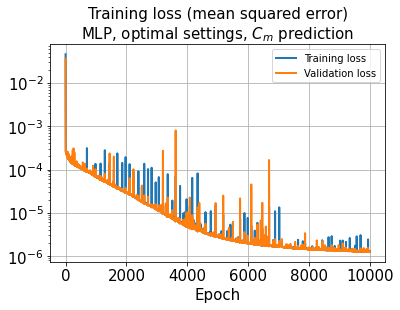

In [31]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

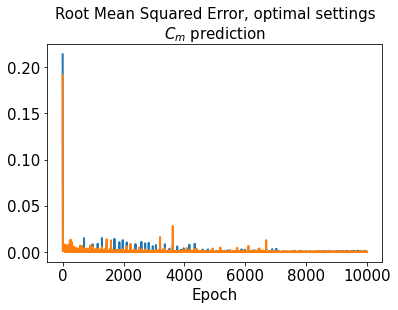

In [32]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

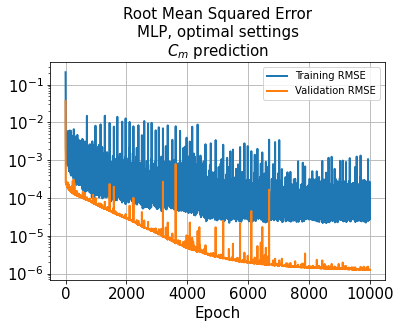

In [33]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [34]:
train_results = model.evaluate(x_train, y_train)

1750/1750 [==============================] - 5s 3ms/step - loss: 1.2524e-06 - rmse: 8.1553e-05


In [35]:
val_results = model.evaluate(x_val, y_val)

501/501 [==============================] - 2s 3ms/step - loss: 1.2523e-06 - rmse: 8.0926e-05


In [36]:
test_results = model.evaluate(x_test, y_test)

250/250 [==============================] - 1s 3ms/step - loss: 1.2520e-06 - rmse: 7.9260e-05


In [37]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

250/250 [==============================] - 0s 1ms/step


In [38]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [39]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [40]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [41]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [42]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [43]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [44]:
model_directory = "D:\\TrainedModels\\20221219"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221219unsteadyValidation_MLP_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"unitsCmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [45]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [46]:
os.chdir(storage_dir)

In [47]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [48]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = mape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.0003601202530306792
373.29669294967


In [49]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= mape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

0.0003568671742037911
354.96974070055495


In [50]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= mape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

0.00035403216187702914
362.21266615891483


In [51]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [52]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [53]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [54]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = mape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [55]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = mape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [56]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = mape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [57]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

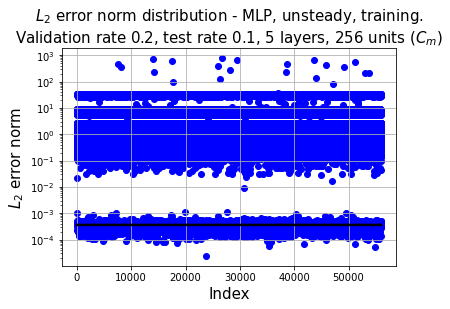

In [58]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

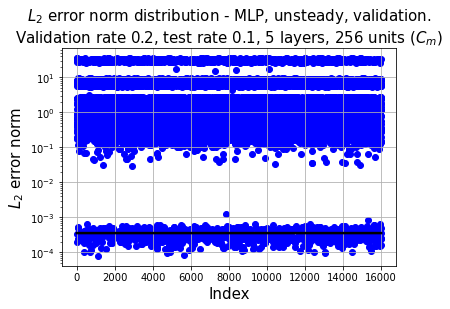

In [59]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

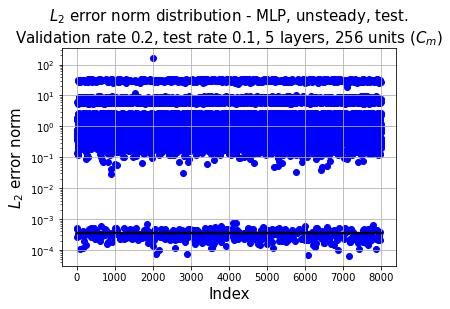

In [60]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [61]:
predicted = model.predict(x)

2500/2500 [==============================] - 3s 1ms/step


In [62]:
np.max(x)

1.0

In [63]:
t_train = t[index_train]
t_val = t[index_val]
t_test = t[index_test]

In [64]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [65]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [70]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tTest, iTrain, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], Cm, 'k-', label='Ground truth')
    plt.plot(t[:5000], cm, 'k--', label='Predicted value')
    plt.scatter(tTrain, iTrain, color='b', label='Training set')
    plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTest, iTest, color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

NACA0018 airfoil without Gurney flap
L2 error of Cm: 1.1667


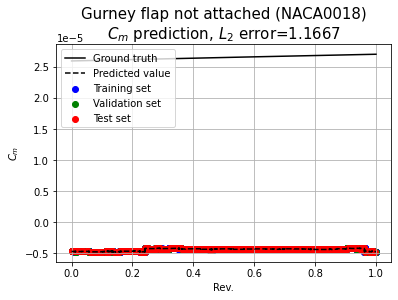

L2 error of Cm: 1.3645


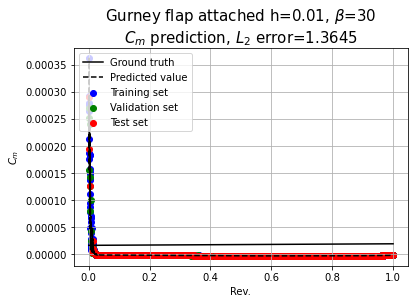

L2 error of Cm: 0.7733


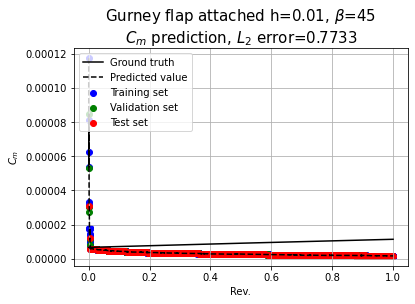

L2 error of Cm: 0.9355


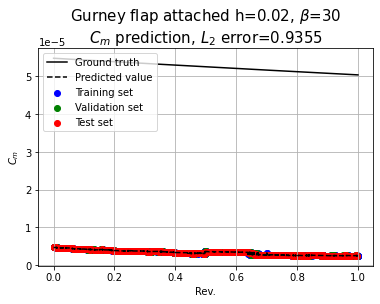

L2 error of Cm: 1.2057


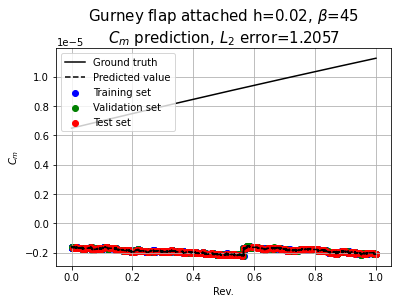

L2 error of Cm: 1.0292


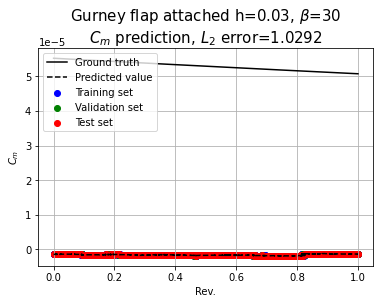

L2 error of Cm: 1.2481


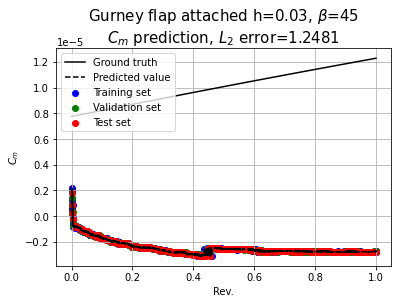

L2 error of Cm: 0.0003


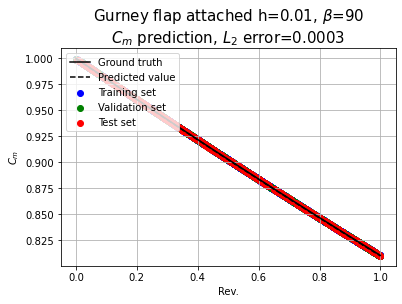

L2 error of Cm: 0.8350


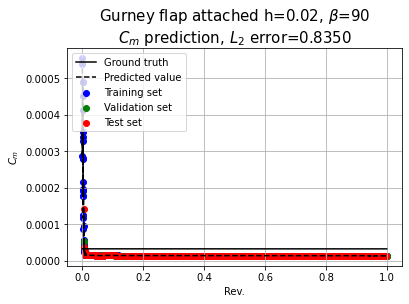

L2 error of Cm: 1.1401


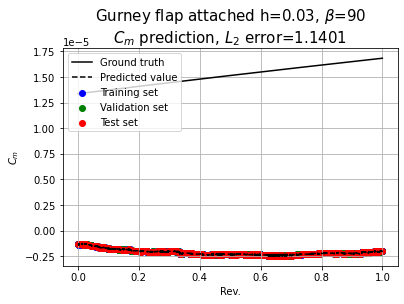

L2 error of Cm: 1.1792


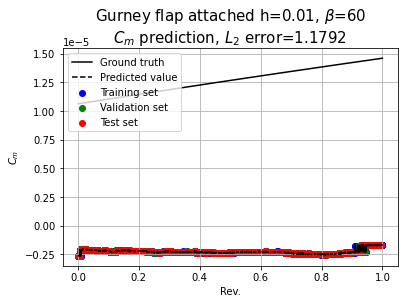

L2 error of Cm: 1.1736


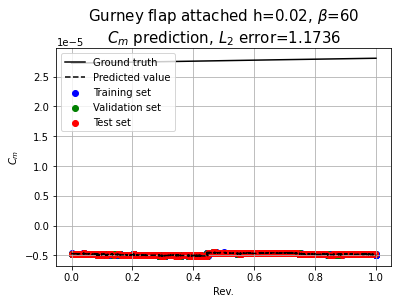

L2 error of Cm: 0.6693


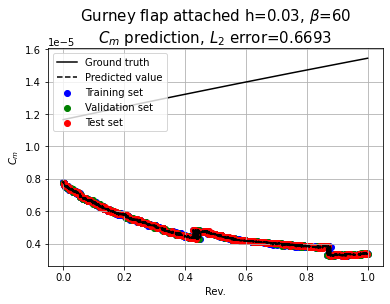

L2 error of Cm: 0.7624


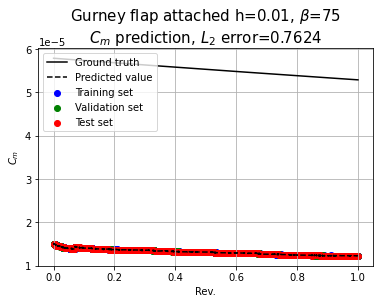

L2 error of Cm: 0.7882


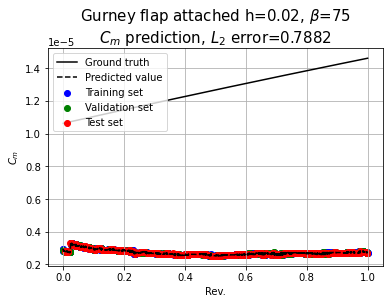

L2 error of Cm: 1.8893


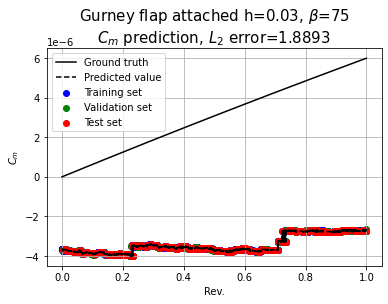

In [71]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(0, 16):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain = np.array(iTrain)
    iVal = np.array(iVal)
    iTest = np.array(iTest)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tTest, iTrain, iTest)

In [68]:
y

array([[2.59315130e-05],
       [2.59317397e-05],
       [2.59319663e-05],
       ...,
       [5.99997670e-06],
       [6.00111424e-06],
       [6.00225176e-06]])

In [69]:
cm

array([[-3.6582351e-06],
       [-3.6582351e-06],
       [-3.6582351e-06],
       ...,
       [-2.7418137e-06],
       [-2.7418137e-06],
       [-2.7455389e-06]], dtype=float32)